<a href="https://colab.research.google.com/github/jademuun/car_insurance_MTPL/blob/master/Neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 --version

Python 3.7.10


In [2]:
!pip install talos


     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 9.5MB 11.7MB/s 
     |████████████████████████████████| 5.4MB 23.8MB/s 
     |████████████████████████████████| 2.6MB 57.4MB/s 
  Created wheel for wrangle: filename=wrangle-0.6.7-cp37-none-any.whl size=49894 sha256=34e1b09673d544427b2b62305957340e6f58c5e05c410ff445a5555618f72187
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-cp37-none-any.whl size=3603 sha256=c5257b5a2874f580f9ed94e59712dfd18a3a53ba53f1b31e4c76447e5995d20f
  Stored in directory: /root/.cache/pip/wheels/9d/d3/8c/9503a22b0a38e8b21c70ad834e4606d209193443e5c709305d
  Created wheel for chances: filename=chances-0.1.9-cp37-none-any.whl size=41610 sha256=eb96ef4268754d98e8d6f57d0c0909e6b567f883dcb9408c10d822305c6df605
  Stored in directory: /root/.cache/pip/wheels/75/33/46/c871b94249bd57d17797d049b3dff8e3a09c315a

# Libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import countplot
from matplotlib.pyplot import figure, show
import timeit

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K

from keras.activations import relu, tanh
from keras.optimizers import Adam, Nadam, SGD, RMSprop

import talos
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from talos.model.normalizers import lr_normalizer
from talos.utils import hidden_layers
from tensorflow.keras import regularizers


# Additional preproccesing and functions

In [4]:
claim = pd.read_csv('/content/drive/MyDrive/data/scaled.csv')
claim = claim.drop(claim.columns[[0, 1]], axis = 1)
train_idx = pd.read_csv('/content/drive/MyDrive/data/mylist.csv')

In [5]:
train = claim.iloc[train_idx.iloc[:,0],:]
test = claim.drop(train_idx.iloc[:,0], axis = 0)

In [6]:
# target
N_train = train.ClaimNb.values
N_test = test.ClaimNb.values

# exposure
v_train = train.Exposure.values
v_test = test.Exposure.values

# lv is offset - log(exposure)
lv_train = np.log(v_train)
lv_test = np.log(v_test)

x_train = train.drop(['ClaimNb', 'Exposure'], axis = 1).values
x_test = test.drop(['ClaimNb', 'Exposure'], axis = 1).values

In [7]:
x_train.shape

(610212, 37)

In [8]:
# plotting the loss
def plot_loss(history, yran,  measure = 'loss',
              valmeasure = 'val_loss', val = True):
  plt.plot(history.history[measure], label=measure)
  if val:
    plt.plot(history.history[valmeasure], label=valmeasure)
  plt.ylim(yran)
  plt.xlabel('Epoch')
  plt.ylabel('Deviancia')
  plt.legend()
  plt.grid(True)

# logarithm limit in deviance

# deviance according to Wuthrix
def deviance(lambd, v, N, homogenous = False):
  log = 0
  NN = 0
  if homogenous is True:
    Mu = np.asarray(lambd * v)
  else:
    Mu = np.asarray(lambd)
  for n, mu  in zip(N, Mu):
    if n != 0:
      log += n * np.log(n / mu)
      NN += n
  result = 2 * (np.sum(Mu) - NN + log)/ N.shape[0]
  return result
  
def prediction(model):
  training = model.predict([x_train, lv_train]).flatten()
  testing = model.predict([x_test, lv_test]).flatten()
  print('Deviancia na trenovacej mnozine je: ', deviance(training, v_train, N_train))
  print('Deviancia na testovacej mnozine je: ', deviance(testing, v_test, N_test))
  print('Priemerna frekvencia na testovacej mnozine: ', testing.sum() / v_test.sum())

def poisson_deviance(y_true, y_pred):
  y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  return 2 * K.mean(y_pred - y_true + y_true * math_ops.log((y_true + K.epsilon()) /(y_pred + K.epsilon())), axis=-1)
 



# Homogenous portfolio

In [9]:
lambda_hat_train = np.sum(N_train) / np.sum(v_train)
lambda_hat_test = np.sum(N_test) / np.sum(v_test)

In [10]:
lambda_hat_train

0.10022331582809059

In [11]:
lambda_hat_test

0.10412087195443295

In [12]:
deviance(lambda_hat_train, v_train, N_train, True)

0.32935182815703434

In [13]:
deviance(lambda_hat_test, v_test, N_test, True)

0.3385356624308628

In [14]:
N_test.mean()

0.0551466792525184

# Shallow model

## No offset

In [ ]:
q0 = 37
q1 = 24
batch = 1024
epoch = 150

In [ ]:
Design = tf.keras.Input(shape=(q0,), name = 'Design')
layer1  = layers.Dense(q1, activation = 'tanh' , name = 'Layer1')(Design)
response = layers.Dense(1, activation='exponential',
                        name = 'Response')(layer1)

shallow_no_offset = keras.Model(
                      inputs = Design,
                      outputs = response)

shallow_no_offset.compile(loss = poisson_deviance, optimizer = 'Adam')

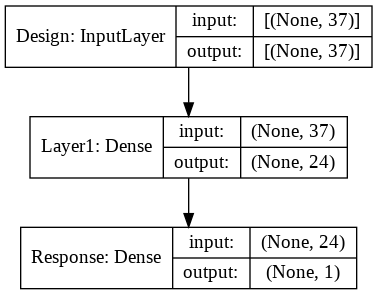

In [ ]:
keras.utils.plot_model(shallow_noofset, "shallow_model.png", show_shapes=True)

## Basic


In [ ]:
q0 = 37
q1 = 24
batch = 1024
epoch = 150

In [ ]:
Design = tf.keras.Input(shape=(q0,), name = 'Design')
layer1  = layers.Dense(q1, activation = 'tanh' , name = 'Layer1')(Design)
Network = layers.Dense(1, activation= 'linear', name = 'Network')(layer1)
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential',
                        name = 'Response',
                        kernel_initializer = tf.keras.initializers.Constant(1.),
                        bias_initializer = 
                        tf.keras.initializers.Constant(0.))(addition)

shallow_base = keras.Model(
                      inputs = [Design, LogVol],
                      outputs = response)

shallow_base.compile(loss = poisson_deviance, optimizer = 'Adam')

In [ ]:
shallow_base.build(input_shape=(37,))
shallow_base.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 37)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 24)           912         Design[0][0]                     
__________________________________________________________________________________________________
Network (Dense)                 (None, 1)            25          Layer1[0][0]                     
__________________________________________________________________________________________________
LogVol (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
history = shallow_base.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose=2,
    epochs=epoch,
    batch_size = batch)


Epoch 1/150
596/596 - 1s - loss: 0.3449 - val_loss: 0.3325
Epoch 2/150
596/596 - 1s - loss: 0.3227 - val_loss: 0.3300
Epoch 3/150
596/596 - 1s - loss: 0.3208 - val_loss: 0.3291
Epoch 4/150
596/596 - 1s - loss: 0.3198 - val_loss: 0.3286
Epoch 5/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3281
Epoch 6/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3278
Epoch 7/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3279
Epoch 8/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 9/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3279
Epoch 10/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3277
Epoch 11/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3280
Epoch 12/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3274
Epoch 13/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3282
Epoch 14/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3280
Epoch 15/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3275
Epoch 16/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3274
Epoch 17/150
596/596 - 1s - loss: 0.3177 - val_lo

In [ ]:
prediction(shallow_base)

Deviancia na trenovacej mnozine je:  0.3141031893251166
Deviancia na testovacej mnozine je:  0.32694657699170115


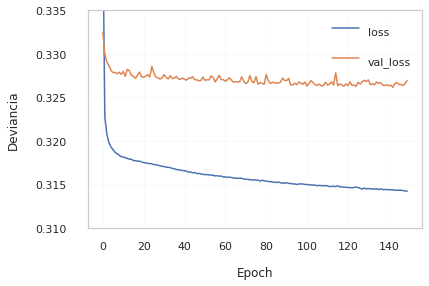

In [ ]:
plot_loss(history, yran=[0.31, 0.335], val = True)

## MLE init

In [ ]:
q0 = 37
g1 = 24
batch = 1024
epoch = 150

In [ ]:
Design = tf.keras.Input(shape=(q0,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(q1, activation = 'tanh' , name = 'Layer1')(Design)
Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                        kernel_initializer = tf.keras.initializers.Constant(0.),
                        bias_initializer =
                        tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer1)
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential'
, name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
bias_initializer = tf.keras.initializers.Constant(0.))(addition)
shallow = keras.Model(
                      inputs = [Design, LogVol],
                      outputs = response
  )
shallow.compile(loss = poisson_deviance, optimizer = 'Adam') 

shallow.build(input_shape=(37,))
shallow.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 37)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 24)           912         Design[0][0]                     
__________________________________________________________________________________________________
Network (Dense)                 (None, 1)            25          Layer1[0][0]                     
__________________________________________________________________________________________________
LogVol (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

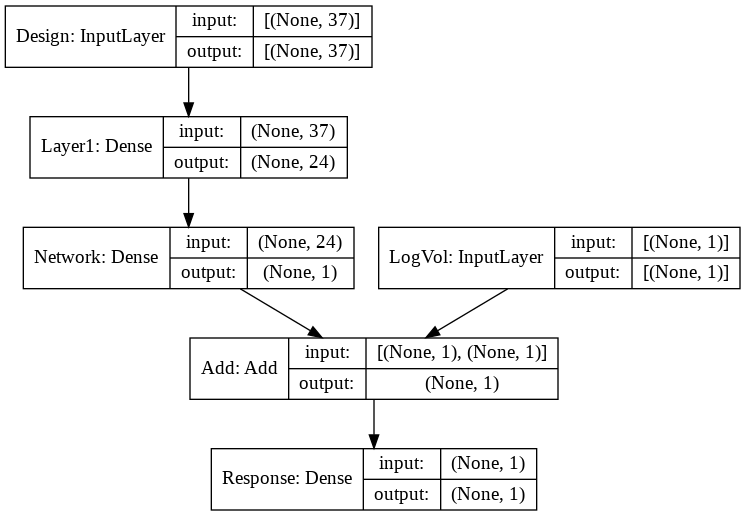

In [ ]:
keras.utils.plot_model(shallow, "shallow_model.png", show_shapes=True)

In [ ]:
history = shallow.fit(
    #x = [x, lv],
    #y = y,
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose=2,
    epochs=epoch,
    batch_size = batch)

Epoch 1/150
596/596 - 1s - loss: 0.3249 - val_loss: 0.3307
Epoch 2/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3281
Epoch 3/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3277
Epoch 4/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3277
Epoch 5/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3276
Epoch 6/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3279
Epoch 7/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3281
Epoch 8/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3280
Epoch 9/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3284
Epoch 11/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3275
Epoch 13/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 14/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 15/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 16/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 17/150
596/596 - 1s - loss: 0.3177 - val_lo

NameError: ignored

In [ ]:
shallow.save('/content/drive/MyDrive/models/shallow_2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/shallow_2/assets


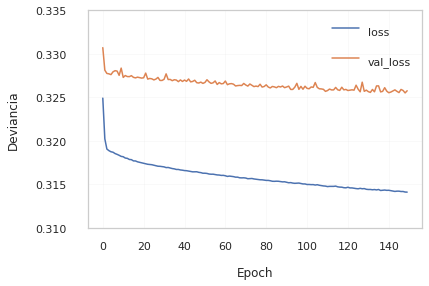

In [ ]:
plot_loss(history, yran=[0.31, 0.335], val = True)

In [ ]:
prediction(shallow)

Deviancia na trenovacej mnozine je:  0.3138057934738944
Deviancia na testovacej mnozine je:  0.3257563137677383


# Optimizer optimalization -  Shallow Net



In [ ]:
p = {'optimizer': [SGD, RMSprop, Nadam, Adam],
      'first_neuron': [16, 24, 32],
      'activation': ['relu', 'tanh'],
      'batch_size': [512, 1024, 2048],
      'lr': [0.002, 0.004, 0.01]
}
epoch = 150 # fix

In [ ]:
def shallow_optim(x_train, N_train, x_test, N_test, params):
  Design = tf.keras.Input(shape=(37,), name = 'Design')
  LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
  layer1  = layers.Dense(params['first_neuron'], activation = params['activation'] , name = 'Layer1')(Design)
  Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                          kernel_initializer = tf.keras.initializers.Constant(0.),
                          bias_initializer =
                          tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer1)
  addition = layers.add([Network, LogVol], name = 'Add')
  response = layers.Dense(1, activation='exponential'
  , name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
  bias_initializer = tf.keras.initializers.Constant(0.))(addition)
  shallow = keras.Model(
      inputs = [Design, LogVol],
      outputs = response
  )
  shallow.compile(loss = poisson_deviance, optimizer = params['optimizer'](lr = params['lr'])) 

  #shallow.build(input_shape=(37,))
  #shallow.summary()
  history = shallow.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose = 2,
    epochs = epoch,
    batch_size = params['batch_size'])
  return history, shallow

In [ ]:
x_train.shape

(610212, 37)

In [ ]:
scan_shallow = talos.Scan(x=x_train, y=N_train, x_val= x_test, y_val=N_test , params=p, model=shallow_optim, experiment_name='shallow_optimalization_4', save_weights=True)

In [ ]:
scan_shallow.data.drop(['start', 'end'], axis = 1).sort_values(by = 'val_loss').head(10)

duration  ...                                          optimizer
94    96.258291  ...  <class 'tensorflow.python.keras.optimizer_v2.n...
18   326.940323  ...  <class 'tensorflow.python.keras.optimizer_v2.n...
62   169.970877  ...  <class 'tensorflow.python.keras.optimizer_v2.n...
58   171.068602  ...  <class 'tensorflow.python.keras.optimizer_v2.n...
14   328.005995  ...  <class 'tensorflow.python.keras.optimizer_v2.n...
15   251.503479  ...  <class 'tensorflow.python.keras.optimizer_v2.a...
46   171.082545  ...  <class 'tensorflow.python.keras.optimizer_v2.n...
6    328.519667  ...  <class 'tensorflow.python.keras.optimizer_v2.n...
54   170.958231  ...  <class 'tensorflow.python.keras.optimizer_v2.n...
106   95.872369  ...  <class 'tensorflow.python.keras.optimizer_v2.n...

[10 rows x 9 columns]

In [ ]:
scan_shallow.data.drop(['start', 'end'], axis = 1).sort_values(by = 'val_loss', ascending=False).head(10)

duration  ...                                          optimizer
45   143.392827  ...  <class 'tensorflow.python.keras.optimizer_v2.r...
105   83.406837  ...  <class 'tensorflow.python.keras.optimizer_v2.r...
9    270.007346  ...  <class 'tensorflow.python.keras.optimizer_v2.r...
69   143.951133  ...  <class 'tensorflow.python.keras.optimizer_v2.r...
17   270.815772  ...  <class 'tensorflow.python.keras.optimizer_v2.r...
57   143.689167  ...  <class 'tensorflow.python.keras.optimizer_v2.r...
33   271.957649  ...  <class 'tensorflow.python.keras.optimizer_v2.r...
65   144.258424  ...  <class 'tensorflow.python.keras.optimizer_v2.r...
72    76.151300  ...  <class 'tensorflow.python.keras.optimizer_v2.g...
96    76.169772  ...  <class 'tensorflow.python.keras.optimizer_v2.g...

[10 rows x 9 columns]

In [ ]:
analyze_object = talos.Analyze(scan_shallow)


In [ ]:
analyze_object.low('val_loss')

0.31775766611099243

Text(14.875, 0.5, 'Validačná chyba')

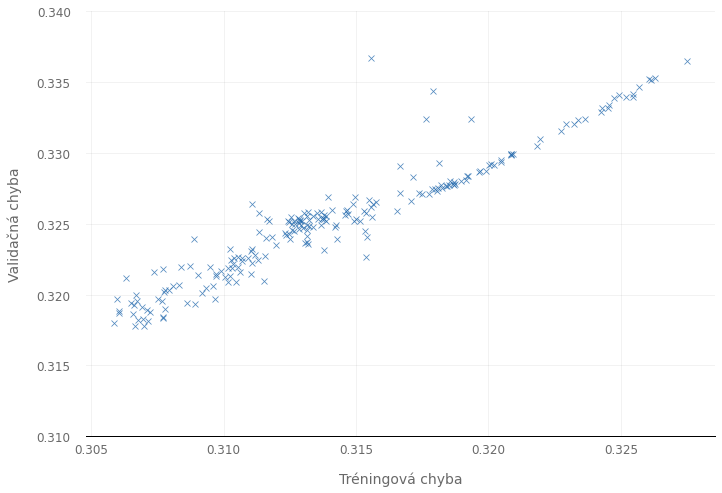

In [ ]:
analyze_object.plot_regs('loss', 'val_loss')
plt.ylim((0.31,0.34))
plt.xlabel('Tréningová chyba')
plt.ylabel('Validačná chyba')

Text(14.875, 0.5, 'Validačná chyba')

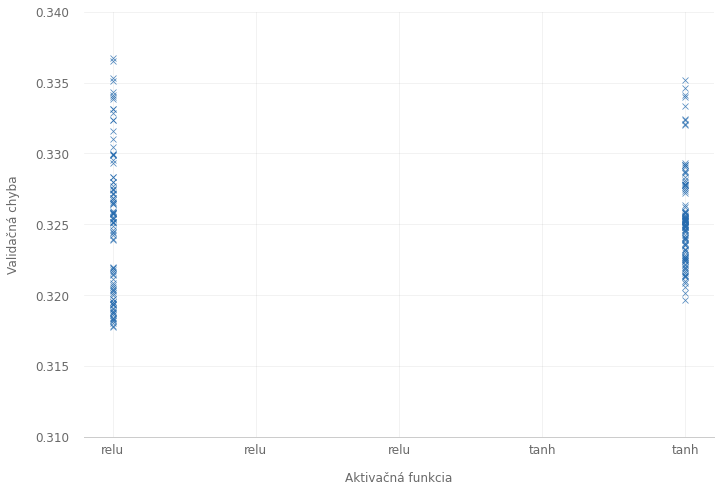

In [ ]:
analyze_object.plot_regs('activation', 'val_loss')
plt.ylim((0.31,0.34))
plt.xlabel('Aktivačná funkcia')
plt.ylabel('Validačná chyba')

Text(0, 0.5, 'Validačná chyba')

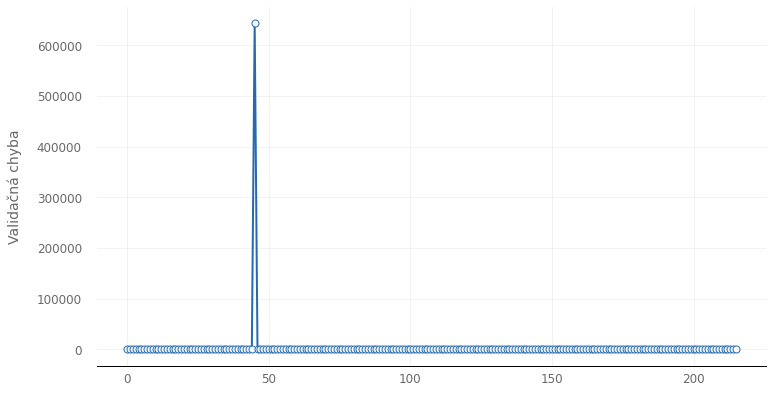

In [ ]:
analyze_object.plot_line('val_loss')
plt.ylabel('Validačná chyba')

Text(0.5, 24.4, 'Tréningová chyba')

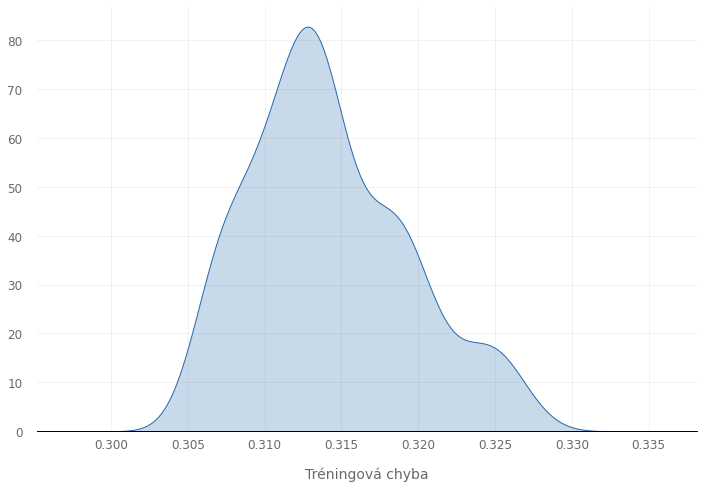

In [ ]:
analyze_object.plot_kde('loss')
plt.xlabel('Tréningová chyba')


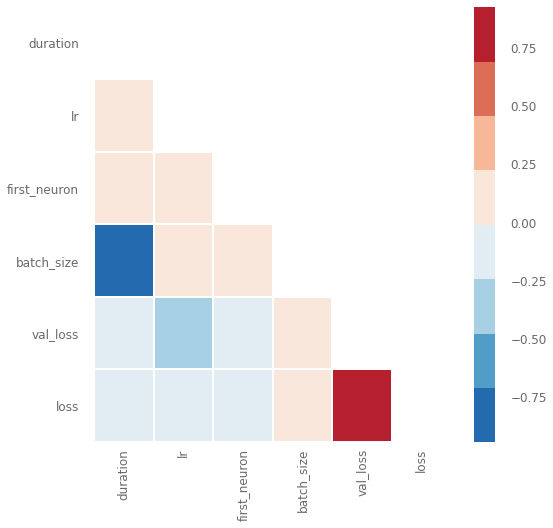

In [ ]:
analyze_object.plot_corr('val_loss', ['round_epochs'])


Text(0.5, 0, 'N')

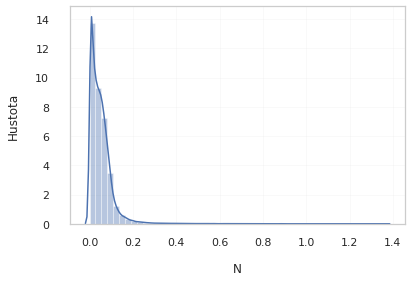

In [ ]:
#best model
best_shallow = scan_shallow.best_model(metric = 'val_loss', asc=True)
predictions = best_shallow.predict([x_test, lv_test]).flatten()
ax = sns.distplot(predictions)
#sns.histplot(predictions,  stat = 'probability')
sns.set_theme(style="whitegrid")
ax.set_ylabel("Hustota")
ax.set_xlabel("N")

In [ ]:
# mean freq
print(predictions.sum()/ v_test.sum())
# mean 
print(predictions.mean())

0.09778482008346892
0.05179085


In [ ]:
prediction(best_shallow)

Deviancia na trenovacej mnozine je:  0.3058743428619286
Deviancia na testovacej mnozine je:  0.31775812978656354


In [ ]:
talos.Deploy(scan_shallow, model_name = 'shalllow_scan', metric = 'val_loss', asc=True)

Deploy package shalllow_scan have been saved.


# Deep

## Scan of optimalization hyperparameters

In [ ]:
########################### Learning rate
##################################################
p_lr = {'activation':['tanh'],
          'optimizer': [Nadam],
          'first_neuron': [32], 
          'second_neuron': [24],   
          'third_neuron': [16],       
         # 'dropout': [0],         
          'batch_size': [1024],
          'epochs': [150],
          'lr': [0.0001, 0.001, 0.05]}

In [ ]:
def deep_scan(x_train, N_train, x_test, N_test, params):
  Design = tf.keras.Input(shape=(37,), name = 'Design')
  LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
  layer1  = layers.Dense(params['first_neuron'], activation = params['activation'], name = 'Layer1')(Design)
  layer2  = layers.Dense(params['second_neuron'], params['activation'],  name = 'Layer2')(layer1)
  layer3  = layers.Dense(params['third_neuron'], params['activation'],  name = 'Layer3')(layer2)
  Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                          kernel_initializer = tf.keras.initializers.Constant(0.),
                          bias_initializer =
                          tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer3)

  addition = layers.add([Network, LogVol], name = 'Add')
  response = layers.Dense(1, activation='exponential'
  , name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
  bias_initializer = tf.keras.initializers.Constant(0.))(addition)
  deep = keras.Model(
      inputs = [Design, LogVol],
      outputs = response
  )
  deep.compile(loss = poisson_deviance, optimizer = params['optimizer'](lr = params['optimizer'])) 

  history = deep.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose = 2,
    epochs = params['epochs'],
    batch_size = params['batch_size'])
  return history, deep

In [ ]:
scanned_lr = talos.Scan(x_train, N_train, model = deep_lr, params = p_lr, experiment_name= 'testing_bs', x_val = x_test, y_val= N_test)

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(3):
  batch = scanned_lr.round_history[i]['val_loss']
  batch_size[i] = batch
batch_size.columns = [0.0001, 0.001, 0.05]

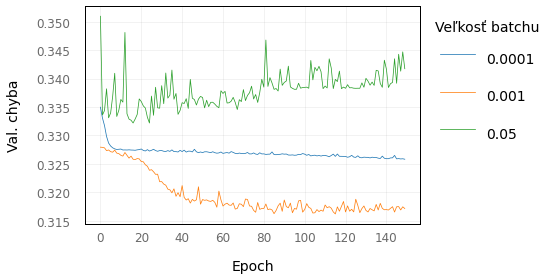

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Val. chyba')
ax.legend(bbox_to_anchor = (1.4,1), title="Veľkosť batchu")
fig = ax.get_figure()
fig.savefig('batch_types.png')

In [ ]:
########################## Batch size
########################################################
p_deep = {'activation':['tanh'],
          'optimizer': [Nadam],
          'first_neuron': [32], 
          'second_neuron': [24],   
          'third_neuron': [16],       
         # 'dropout': [0],         
          'batch_size': [256, 512, 1024, 2048, 4096, 10000, 200000],
          'epochs': [100],
          'lr': [ 0.001]}

In [ ]:
scanned_lr = talos.Scan(x_train, N_train, model = deep_lr, params = p_deep, experiment_name= 'testing_bs', x_val = x_test, y_val= N_test)

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(7):
  batch = scanned_lr.round_history[i]['loss']
  batch_size[i] = batch
batch_size.columns = [256, 512, 1024, 2048, 4096, 10000, 200000]


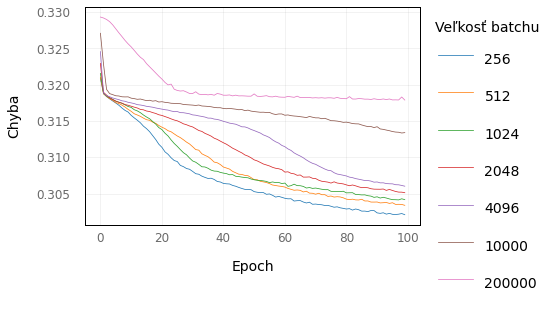

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.4,1), title="Veľkosť batchu")
fig = ax.get_figure()
fig.savefig('batch_types.png')

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(7):
  batch = scanned_lr.round_history[i]['val_loss']
  batch_size[i] = batch
batch_size.columns = [256, 512, 1024, 2048, 4096, 10000, 200000]

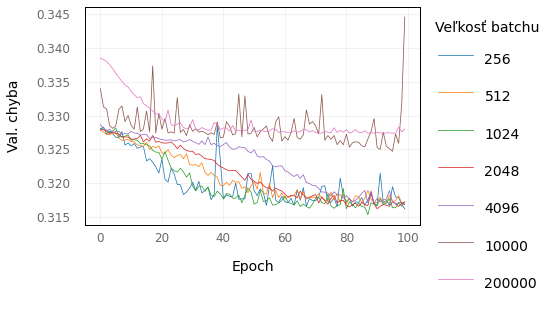

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Val. chyba')
ax.legend(bbox_to_anchor = (1.4,1), title="Veľkosť batchu")
fig = ax.get_figure()
fig.savefig('batch_types.png')

In [ ]:
################# ACTIVATION
#############################################
p_act = {'activation':['tanh', 'relu'],
          'optimizer': [Nadam],
          'first_neuron': [32], 
          'second_neuron': [24],   
          'third_neuron': [16],       
         # 'dropout': [0],         
          'batch_size': [1024],
          'epochs': [100],
          'lr': [ 0.001]}

In [ ]:
scanned_lr = talos.Scan(x_train, N_train, model = deep_lr, params = p_act, experiment_name= 'testing_bs', x_val = x_test, y_val= N_test)

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(2):
  batch = scanned_lr.round_history[i]['val_loss']
  batch_size[i] = batch
batch_size.columns = ['tanh', 'ReLu']

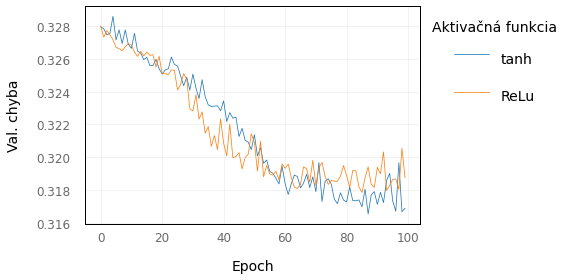

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Val. chyba')
ax.legend(bbox_to_anchor = (1.45,1), title="Aktivačná funkcia")
fig = ax.get_figure()
fig.savefig('batch_types.png')

In [ ]:
################# optimalization algorithm
#############################################
p_opt = {'activation':['tanh'],
          'optimizer': [SGD, RMSprop, Adam, Nadam],
          'first_neuron': [32], 
          'second_neuron': [24],   
          'third_neuron': [16],       
         # 'dropout': [0],         
          'batch_size': [1024],
          'epochs': [150]}

In [ ]:
scanned_lr = talos.Scan(x_train, N_train, model = deep_lr, params = p_opt, experiment_name= 'testing_bs', x_val = x_test, y_val= N_test)

In [ ]:
batch_size = pd.DataFrame()
analyze_object = talos.Analyze(scanned_lr)
for i in range(4):
  batch = scanned_lr.round_history[i]['loss']
  batch_size[i] = batch
batch_size.columns = ['SGD', 'RMSprop','Adam', 'Nadam']

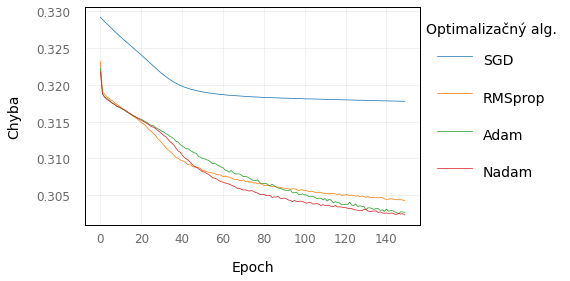

In [ ]:
ax = sns.lineplot(data=batch_size, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.45,1), title="Optimalizačný alg.")
fig = ax.get_figure()
fig.savefig('batch_types.png')

## Scan of architercutre

In [ ]:
def deep_scan(x_train, N_train, x_test, N_test, params):
  Design = tf.keras.Input(shape=(37,), name = 'Design')
  LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
  layer1  = layers.Dense(params['first_neuron'], activation = params['activation'], name = 'Layer1')(Design)
  layer2  = layers.Dense(params['second_neuron'], params['activation'],  name = 'Layer2')(layer1)
  layer3  = layers.Dense(params['third_neuron'], params['activation'],  name = 'Layer3')(layer2)
  Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                          kernel_initializer = tf.keras.initializers.Constant(0.),
                          bias_initializer =
                          tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer3)

  addition = layers.add([Network, LogVol], name = 'Add')
  response = layers.Dense(1, activation='exponential'
  , name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
  bias_initializer = tf.keras.initializers.Constant(0.))(addition)
  deep = keras.Model(
      inputs = [Design, LogVol],
      outputs = response
  )
  deep.compile(loss = poisson_deviance, optimizer = params['optimizer'](lr = params['lr'])) 

  history = deep.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose = 2,
    epochs = params['epochs'],
    batch_size = params['batch_size'])
  return history, deep

In [ ]:
########################### layers
##################################################
p_str = {'activation':['tanh'],
          'optimizer': [Nadam],
          'first_neuron': [64, 48, 40, 32, 24], 
          'second_neuron': [40, 32, 24, 16],   
          'third_neuron': [24, 16, 10],             
          'batch_size': [1024, 2048],
          'epochs': [150],
          'lr': [0.002]}

In [ ]:
scanned_layers = talos.Scan(x_train, N_train, model = deep_scan, params = p_str, experiment_name= 'testing_layers', x_val = x_test, y_val= N_test)

In [ ]:
analyze_deep = talos.Analyze(scanned_layers)

In [ ]:
scanned_layers.data.drop(['start', 'end', 'epochs','round_epochs', 'activation', 'lr'], axis = 1).sort_values(by = 'val_loss').head(10)

duration      loss  ...  second_neuron  third_neuron
114  154.580538  0.301643  ...             24            24
112  154.601599  0.301654  ...             32            16
109  151.407556  0.300753  ...             40            16
116  153.011465  0.302879  ...             24            10
56   273.260674  0.301012  ...             24            10
110  152.804097  0.301260  ...             40            10
66   147.588226  0.298565  ...             24            24
106  151.839063  0.303026  ...             16            16
103  148.444797  0.300867  ...             24            16
94   152.478592  0.302073  ...             16            16

[10 rows x 8 columns]

In [ ]:
df_val = pd.DataFrame()
df_val['best_val_loss'] = scanned_layers.round_history[114]['loss']
df_val['best_val_val_loss'] = scanned_layers.round_history[114]['val_loss']
df_val.columns = ['Tréningová chyba', 'Validačná chyba']

In [ ]:
scanned_layers.data.drop(['start', 'end', 'epochs','round_epochs', 'activation', 'lr'], axis = 1).sort_values(by = 'loss').head(10)

duration      loss  ...  second_neuron  third_neuron
1   286.251574  0.292876  ...             40            16
0   294.837796  0.293098  ...             40            24
3   287.608987  0.293737  ...             32            24
12  282.674445  0.294399  ...             40            24
60  148.040660  0.294754  ...             40            24
2   288.055216  0.294767  ...             40            10
4   286.790710  0.294791  ...             32            16
13  281.197824  0.295188  ...             40            16
72  149.355346  0.295539  ...             40            24
61  146.973080  0.295616  ...             40            16

[10 rows x 8 columns]

In [ ]:
df_los = pd.DataFrame()
df_los['best_val_loss'] = scanned_layers.round_history[1]['loss']
df_los['best_val_val_loss'] = scanned_layers.round_history[1]['val_loss']
df_los.columns = ['Tréningová chyba', 'Validačná chyba']

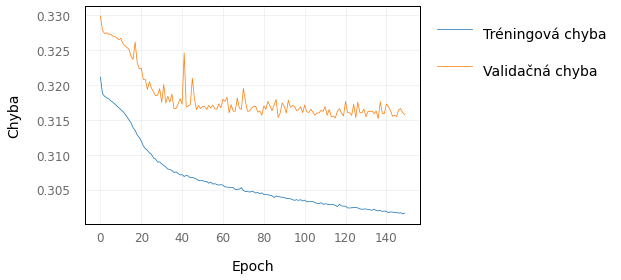

In [ ]:
ax = sns.lineplot(data=df_val, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.6,1))
plt.savefig('best_val.png',   bbox_inches = 'tight')

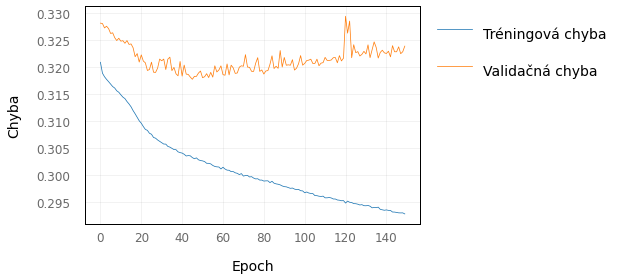

In [ ]:
ax = sns.lineplot(data=df_los, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.6,1))
plt.savefig('best_loss.png',   bbox_inches = 'tight')

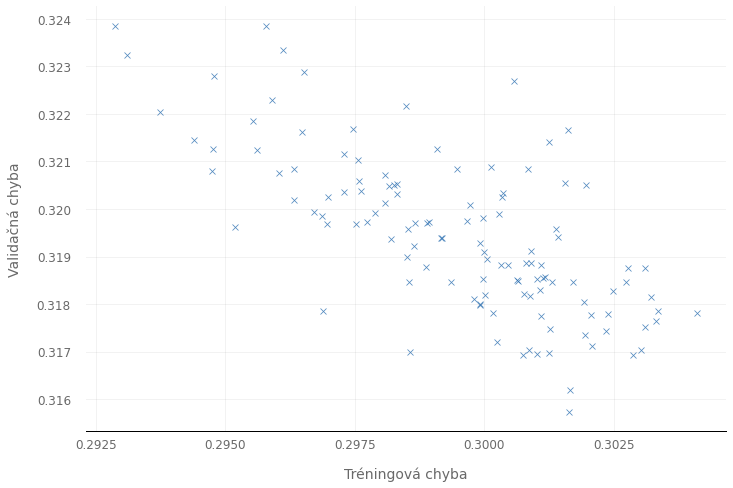

In [ ]:
analyze_deep.plot_regs('loss', 'val_loss')
plt.xlabel('Tréningová chyba')
plt.ylabel('Validačná chyba')
plt.savefig('val_to_losss.png',   bbox_inches = 'tight')

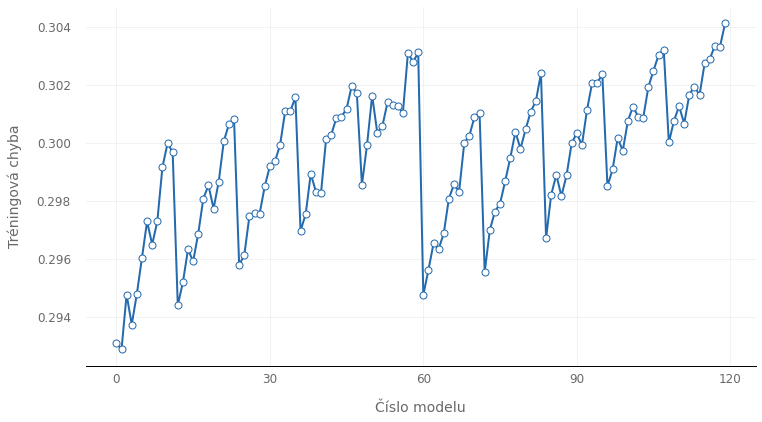

In [ ]:
analyze_deep.plot_line('loss')
plt.xlabel('Číslo modelu')
plt.ylabel('Tréningová chyba')
plt.savefig('no_loss.png',  bbox_inches = 'tight')

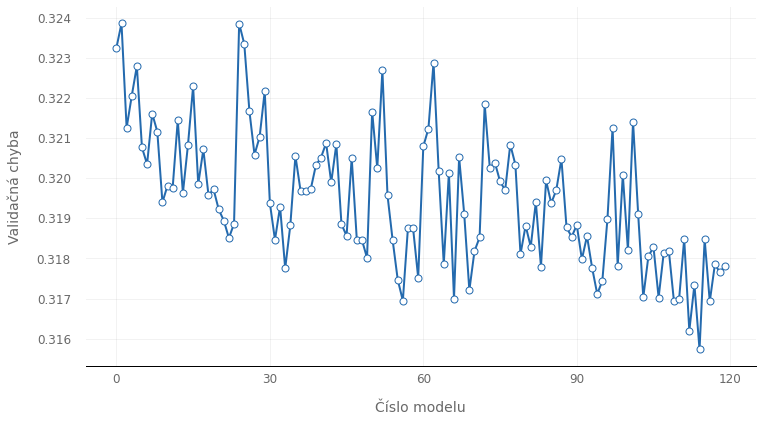

In [ ]:
analyze_deep.plot_line('val_loss')
plt.xlabel('Číslo modelu')
plt.ylabel('Validačná chyba')
plt.savefig('no_val.png',  bbox_inches = 'tight')

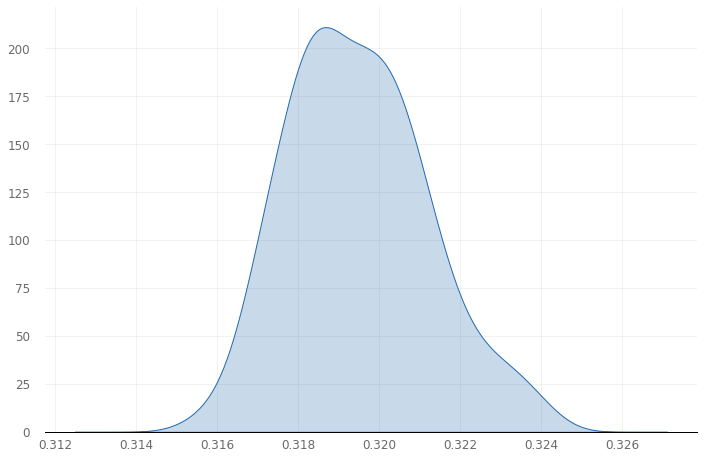

In [ ]:
analyze_deep.plot_kde('val_loss')

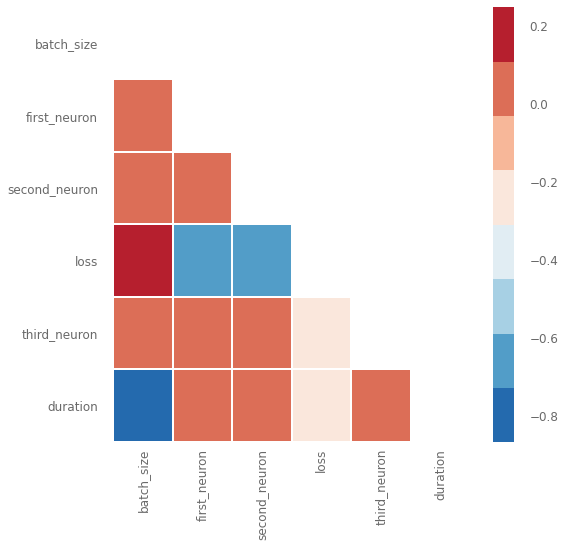

In [ ]:
analyze_deep.plot_corr('loss', ['start','end', 'lr', 'epochs', 'round_epochs', 'val_loss'])
plt.savefig('cor_loss.png', bbox_inches = 'tight')

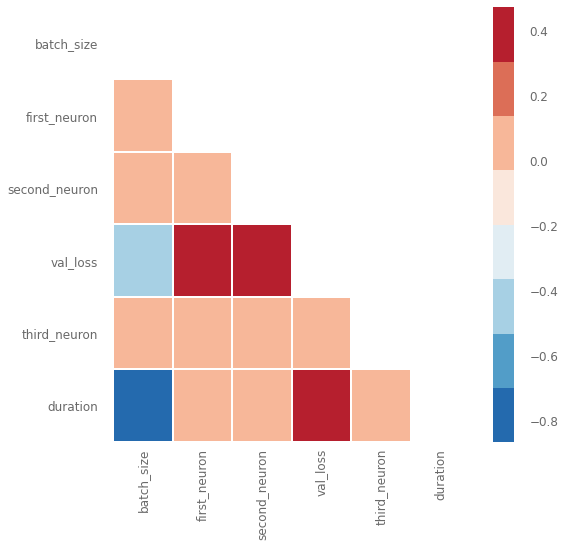

In [ ]:
analyze_deep.plot_corr('val_loss', ['start','end', 'lr', 'epochs', 'round_epochs', 'loss'])
plt.savefig('cor_val.png', bbox_inches = 'tight')

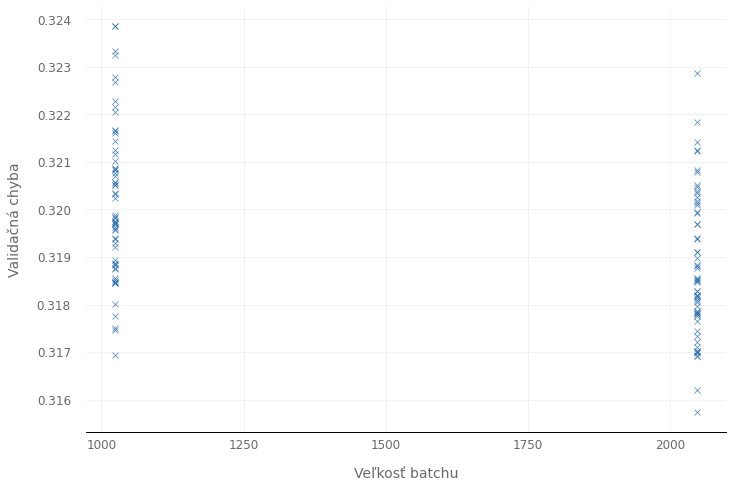

In [ ]:
analyze_deep.plot_regs('batch_size', 'val_loss')
plt.xlabel('Veľkosť batchu')
plt.ylabel('Validačná chyba')
plt.savefig('batch_loss.png',  bbox_inches = 'tight')

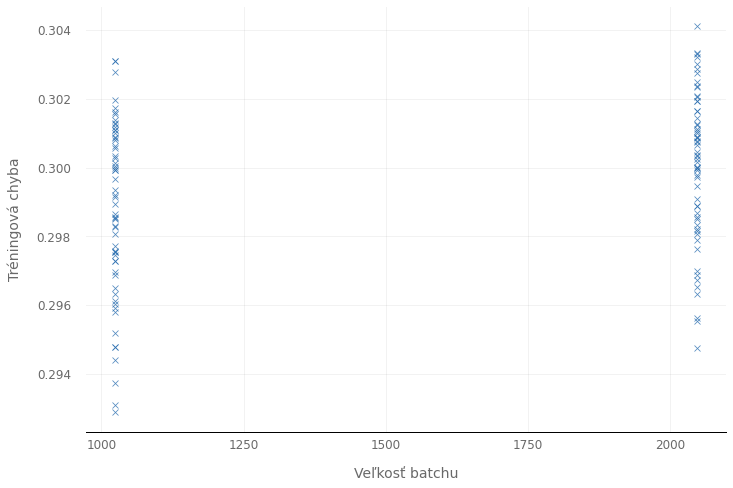

In [ ]:
analyze_deep.plot_regs('batch_size', 'loss')
plt.xlabel('Veľkosť batchu')
plt.ylabel('Tréningová chyba')
plt.savefig('batch_val.png',  bbox_inches = 'tight')

Text(0.5, 0, 'N')

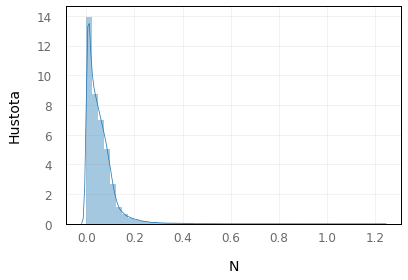

In [ ]:
#best model
deep_arch = scanned_layers.best_model(metric = 'val_loss', asc=True)
predictions = deep_arch.predict([x_test, lv_test]).flatten()
ax = sns.distplot(predictions)
#sns.histplot(predictions,  stat = 'probability')
sns.set_theme(style="whitegrid")
ax.set_ylabel("Hustota")
ax.set_xlabel("N")

In [ ]:
prediction(deep_arch)

Deviancia na trenovacej mnozine je:  0.30122074096098506
Deviancia na testovacej mnozine je:  0.31573080710551177
Priemerna frekvencia na testovacej mnozine:  0.10504229235113727


In [ ]:
analyze_deep.best_params('val_loss', ['loss'], ascending=True)[1]

array([150, 150, '05/07/21-165650', '05/07/21-165415', 2048, 0.002, 24,
       32, 'tanh', 16, 154.60159873962402,
       <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>, 1],
      dtype=object)

In [ ]:
talos.Deploy(scanned_layers, model_name = 'deep_scan', metric = 'val_loss', asc=True)

Deploy package deep_scan have been saved.


## just picture of architercture

In [ ]:
Design = tf.keras.Input(shape=(37,), name = 'Design')
LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
layer1  = layers.Dense(32, activation = 'tanh', name = 'Layer1')(Design)
layer2  = layers.Dense(24, activation= 'tanh',  name = 'Layer2')(layer1)
layer3  = layers.Dense(16, activation= 'tanh',  name = 'Layer3')(layer2)
Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                        kernel_initializer = tf.keras.initializers.Constant(0.),
 bias_initializer = tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer3)
addition = layers.add([Network, LogVol], name = 'Add')
response = layers.Dense(1, activation='exponential'
, name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
 bias_initializer = tf.keras.initializers.Constant(0.))(addition)
deep = keras.Model(
    inputs = [Design,LogVol],
    outputs = response
)

deep.compile(loss = poisson_deviance, optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None))

deep.build(input_shape=(37,))
deep.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Design (InputLayer)             [(None, 37)]         0                                            
__________________________________________________________________________________________________
Layer1 (Dense)                  (None, 32)           1216        Design[0][0]                     
__________________________________________________________________________________________________
Layer2 (Dense)                  (None, 24)           792         Layer1[0][0]                     
__________________________________________________________________________________________________
Layer3 (Dense)                  (None, 16)           400         Layer2[0][0]                     
____________________________________________________________________________________________

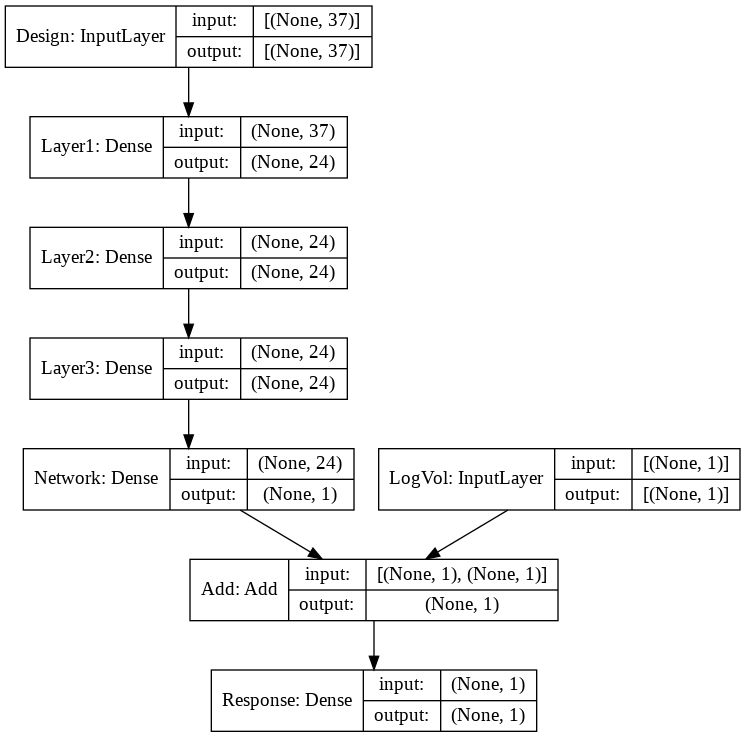

In [ ]:
keras.utils.plot_model(deep, "deep_3.png", show_shapes=True, )


# Regularization in Deep network

## Weight regularizations


In [126]:
df = pd.DataFrame()
df['loss'] = scanned_weight.round_history[129]['loss']
df['val_loss'] = scanned_weight.round_history[129]['val_loss']
df.columns = ['Tréningová chyba', 'Validačná chyba']

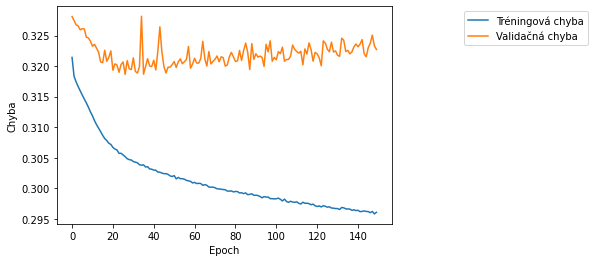

In [127]:
ax = sns.lineplot(data=df, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.6,1))
plt.savefig('best_val.png',   bbox_inches = 'tight')

In [18]:
def deep_weight(x_train, N_train, x_test, N_test, params):
  Design = tf.keras.Input(shape=(37,), name = 'Design')
  LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')
  layer1  = layers.Dense(params['first_neuron'], activation = params['activation'], name = 'Layer1',
                         kernel_regularizer = params['weight_reg'])(Design)
  layer2  = layers.Dense(params['second_neuron'], params['activation'],  name = 'Layer2',
                         kernel_regularizer = params['weight_reg'])(layer1)
  layer3  = layers.Dense(params['third_neuron'], params['activation'],  name = 'Layer3',
                         kernel_regularizer = params['weight_reg'])(layer2)
  Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                          kernel_initializer = tf.keras.initializers.Constant(0.),
                          bias_initializer =
                          tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer3)

  addition = layers.add([Network, LogVol], name = 'Add')
  response = layers.Dense(1, activation='exponential'
  , name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
  bias_initializer = tf.keras.initializers.Constant(0.))(addition)
  deep = keras.Model(
      inputs = [Design, LogVol],
      outputs = response
  )
  deep.compile(loss = poisson_deviance, optimizer = params['optimizer'](lr = params['lr'])) 

  history = deep.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose = 2,
    epochs = params['epochs'],
    batch_size = params['batch_size'])
  return history, deep

In [20]:
########################### weight hyperparameter
##################################################
p_weight0 = {'activation':[ 'tanh', 'relu'],
          'optimizer': [Nadam],
          'first_neuron': [64], 
          'second_neuron': [40],   
          'third_neuron': [24],             
          'batch_size': [1024 , 2048, 4096],
          'epochs': [150],
          'lr': [0.002, 0.005, 0.01],
          'weight_reg': [regularizers.l2(l2 = 0.0001), regularizers.l2(l2 = 0.00001), regularizers.l1_l2(l1 = 0.000001, l2 = 0.000005)]
         }

In [65]:
scanned_weight0 = talos.Scan(x_train, N_train, model = deep_weight, params = p_weight, experiment_name= 'weight_reg', x_val = x_test, y_val= N_test)











  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1/150
596/596 - 3s - loss: 0.3242 - val_loss: 0.3299
Epoch 2/150
596/596 - 1s - loss: 0.3208 - val_loss: 0.3296
Epoch 3/150
596/596 - 1s - loss: 0.3205 - val_loss: 0.3298
Epoch 4/150
596/596 - 1s - loss: 0.3203 - val_loss: 0.3293
Epoch 5/150
596/596 - 2s - loss: 0.3202 - val_loss: 0.3292
Epoch 6/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3291
Epoch 7/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3288
Epoch 8/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3290
Epoch 9/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3288
Epoch 10/150
596/596 - 2s - loss: 0.3200 - val_loss: 0.3285
Epoch 11/150
596/596 - 2s - loss: 0.3201 - val_loss: 0.3289
Epoch 12/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3289
Epoch 13/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3303
Epoch 14/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3289
Epoch 15/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3292
Epoch 16/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3287
Epoch 17/150
596/596 - 1s - loss: 0.3200 - val_lo











  3%|▎         | 1/36 [03:44<2:10:56, 224.46s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3219 - val_loss: 0.3288
Epoch 2/150
596/596 - 1s - loss: 0.3198 - val_loss: 0.3285
Epoch 3/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3297
Epoch 4/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3280
Epoch 5/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3285
Epoch 6/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3274
Epoch 7/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3277
Epoch 8/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3271
Epoch 9/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 10/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3267
Epoch 11/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3264
Epoch 13/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3266
Epoch 14/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3266
Epoch 15/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3273
Epoch 16/150
596/596 - 1s - loss: 0.3159 - val_loss: 0.3265
Epoch 17/150
596/596 - 1s - loss: 0.3155 - val_lo











  6%|▌         | 2/36 [07:28<2:07:10, 224.43s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3233 - val_loss: 0.3310
Epoch 2/150
596/596 - 1s - loss: 0.3210 - val_loss: 0.3302
Epoch 3/150
596/596 - 1s - loss: 0.3208 - val_loss: 0.3295
Epoch 4/150
596/596 - 1s - loss: 0.3207 - val_loss: 0.3297
Epoch 5/150
596/596 - 2s - loss: 0.3206 - val_loss: 0.3310
Epoch 6/150
596/596 - 1s - loss: 0.3206 - val_loss: 0.3291
Epoch 7/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3290
Epoch 8/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3292
Epoch 9/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3301
Epoch 10/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3292
Epoch 11/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3292
Epoch 12/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3291
Epoch 13/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3293
Epoch 14/150
596/596 - 2s - loss: 0.3199 - val_loss: 0.3295
Epoch 15/150
596/596 - 2s - loss: 0.3199 - val_loss: 0.3293
Epoch 16/150
596/596 - 1s - loss: 0.3199 - val_loss: 0.3292
Epoch 17/150
596/596 - 1s - loss: 0.3199 - val_lo











  8%|▊         | 3/36 [11:13<2:03:26, 224.45s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3219 - val_loss: 0.3289
Epoch 2/150
596/596 - 2s - loss: 0.3201 - val_loss: 0.3292
Epoch 3/150
596/596 - 1s - loss: 0.3197 - val_loss: 0.3293
Epoch 4/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3314
Epoch 5/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3277
Epoch 6/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3276
Epoch 7/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 8/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3279
Epoch 9/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3263
Epoch 10/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3257
Epoch 11/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3271
Epoch 12/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3244
Epoch 13/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3239
Epoch 14/150
596/596 - 1s - loss: 0.3149 - val_loss: 0.3235
Epoch 15/150
596/596 - 1s - loss: 0.3145 - val_loss: 0.3238
Epoch 16/150
596/596 - 1s - loss: 0.3143 - val_loss: 0.3242
Epoch 17/150
596/596 - 1s - loss: 0.3140 - val_lo











 11%|█         | 4/36 [14:58<1:59:50, 224.72s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3238 - val_loss: 0.3323
Epoch 2/150
596/596 - 1s - loss: 0.3221 - val_loss: 0.3301
Epoch 3/150
596/596 - 1s - loss: 0.3216 - val_loss: 0.3302
Epoch 4/150
596/596 - 1s - loss: 0.3212 - val_loss: 0.3301
Epoch 5/150
596/596 - 1s - loss: 0.3214 - val_loss: 0.3305
Epoch 6/150
596/596 - 1s - loss: 0.3211 - val_loss: 0.3295
Epoch 7/150
596/596 - 1s - loss: 0.3217 - val_loss: 0.3309
Epoch 8/150
596/596 - 1s - loss: 0.3207 - val_loss: 0.3305
Epoch 9/150
596/596 - 1s - loss: 0.3206 - val_loss: 0.3313
Epoch 10/150
596/596 - 1s - loss: 0.3207 - val_loss: 0.3292
Epoch 11/150
596/596 - 1s - loss: 0.3206 - val_loss: 0.3291
Epoch 12/150
596/596 - 2s - loss: 0.3206 - val_loss: 0.3294
Epoch 13/150
596/596 - 2s - loss: 0.3205 - val_loss: 0.3290
Epoch 14/150
596/596 - 1s - loss: 0.3205 - val_loss: 0.3303
Epoch 15/150
596/596 - 1s - loss: 0.3204 - val_loss: 0.3293
Epoch 16/150
596/596 - 1s - loss: 0.3205 - val_loss: 0.3293
Epoch 17/150
596/596 - 1s - loss: 0.3204 - val_lo











 14%|█▍        | 5/36 [18:43<1:56:04, 224.67s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3225 - val_loss: 0.3292
Epoch 2/150
596/596 - 1s - loss: 0.3206 - val_loss: 0.3295
Epoch 3/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3288
Epoch 4/150
596/596 - 1s - loss: 0.3198 - val_loss: 0.3282
Epoch 5/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3284
Epoch 6/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3289
Epoch 7/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3282
Epoch 8/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3283
Epoch 9/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3290
Epoch 10/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3308
Epoch 11/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3266
Epoch 12/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3259
Epoch 13/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3272
Epoch 14/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3276
Epoch 15/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3260
Epoch 16/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3262
Epoch 17/150
596/596 - 1s - loss: 0.3163 - val_lo











 17%|█▋        | 6/36 [22:27<1:52:16, 224.54s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3258 - val_loss: 0.3312
Epoch 2/150
298/298 - 1s - loss: 0.3211 - val_loss: 0.3298
Epoch 3/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3293
Epoch 4/150
298/298 - 1s - loss: 0.3203 - val_loss: 0.3292
Epoch 5/150
298/298 - 1s - loss: 0.3201 - val_loss: 0.3291
Epoch 6/150
298/298 - 1s - loss: 0.3201 - val_loss: 0.3287
Epoch 7/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3290
Epoch 8/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3295
Epoch 9/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3287
Epoch 10/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3287
Epoch 11/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3287
Epoch 12/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3285
Epoch 13/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3287
Epoch 14/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3285
Epoch 15/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3288
Epoch 16/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3289
Epoch 17/150
298/298 - 1s - loss: 0.3193 - val_lo











 19%|█▉        | 7/36 [24:29<1:33:37, 193.72s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3226 - val_loss: 0.3293
Epoch 2/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3288
Epoch 3/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3284
Epoch 4/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3282
Epoch 5/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3279
Epoch 6/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3279
Epoch 7/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3277
Epoch 8/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3280
Epoch 9/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3270
Epoch 10/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3273
Epoch 11/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3273
Epoch 12/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3270
Epoch 13/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3258
Epoch 14/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3250
Epoch 15/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3267
Epoch 16/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3243
Epoch 17/150
298/298 - 1s - loss: 0.3145 - val_lo











 22%|██▏       | 8/36 [26:31<1:20:19, 172.14s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3241 - val_loss: 0.3302
Epoch 2/150
298/298 - 1s - loss: 0.3209 - val_loss: 0.3291
Epoch 3/150
298/298 - 1s - loss: 0.3207 - val_loss: 0.3293
Epoch 4/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3290
Epoch 5/150
298/298 - 1s - loss: 0.3204 - val_loss: 0.3296
Epoch 6/150
298/298 - 1s - loss: 0.3204 - val_loss: 0.3291
Epoch 7/150
298/298 - 1s - loss: 0.3203 - val_loss: 0.3291
Epoch 8/150
298/298 - 1s - loss: 0.3202 - val_loss: 0.3289
Epoch 9/150
298/298 - 1s - loss: 0.3201 - val_loss: 0.3297
Epoch 10/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3300
Epoch 11/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3294
Epoch 12/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3287
Epoch 13/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3287
Epoch 14/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3288
Epoch 15/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3288
Epoch 16/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3295
Epoch 17/150
298/298 - 1s - loss: 0.3196 - val_lo











 25%|██▌       | 9/36 [28:33<1:10:42, 157.14s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3222 - val_loss: 0.3300
Epoch 2/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3287
Epoch 3/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3289
Epoch 4/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3288
Epoch 5/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3283
Epoch 6/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3288
Epoch 7/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3288
Epoch 8/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3275
Epoch 9/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3265
Epoch 10/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3263
Epoch 11/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3266
Epoch 12/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3253
Epoch 13/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3264
Epoch 14/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3247
Epoch 15/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3253
Epoch 16/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3235
Epoch 17/150
298/298 - 1s - loss: 0.3145 - val_lo











 28%|██▊       | 10/36 [30:35<1:03:33, 146.65s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3238 - val_loss: 0.3314
Epoch 2/150
298/298 - 1s - loss: 0.3215 - val_loss: 0.3304
Epoch 3/150
298/298 - 1s - loss: 0.3211 - val_loss: 0.3305
Epoch 4/150
298/298 - 1s - loss: 0.3211 - val_loss: 0.3296
Epoch 5/150
298/298 - 1s - loss: 0.3209 - val_loss: 0.3306
Epoch 6/150
298/298 - 1s - loss: 0.3211 - val_loss: 0.3291
Epoch 7/150
298/298 - 1s - loss: 0.3206 - val_loss: 0.3295
Epoch 8/150
298/298 - 1s - loss: 0.3206 - val_loss: 0.3293
Epoch 9/150
298/298 - 1s - loss: 0.3206 - val_loss: 0.3298
Epoch 10/150
298/298 - 1s - loss: 0.3206 - val_loss: 0.3296
Epoch 11/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3291
Epoch 12/150
298/298 - 1s - loss: 0.3210 - val_loss: 0.3295
Epoch 13/150
298/298 - 1s - loss: 0.3202 - val_loss: 0.3289
Epoch 14/150
298/298 - 1s - loss: 0.3201 - val_loss: 0.3294
Epoch 15/150
298/298 - 1s - loss: 0.3211 - val_loss: 0.3293
Epoch 16/150
298/298 - 1s - loss: 0.3201 - val_loss: 0.3292
Epoch 17/150
298/298 - 1s - loss: 0.3201 - val_lo











 31%|███       | 11/36 [32:37<58:01, 139.25s/it]  

Epoch 1/150
298/298 - 2s - loss: 0.3224 - val_loss: 0.3300
Epoch 2/150
298/298 - 1s - loss: 0.3202 - val_loss: 0.3297
Epoch 3/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3293
Epoch 4/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3284
Epoch 5/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3282
Epoch 6/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3295
Epoch 7/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3288
Epoch 8/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3274
Epoch 9/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3272
Epoch 11/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3276
Epoch 12/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3279
Epoch 13/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3280
Epoch 14/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3258
Epoch 15/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3276
Epoch 16/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3251
Epoch 17/150
298/298 - 1s - loss: 0.3162 - val_lo











 33%|███▎      | 12/36 [34:40<53:43, 134.32s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3282 - val_loss: 0.3315
Epoch 2/150
149/149 - 0s - loss: 0.3219 - val_loss: 0.3298
Epoch 3/150
149/149 - 0s - loss: 0.3209 - val_loss: 0.3298
Epoch 4/150
149/149 - 0s - loss: 0.3205 - val_loss: 0.3292
Epoch 5/150
149/149 - 0s - loss: 0.3203 - val_loss: 0.3292
Epoch 6/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3287
Epoch 7/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3288
Epoch 8/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3290
Epoch 9/150
149/149 - 0s - loss: 0.3199 - val_loss: 0.3294
Epoch 10/150
149/149 - 0s - loss: 0.3199 - val_loss: 0.3289
Epoch 11/150
149/149 - 0s - loss: 0.3198 - val_loss: 0.3289
Epoch 12/150
149/149 - 0s - loss: 0.3197 - val_loss: 0.3288
Epoch 13/150
149/149 - 0s - loss: 0.3197 - val_loss: 0.3284
Epoch 14/150
149/149 - 0s - loss: 0.3196 - val_loss: 0.3292
Epoch 15/150
149/149 - 0s - loss: 0.3194 - val_loss: 0.3285
Epoch 16/150
149/149 - 0s - loss: 0.3194 - val_loss: 0.3288
Epoch 17/150
149/149 - 0s - loss: 0.3192 - val_lo











 36%|███▌      | 13/36 [35:48<43:53, 114.51s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3229 - val_loss: 0.3302
Epoch 2/150
149/149 - 0s - loss: 0.3199 - val_loss: 0.3287
Epoch 3/150
149/149 - 0s - loss: 0.3195 - val_loss: 0.3287
Epoch 4/150
149/149 - 0s - loss: 0.3193 - val_loss: 0.3281
Epoch 5/150
149/149 - 0s - loss: 0.3190 - val_loss: 0.3286
Epoch 6/150
149/149 - 0s - loss: 0.3189 - val_loss: 0.3282
Epoch 7/150
149/149 - 0s - loss: 0.3188 - val_loss: 0.3279
Epoch 8/150
149/149 - 0s - loss: 0.3185 - val_loss: 0.3278
Epoch 9/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3282
Epoch 10/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3282
Epoch 11/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3273
Epoch 12/150
149/149 - 0s - loss: 0.3177 - val_loss: 0.3277
Epoch 13/150
149/149 - 0s - loss: 0.3174 - val_loss: 0.3275
Epoch 14/150
149/149 - 0s - loss: 0.3171 - val_loss: 0.3268
Epoch 15/150
149/149 - 0s - loss: 0.3167 - val_loss: 0.3269
Epoch 16/150
149/149 - 0s - loss: 0.3164 - val_loss: 0.3273
Epoch 17/150
149/149 - 0s - loss: 0.3160 - val_lo











 39%|███▉      | 14/36 [36:56<36:55, 100.69s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3253 - val_loss: 0.3305
Epoch 2/150
149/149 - 0s - loss: 0.3212 - val_loss: 0.3305
Epoch 3/150
149/149 - 0s - loss: 0.3206 - val_loss: 0.3296
Epoch 4/150
149/149 - 0s - loss: 0.3204 - val_loss: 0.3288
Epoch 5/150
149/149 - 0s - loss: 0.3203 - val_loss: 0.3288
Epoch 6/150
149/149 - 0s - loss: 0.3203 - val_loss: 0.3292
Epoch 7/150
149/149 - 0s - loss: 0.3202 - val_loss: 0.3296
Epoch 8/150
149/149 - 0s - loss: 0.3202 - val_loss: 0.3288
Epoch 9/150
149/149 - 0s - loss: 0.3202 - val_loss: 0.3291
Epoch 10/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3288
Epoch 11/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3290
Epoch 12/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3289
Epoch 13/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3290
Epoch 14/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3291
Epoch 15/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3288
Epoch 16/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3286
Epoch 17/150
149/149 - 0s - loss: 0.3200 - val_lo











 42%|████▏     | 15/36 [38:06<31:58, 91.34s/it] 

Epoch 1/150
149/149 - 2s - loss: 0.3225 - val_loss: 0.3292
Epoch 2/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3284
Epoch 3/150
149/149 - 0s - loss: 0.3196 - val_loss: 0.3285
Epoch 4/150
149/149 - 0s - loss: 0.3194 - val_loss: 0.3282
Epoch 5/150
149/149 - 0s - loss: 0.3192 - val_loss: 0.3282
Epoch 6/150
149/149 - 0s - loss: 0.3189 - val_loss: 0.3280
Epoch 7/150
149/149 - 0s - loss: 0.3187 - val_loss: 0.3286
Epoch 8/150
149/149 - 0s - loss: 0.3187 - val_loss: 0.3281
Epoch 9/150
149/149 - 0s - loss: 0.3184 - val_loss: 0.3282
Epoch 10/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3274
Epoch 11/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3266
Epoch 12/150
149/149 - 0s - loss: 0.3177 - val_loss: 0.3272
Epoch 13/150
149/149 - 0s - loss: 0.3174 - val_loss: 0.3282
Epoch 14/150
149/149 - 0s - loss: 0.3172 - val_loss: 0.3268
Epoch 15/150
149/149 - 0s - loss: 0.3170 - val_loss: 0.3275
Epoch 16/150
149/149 - 0s - loss: 0.3167 - val_loss: 0.3257
Epoch 17/150
149/149 - 0s - loss: 0.3164 - val_lo











 44%|████▍     | 16/36 [39:14<28:08, 84.45s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3251 - val_loss: 0.3343
Epoch 2/150
149/149 - 0s - loss: 0.3211 - val_loss: 0.3318
Epoch 3/150
149/149 - 0s - loss: 0.3219 - val_loss: 0.3298
Epoch 4/150
149/149 - 0s - loss: 0.3208 - val_loss: 0.3289
Epoch 5/150
149/149 - 0s - loss: 0.3206 - val_loss: 0.3307
Epoch 6/150
149/149 - 0s - loss: 0.3207 - val_loss: 0.3296
Epoch 7/150
149/149 - 0s - loss: 0.3208 - val_loss: 0.3292
Epoch 8/150
149/149 - 0s - loss: 0.3205 - val_loss: 0.3295
Epoch 9/150
149/149 - 0s - loss: 0.3207 - val_loss: 0.3289
Epoch 10/150
149/149 - 0s - loss: 0.3272 - val_loss: 0.3316
Epoch 11/150
149/149 - 0s - loss: 0.3212 - val_loss: 0.3292
Epoch 12/150
149/149 - 0s - loss: 0.3206 - val_loss: 0.3296
Epoch 13/150
149/149 - 0s - loss: 0.3204 - val_loss: 0.3310
Epoch 14/150
149/149 - 0s - loss: 0.3202 - val_loss: 0.3294
Epoch 15/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3286
Epoch 16/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3289
Epoch 17/150
149/149 - 0s - loss: 0.3201 - val_lo











 47%|████▋     | 17/36 [40:23<25:13, 79.66s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3233 - val_loss: 0.3292
Epoch 2/150
149/149 - 0s - loss: 0.3203 - val_loss: 0.3289
Epoch 3/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3297
Epoch 4/150
149/149 - 0s - loss: 0.3193 - val_loss: 0.3277
Epoch 5/150
149/149 - 0s - loss: 0.3190 - val_loss: 0.3277
Epoch 6/150
149/149 - 0s - loss: 0.3188 - val_loss: 0.3288
Epoch 7/150
149/149 - 0s - loss: 0.3187 - val_loss: 0.3277
Epoch 8/150
149/149 - 0s - loss: 0.3186 - val_loss: 0.3276
Epoch 9/150
149/149 - 0s - loss: 0.3184 - val_loss: 0.3284
Epoch 10/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3275
Epoch 11/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3273
Epoch 12/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3276
Epoch 13/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3273
Epoch 14/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3273
Epoch 15/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3270
Epoch 16/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3271
Epoch 17/150
149/149 - 0s - loss: 0.3177 - val_lo











 50%|█████     | 18/36 [41:31<22:54, 76.37s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3241 - val_loss: 0.3299
Epoch 2/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3303
Epoch 3/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3288
Epoch 4/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3285
Epoch 5/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3284
Epoch 6/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3281
Epoch 7/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3281
Epoch 8/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3283
Epoch 9/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3275
Epoch 10/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 11/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3274
Epoch 12/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3271
Epoch 13/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3279
Epoch 14/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3276
Epoch 15/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3267
Epoch 16/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3275
Epoch 17/150
596/596 - 2s - loss: 0.3169 - val_lo











 53%|█████▎    | 19/36 [45:16<34:14, 120.85s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3213 - val_loss: 0.3278
Epoch 2/150
596/596 - 2s - loss: 0.3184 - val_loss: 0.3279
Epoch 3/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3273
Epoch 4/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3273
Epoch 5/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3274
Epoch 6/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3265
Epoch 7/150
596/596 - 1s - loss: 0.3160 - val_loss: 0.3265
Epoch 8/150
596/596 - 1s - loss: 0.3157 - val_loss: 0.3266
Epoch 9/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3259
Epoch 10/150
596/596 - 1s - loss: 0.3150 - val_loss: 0.3254
Epoch 11/150
596/596 - 1s - loss: 0.3146 - val_loss: 0.3258
Epoch 12/150
596/596 - 1s - loss: 0.3142 - val_loss: 0.3259
Epoch 13/150
596/596 - 1s - loss: 0.3137 - val_loss: 0.3240
Epoch 14/150
596/596 - 1s - loss: 0.3131 - val_loss: 0.3241
Epoch 15/150
596/596 - 1s - loss: 0.3125 - val_loss: 0.3249
Epoch 16/150
596/596 - 1s - loss: 0.3119 - val_loss: 0.3233
Epoch 17/150
596/596 - 1s - loss: 0.3113 - val_lo











 56%|█████▌    | 20/36 [49:00<40:30, 151.89s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3233 - val_loss: 0.3296
Epoch 2/150
596/596 - 1s - loss: 0.3203 - val_loss: 0.3311
Epoch 3/150
596/596 - 2s - loss: 0.3200 - val_loss: 0.3304
Epoch 4/150
596/596 - 2s - loss: 0.3197 - val_loss: 0.3290
Epoch 5/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3295
Epoch 6/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3291
Epoch 7/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3289
Epoch 8/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3285
Epoch 9/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3296
Epoch 10/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3284
Epoch 11/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3276
Epoch 12/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3280
Epoch 13/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3276
Epoch 14/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3284
Epoch 15/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3277
Epoch 16/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3278
Epoch 17/150
596/596 - 1s - loss: 0.3177 - val_lo











 58%|█████▊    | 21/36 [52:45<43:24, 173.62s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3214 - val_loss: 0.3298
Epoch 2/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3279
Epoch 3/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3281
Epoch 4/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3282
Epoch 5/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3274
Epoch 6/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3272
Epoch 7/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3278
Epoch 8/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3262
Epoch 9/150
596/596 - 2s - loss: 0.3157 - val_loss: 0.3267
Epoch 10/150
596/596 - 2s - loss: 0.3152 - val_loss: 0.3249
Epoch 11/150
596/596 - 1s - loss: 0.3147 - val_loss: 0.3243
Epoch 12/150
596/596 - 1s - loss: 0.3140 - val_loss: 0.3246
Epoch 13/150
596/596 - 1s - loss: 0.3134 - val_loss: 0.3231
Epoch 14/150
596/596 - 1s - loss: 0.3129 - val_loss: 0.3235
Epoch 15/150
596/596 - 1s - loss: 0.3124 - val_loss: 0.3241
Epoch 16/150
596/596 - 1s - loss: 0.3120 - val_loss: 0.3228
Epoch 17/150
596/596 - 1s - loss: 0.3115 - val_lo











 61%|██████    | 22/36 [56:30<44:05, 188.99s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3237 - val_loss: 0.3313
Epoch 2/150
596/596 - 1s - loss: 0.3214 - val_loss: 0.3294
Epoch 3/150
596/596 - 1s - loss: 0.3208 - val_loss: 0.3312
Epoch 4/150
596/596 - 1s - loss: 0.3204 - val_loss: 0.3292
Epoch 5/150
596/596 - 1s - loss: 0.3204 - val_loss: 0.3299
Epoch 6/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3292
Epoch 7/150
596/596 - 1s - loss: 0.3198 - val_loss: 0.3304
Epoch 8/150
596/596 - 1s - loss: 0.3198 - val_loss: 0.3293
Epoch 9/150
596/596 - 1s - loss: 0.3197 - val_loss: 0.3287
Epoch 10/150
596/596 - 1s - loss: 0.3195 - val_loss: 0.3288
Epoch 11/150
596/596 - 1s - loss: 0.3195 - val_loss: 0.3286
Epoch 12/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3315
Epoch 13/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3285
Epoch 14/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3287
Epoch 15/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3281
Epoch 16/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3279
Epoch 17/150
596/596 - 1s - loss: 0.3189 - val_lo











 64%|██████▍   | 23/36 [1:00:14<43:15, 199.63s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3216 - val_loss: 0.3296
Epoch 2/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3285
Epoch 3/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3301
Epoch 4/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3287
Epoch 5/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3273
Epoch 6/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3295
Epoch 7/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3270
Epoch 8/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3274
Epoch 9/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3278
Epoch 10/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3282
Epoch 11/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3264
Epoch 12/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3262
Epoch 13/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3251
Epoch 14/150
596/596 - 1s - loss: 0.3152 - val_loss: 0.3250
Epoch 15/150
596/596 - 1s - loss: 0.3148 - val_loss: 0.3248
Epoch 16/150
596/596 - 1s - loss: 0.3143 - val_loss: 0.3239
Epoch 17/150
596/596 - 2s - loss: 0.3138 - val_lo











 67%|██████▋   | 24/36 [1:03:59<41:26, 207.19s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3258 - val_loss: 0.3299
Epoch 2/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3290
Epoch 3/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3287
Epoch 4/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3288
Epoch 5/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3285
Epoch 6/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3282
Epoch 7/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3288
Epoch 8/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3281
Epoch 9/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3284
Epoch 10/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3281
Epoch 11/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3279
Epoch 12/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3280
Epoch 13/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3283
Epoch 14/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3280
Epoch 15/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3302
Epoch 16/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3276
Epoch 17/150
298/298 - 1s - loss: 0.3171 - val_lo











 69%|██████▉   | 25/36 [1:06:01<33:19, 181.81s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3222 - val_loss: 0.3282
Epoch 2/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3277
Epoch 3/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 4/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3291
Epoch 5/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3267
Epoch 6/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3265
Epoch 7/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3263
Epoch 8/150
298/298 - 1s - loss: 0.3152 - val_loss: 0.3263
Epoch 9/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3278
Epoch 10/150
298/298 - 1s - loss: 0.3142 - val_loss: 0.3249
Epoch 11/150
298/298 - 1s - loss: 0.3139 - val_loss: 0.3246
Epoch 12/150
298/298 - 1s - loss: 0.3132 - val_loss: 0.3247
Epoch 13/150
298/298 - 1s - loss: 0.3125 - val_loss: 0.3306
Epoch 14/150
298/298 - 1s - loss: 0.3121 - val_loss: 0.3252
Epoch 15/150
298/298 - 1s - loss: 0.3116 - val_loss: 0.3264
Epoch 16/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3238
Epoch 17/150
298/298 - 1s - loss: 0.3107 - val_lo











 72%|███████▏  | 26/36 [1:08:04<27:19, 163.94s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3239 - val_loss: 0.3297
Epoch 2/150
298/298 - 1s - loss: 0.3203 - val_loss: 0.3291
Epoch 3/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3291
Epoch 4/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3292
Epoch 5/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3295
Epoch 6/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3284
Epoch 7/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3307
Epoch 8/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3285
Epoch 9/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3285
Epoch 10/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3281
Epoch 11/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3279
Epoch 12/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3285
Epoch 13/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3294
Epoch 14/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3283
Epoch 15/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3281
Epoch 16/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3283
Epoch 17/150
298/298 - 1s - loss: 0.3176 - val_lo











 75%|███████▌  | 27/36 [1:10:07<22:44, 151.62s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3219 - val_loss: 0.3283
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3276
Epoch 4/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3270
Epoch 5/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3269
Epoch 6/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3267
Epoch 7/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3266
Epoch 8/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3263
Epoch 9/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3261
Epoch 10/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3258
Epoch 11/150
298/298 - 1s - loss: 0.3147 - val_loss: 0.3250
Epoch 12/150
298/298 - 1s - loss: 0.3141 - val_loss: 0.3250
Epoch 13/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.3235
Epoch 14/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3234
Epoch 15/150
298/298 - 1s - loss: 0.3129 - val_loss: 0.3237
Epoch 16/150
298/298 - 1s - loss: 0.3127 - val_loss: 0.3228
Epoch 17/150
298/298 - 1s - loss: 0.3120 - val_lo











 78%|███████▊  | 28/36 [1:12:09<19:03, 142.88s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3241 - val_loss: 0.3304
Epoch 2/150
298/298 - 1s - loss: 0.3211 - val_loss: 0.3302
Epoch 3/150
298/298 - 1s - loss: 0.3207 - val_loss: 0.3304
Epoch 4/150
298/298 - 1s - loss: 0.3203 - val_loss: 0.3292
Epoch 5/150
298/298 - 1s - loss: 0.3201 - val_loss: 0.3304
Epoch 6/150
298/298 - 1s - loss: 0.3200 - val_loss: 0.3296
Epoch 7/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3298
Epoch 8/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3292
Epoch 9/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3292
Epoch 10/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3290
Epoch 11/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3287
Epoch 12/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3290
Epoch 13/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3280
Epoch 14/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3284
Epoch 15/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3291
Epoch 16/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3283
Epoch 17/150
298/298 - 1s - loss: 0.3188 - val_lo











 81%|████████  | 29/36 [1:14:12<15:57, 136.76s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3221 - val_loss: 0.3306
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3289
Epoch 3/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3290
Epoch 4/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3279
Epoch 5/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 7/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3268
Epoch 8/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3280
Epoch 10/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3262
Epoch 11/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3255
Epoch 12/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3243
Epoch 13/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3249
Epoch 14/150
298/298 - 1s - loss: 0.3144 - val_loss: 0.3241
Epoch 15/150
298/298 - 1s - loss: 0.3142 - val_loss: 0.3241
Epoch 16/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.3243
Epoch 17/150
298/298 - 1s - loss: 0.3140 - val_lo











 83%|████████▎ | 30/36 [1:16:14<13:14, 132.45s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3287 - val_loss: 0.3323
Epoch 2/150
149/149 - 0s - loss: 0.3213 - val_loss: 0.3298
Epoch 3/150
149/149 - 0s - loss: 0.3203 - val_loss: 0.3295
Epoch 4/150
149/149 - 0s - loss: 0.3196 - val_loss: 0.3297
Epoch 5/150
149/149 - 0s - loss: 0.3192 - val_loss: 0.3288
Epoch 6/150
149/149 - 0s - loss: 0.3189 - val_loss: 0.3285
Epoch 7/150
149/149 - 0s - loss: 0.3186 - val_loss: 0.3283
Epoch 8/150
149/149 - 0s - loss: 0.3185 - val_loss: 0.3285
Epoch 9/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3279
Epoch 10/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3287
Epoch 11/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3280
Epoch 12/150
149/149 - 0s - loss: 0.3178 - val_loss: 0.3279
Epoch 13/150
149/149 - 0s - loss: 0.3177 - val_loss: 0.3281
Epoch 14/150
149/149 - 0s - loss: 0.3175 - val_loss: 0.3278
Epoch 15/150
149/149 - 0s - loss: 0.3174 - val_loss: 0.3280
Epoch 16/150
149/149 - 0s - loss: 0.3172 - val_loss: 0.3276
Epoch 17/150
149/149 - 0s - loss: 0.3171 - val_lo











 86%|████████▌ | 31/36 [1:17:23<09:26, 113.32s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3231 - val_loss: 0.3298
Epoch 2/150
149/149 - 0s - loss: 0.3189 - val_loss: 0.3281
Epoch 3/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3277
Epoch 4/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3278
Epoch 5/150
149/149 - 0s - loss: 0.3173 - val_loss: 0.3294
Epoch 6/150
149/149 - 0s - loss: 0.3169 - val_loss: 0.3272
Epoch 7/150
149/149 - 0s - loss: 0.3166 - val_loss: 0.3270
Epoch 8/150
149/149 - 0s - loss: 0.3163 - val_loss: 0.3276
Epoch 9/150
149/149 - 0s - loss: 0.3160 - val_loss: 0.3268
Epoch 10/150
149/149 - 0s - loss: 0.3158 - val_loss: 0.3271
Epoch 11/150
149/149 - 0s - loss: 0.3155 - val_loss: 0.3289
Epoch 12/150
149/149 - 0s - loss: 0.3150 - val_loss: 0.3265
Epoch 13/150
149/149 - 0s - loss: 0.3148 - val_loss: 0.3267
Epoch 14/150
149/149 - 0s - loss: 0.3144 - val_loss: 0.3252
Epoch 15/150
149/149 - 0s - loss: 0.3141 - val_loss: 0.3252
Epoch 16/150
149/149 - 0s - loss: 0.3137 - val_loss: 0.3259
Epoch 17/150
149/149 - 0s - loss: 0.3136 - val_lo











 89%|████████▉ | 32/36 [1:18:31<06:39, 99.96s/it] 

Epoch 1/150
149/149 - 1s - loss: 0.3258 - val_loss: 0.3328
Epoch 2/150
149/149 - 0s - loss: 0.3207 - val_loss: 0.3293
Epoch 3/150
149/149 - 0s - loss: 0.3199 - val_loss: 0.3288
Epoch 4/150
149/149 - 0s - loss: 0.3193 - val_loss: 0.3298
Epoch 5/150
149/149 - 0s - loss: 0.3194 - val_loss: 0.3286
Epoch 6/150
149/149 - 0s - loss: 0.3190 - val_loss: 0.3306
Epoch 7/150
149/149 - 0s - loss: 0.3187 - val_loss: 0.3285
Epoch 8/150
149/149 - 0s - loss: 0.3185 - val_loss: 0.3281
Epoch 9/150
149/149 - 0s - loss: 0.3185 - val_loss: 0.3283
Epoch 10/150
149/149 - 0s - loss: 0.3184 - val_loss: 0.3280
Epoch 11/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3283
Epoch 12/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3288
Epoch 13/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3283
Epoch 14/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3274
Epoch 15/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3297
Epoch 16/150
149/149 - 0s - loss: 0.3177 - val_loss: 0.3272
Epoch 17/150
149/149 - 0s - loss: 0.3177 - val_lo











 92%|█████████▏| 33/36 [1:19:41<04:32, 90.71s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3223 - val_loss: 0.3287
Epoch 2/150
149/149 - 0s - loss: 0.3188 - val_loss: 0.3285
Epoch 3/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3284
Epoch 4/150
149/149 - 0s - loss: 0.3175 - val_loss: 0.3275
Epoch 5/150
149/149 - 0s - loss: 0.3170 - val_loss: 0.3274
Epoch 6/150
149/149 - 0s - loss: 0.3167 - val_loss: 0.3266
Epoch 7/150
149/149 - 0s - loss: 0.3163 - val_loss: 0.3277
Epoch 8/150
149/149 - 0s - loss: 0.3161 - val_loss: 0.3262
Epoch 9/150
149/149 - 0s - loss: 0.3157 - val_loss: 0.3262
Epoch 10/150
149/149 - 0s - loss: 0.3153 - val_loss: 0.3257
Epoch 11/150
149/149 - 0s - loss: 0.3151 - val_loss: 0.3260
Epoch 12/150
149/149 - 0s - loss: 0.3148 - val_loss: 0.3279
Epoch 13/150
149/149 - 0s - loss: 0.3145 - val_loss: 0.3259
Epoch 14/150
149/149 - 0s - loss: 0.3141 - val_loss: 0.3252
Epoch 15/150
149/149 - 0s - loss: 0.3140 - val_loss: 0.3288
Epoch 16/150
149/149 - 0s - loss: 0.3135 - val_loss: 0.3240
Epoch 17/150
149/149 - 0s - loss: 0.3133 - val_lo











 94%|█████████▍| 34/36 [1:20:49<02:48, 84.17s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3254 - val_loss: 0.3328
Epoch 2/150
149/149 - 0s - loss: 0.3212 - val_loss: 0.3294
Epoch 3/150
149/149 - 0s - loss: 0.3204 - val_loss: 0.3301
Epoch 4/150
149/149 - 0s - loss: 0.3203 - val_loss: 0.3301
Epoch 5/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3294
Epoch 6/150
149/149 - 0s - loss: 0.3199 - val_loss: 0.3293
Epoch 7/150
149/149 - 0s - loss: 0.3196 - val_loss: 0.3290
Epoch 8/150
149/149 - 0s - loss: 0.3195 - val_loss: 0.3302
Epoch 9/150
149/149 - 0s - loss: 0.3198 - val_loss: 0.3286
Epoch 10/150
149/149 - 0s - loss: 0.3193 - val_loss: 0.3286
Epoch 11/150
149/149 - 0s - loss: 0.3194 - val_loss: 0.3294
Epoch 12/150
149/149 - 0s - loss: 0.3192 - val_loss: 0.3283
Epoch 13/150
149/149 - 0s - loss: 0.3190 - val_loss: 0.3282
Epoch 14/150
149/149 - 0s - loss: 0.3189 - val_loss: 0.3281
Epoch 15/150
149/149 - 0s - loss: 0.3189 - val_loss: 0.3296
Epoch 16/150
149/149 - 0s - loss: 0.3186 - val_loss: 0.3285
Epoch 17/150
149/149 - 0s - loss: 0.3186 - val_lo











 97%|█████████▋| 35/36 [1:21:58<01:19, 79.56s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3229 - val_loss: 0.3286
Epoch 2/150
149/149 - 0s - loss: 0.3194 - val_loss: 0.3283
Epoch 3/150
149/149 - 0s - loss: 0.3184 - val_loss: 0.3292
Epoch 4/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3269
Epoch 5/150
149/149 - 0s - loss: 0.3177 - val_loss: 0.3270
Epoch 6/150
149/149 - 0s - loss: 0.3173 - val_loss: 0.3265
Epoch 7/150
149/149 - 0s - loss: 0.3169 - val_loss: 0.3329
Epoch 8/150
149/149 - 0s - loss: 0.3170 - val_loss: 0.3289
Epoch 9/150
149/149 - 0s - loss: 0.3165 - val_loss: 0.3267
Epoch 10/150
149/149 - 0s - loss: 0.3163 - val_loss: 0.3261
Epoch 11/150
149/149 - 0s - loss: 0.3159 - val_loss: 0.3258
Epoch 12/150
149/149 - 0s - loss: 0.3159 - val_loss: 0.3254
Epoch 13/150
149/149 - 0s - loss: 0.3157 - val_loss: 0.3259
Epoch 14/150
149/149 - 0s - loss: 0.3154 - val_loss: 0.3252
Epoch 15/150
149/149 - 0s - loss: 0.3153 - val_loss: 0.3262
Epoch 16/150
149/149 - 0s - loss: 0.3149 - val_loss: 0.3251
Epoch 17/150
149/149 - 0s - loss: 0.3143 - val_lo











100%|██████████| 36/36 [1:23:07<00:00, 138.54s/it]


In [66]:
(scanned_weight0.data.drop(['start', 'end', 'epochs','round_epochs'], axis = 1).sort_values(by = 'val_loss'))

duration  ...                                         weight_reg
13   68.284529  ...  <tensorflow.python.keras.regularizers.L2 objec...
15   68.206806  ...  <tensorflow.python.keras.regularizers.L2 objec...
1   224.188457  ...  <tensorflow.python.keras.regularizers.L2 objec...
35   68.628577  ...  <tensorflow.python.keras.regularizers.L2 objec...
9   122.031901  ...  <tensorflow.python.keras.regularizers.L2 objec...
21  224.717780  ...  <tensorflow.python.keras.regularizers.L2 objec...
29  122.239562  ...  <tensorflow.python.keras.regularizers.L2 objec...
17   68.551306  ...  <tensorflow.python.keras.regularizers.L2 objec...
27  122.340206  ...  <tensorflow.python.keras.regularizers.L2 objec...
25  122.079162  ...  <tensorflow.python.keras.regularizers.L2 objec...
5   224.067731  ...  <tensorflow.python.keras.regularizers.L2 objec...
23  224.662467  ...  <tensorflow.python.keras.regularizers.L2 objec...
33   68.732583  ...  <tensorflow.python.keras.regularizers.L2 objec...
11  122.653637  ...  <tensorflow.python.keras.regularizers.L2 objec...
7   121.650579  ...  <tensorflow.python.keras.regularizers.L2 objec...
32   68.986506  ...  <tensorflow.python.keras.regularizers.L2 objec...
3   225.174478  ...  <tensorflow.python.keras.regularizers.L2 objec...
26  122.701308  ...  <tensorflow.python.keras.regularizers.L2 objec...
24  122.446447  ...  <tensorflow.python.keras.regularizers.L2 objec...
18  224.455402  ...  <tensorflow.python.keras.regularizers.L2 objec...
34   68.649775  ...  <tensorflow.python.keras.regularizers.L2 objec...
31   68.623252  ...  <tensorflow.python.keras.regularizers.L2 objec...
28  122.322635  ...  <tensorflow.python.keras.regularizers.L2 objec...
30   68.520955  ...  <tensorflow.python.keras.regularizers.L2 objec...
19  224.162858  ...  <tensorflow.python.keras.regularizers.L2 objec...
22  224.282427  ...  <tensorflow.python.keras.regularizers.L2 objec...
20  224.170719  ...  <tensorflow.python.keras.regularizers.L2 objec...
2   224.363995  ...  <tensorflow.python.keras.regularizers.L2 objec...
14   69.360801  ...  <tensorflow.python.keras.regularizers.L2 objec...
6   121.648175  ...  <tensorflow.python.keras.regularizers.L2 objec...
12   68.129031  ...  <tensorflow.python.keras.regularizers.L2 objec...
16   68.341927  ...  <tensorflow.python.keras.regularizers.L2 objec...
8   121.982108  ...  <tensorflow.python.keras.regularizers.L2 objec...
0   224.307706  ...  <tensorflow.python.keras.regularizers.L2 objec...
10  121.825550  ...  <tensorflow.python.keras.regularizers.L2 objec...
4   224.416871  ...  <tensorflow.python.keras.regularizers.L2 objec...

[36 rows x 11 columns]

In [57]:
p_weight2 = {'activation':[ 'tanh', 'relu'],
          'optimizer': [Nadam],
          'first_neuron': [32], 
          'second_neuron': [24],   
          'third_neuron': [16],             
          'batch_size': [1024 , 2048, 4096],
          'epochs': [150],
          'lr': [0.002, 0.005],
          'weight_reg': [regularizers.l2(l2 = 0.0001), regularizers.l2(l2 = 0.00001), regularizers.l1_l2(l1 = 0.000001, l2 = 0.000005)]
         }

In [58]:
scanned_weight1 = talos.Scan(x_train, N_train, model = deep_weight, params = p_weight2, experiment_name= 'weight_reg2', x_val = x_test, y_val= N_test)











  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1/150
596/596 - 2s - loss: 0.3239 - val_loss: 0.3300
Epoch 2/150
596/596 - 1s - loss: 0.3208 - val_loss: 0.3298
Epoch 3/150
596/596 - 1s - loss: 0.3205 - val_loss: 0.3294
Epoch 4/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3295
Epoch 5/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3294
Epoch 6/150
596/596 - 1s - loss: 0.3199 - val_loss: 0.3286
Epoch 7/150
596/596 - 1s - loss: 0.3196 - val_loss: 0.3289
Epoch 8/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3296
Epoch 9/150
596/596 - 2s - loss: 0.3195 - val_loss: 0.3283
Epoch 10/150
596/596 - 2s - loss: 0.3193 - val_loss: 0.3289
Epoch 11/150
596/596 - 2s - loss: 0.3192 - val_loss: 0.3286
Epoch 12/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3282
Epoch 13/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3292
Epoch 14/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3287
Epoch 15/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3283
Epoch 16/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3290
Epoch 17/150
596/596 - 1s - loss: 0.3191 - val_lo











  3%|▎         | 1/36 [03:44<2:11:06, 224.76s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3218 - val_loss: 0.3285
Epoch 2/150
596/596 - 1s - loss: 0.3195 - val_loss: 0.3308
Epoch 3/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3282
Epoch 4/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3291
Epoch 5/150
596/596 - 1s - loss: 0.3185 - val_loss: 0.3278
Epoch 6/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3294
Epoch 7/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3280
Epoch 8/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3275
Epoch 9/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3279
Epoch 10/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 11/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3272
Epoch 12/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3265
Epoch 13/150
596/596 - 1s - loss: 0.3171 - val_loss: 0.3265
Epoch 14/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3271
Epoch 15/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3272
Epoch 16/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3262
Epoch 17/150
596/596 - 1s - loss: 0.3162 - val_lo











  6%|▌         | 2/36 [07:28<2:07:15, 224.57s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3216 - val_loss: 0.3291
Epoch 2/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3283
Epoch 3/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3285
Epoch 4/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3294
Epoch 5/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3279
Epoch 6/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3280
Epoch 7/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 8/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3280
Epoch 9/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3265
Epoch 10/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3271
Epoch 11/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3264
Epoch 12/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3261
Epoch 13/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3263
Epoch 14/150
596/596 - 1s - loss: 0.3164 - val_loss: 0.3264
Epoch 15/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3267
Epoch 16/150
596/596 - 1s - loss: 0.3161 - val_loss: 0.3260
Epoch 17/150
596/596 - 1s - loss: 0.3159 - val_lo











  8%|▊         | 3/36 [11:13<2:03:28, 224.50s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3231 - val_loss: 0.3299
Epoch 2/150
596/596 - 2s - loss: 0.3208 - val_loss: 0.3294
Epoch 3/150
596/596 - 1s - loss: 0.3206 - val_loss: 0.3290
Epoch 4/150
596/596 - 1s - loss: 0.3204 - val_loss: 0.3293
Epoch 5/150
596/596 - 1s - loss: 0.3202 - val_loss: 0.3290
Epoch 6/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3295
Epoch 7/150
596/596 - 1s - loss: 0.3201 - val_loss: 0.3293
Epoch 8/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3300
Epoch 9/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3295
Epoch 10/150
596/596 - 1s - loss: 0.3199 - val_loss: 0.3291
Epoch 11/150
596/596 - 1s - loss: 0.3199 - val_loss: 0.3293
Epoch 12/150
596/596 - 1s - loss: 0.3199 - val_loss: 0.3285
Epoch 13/150
596/596 - 1s - loss: 0.3197 - val_loss: 0.3293
Epoch 14/150
596/596 - 1s - loss: 0.3198 - val_loss: 0.3286
Epoch 15/150
596/596 - 1s - loss: 0.3198 - val_loss: 0.3288
Epoch 16/150
596/596 - 1s - loss: 0.3196 - val_loss: 0.3292
Epoch 17/150
596/596 - 1s - loss: 0.3197 - val_lo











 11%|█         | 4/36 [14:56<1:59:37, 224.28s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3217 - val_loss: 0.3289
Epoch 2/150
596/596 - 1s - loss: 0.3197 - val_loss: 0.3291
Epoch 3/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3291
Epoch 4/150
596/596 - 1s - loss: 0.3191 - val_loss: 0.3284
Epoch 5/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3281
Epoch 6/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3275
Epoch 7/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3279
Epoch 8/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 9/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 10/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3258
Epoch 11/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3256
Epoch 12/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3237
Epoch 13/150
596/596 - 1s - loss: 0.3149 - val_loss: 0.3255
Epoch 14/150
596/596 - 1s - loss: 0.3142 - val_loss: 0.3233
Epoch 15/150
596/596 - 1s - loss: 0.3139 - val_loss: 0.3239
Epoch 16/150
596/596 - 1s - loss: 0.3134 - val_loss: 0.3234
Epoch 17/150
596/596 - 2s - loss: 0.3132 - val_lo











 14%|█▍        | 5/36 [18:40<1:55:47, 224.12s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3215 - val_loss: 0.3294
Epoch 2/150
596/596 - 1s - loss: 0.3195 - val_loss: 0.3286
Epoch 3/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3273
Epoch 4/150
596/596 - 1s - loss: 0.3182 - val_loss: 0.3278
Epoch 5/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3278
Epoch 6/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3267
Epoch 7/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3263
Epoch 8/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3275
Epoch 9/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3260
Epoch 10/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3255
Epoch 11/150
596/596 - 2s - loss: 0.3162 - val_loss: 0.3256
Epoch 12/150
596/596 - 2s - loss: 0.3159 - val_loss: 0.3265
Epoch 13/150
596/596 - 1s - loss: 0.3157 - val_loss: 0.3256
Epoch 14/150
596/596 - 1s - loss: 0.3155 - val_loss: 0.3252
Epoch 15/150
596/596 - 1s - loss: 0.3151 - val_loss: 0.3258
Epoch 16/150
596/596 - 1s - loss: 0.3148 - val_loss: 0.3253
Epoch 17/150
596/596 - 1s - loss: 0.3144 - val_lo











 17%|█▋        | 6/36 [22:24<1:52:03, 224.13s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3253 - val_loss: 0.3319
Epoch 2/150
298/298 - 1s - loss: 0.3210 - val_loss: 0.3299
Epoch 3/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3299
Epoch 4/150
298/298 - 1s - loss: 0.3202 - val_loss: 0.3302
Epoch 5/150
298/298 - 1s - loss: 0.3200 - val_loss: 0.3295
Epoch 6/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3287
Epoch 7/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3287
Epoch 8/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3287
Epoch 9/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3286
Epoch 10/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3289
Epoch 11/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3285
Epoch 12/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3289
Epoch 13/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3287
Epoch 14/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3285
Epoch 15/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3285
Epoch 16/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3283
Epoch 17/150
298/298 - 1s - loss: 0.3192 - val_lo











 19%|█▉        | 7/36 [24:27<1:33:33, 193.56s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3224 - val_loss: 0.3305
Epoch 2/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3305
Epoch 3/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3283
Epoch 4/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3278
Epoch 5/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3278
Epoch 6/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3276
Epoch 7/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3276
Epoch 8/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3276
Epoch 9/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3279
Epoch 10/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 11/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3271
Epoch 12/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3266
Epoch 13/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3270
Epoch 14/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3267
Epoch 15/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3278
Epoch 16/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3266
Epoch 17/150
298/298 - 1s - loss: 0.3158 - val_lo











 22%|██▏       | 8/36 [26:29<1:20:23, 172.26s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3219 - val_loss: 0.3288
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3287
Epoch 3/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3283
Epoch 4/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3286
Epoch 5/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3276
Epoch 6/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3273
Epoch 7/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3277
Epoch 8/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3279
Epoch 9/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3274
Epoch 10/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3272
Epoch 12/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3261
Epoch 13/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3263
Epoch 14/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3260
Epoch 16/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3268
Epoch 17/150
298/298 - 1s - loss: 0.3157 - val_lo











 25%|██▌       | 9/36 [28:32<1:10:46, 157.29s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3237 - val_loss: 0.3295
Epoch 2/150
298/298 - 1s - loss: 0.3208 - val_loss: 0.3295
Epoch 3/150
298/298 - 1s - loss: 0.3203 - val_loss: 0.3289
Epoch 4/150
298/298 - 1s - loss: 0.3200 - val_loss: 0.3285
Epoch 5/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3285
Epoch 6/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3288
Epoch 7/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3309
Epoch 8/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3287
Epoch 9/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3283
Epoch 10/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3284
Epoch 11/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3289
Epoch 12/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3288
Epoch 13/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3286
Epoch 14/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3287
Epoch 15/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3282
Epoch 16/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3282
Epoch 17/150
298/298 - 1s - loss: 0.3192 - val_lo











 28%|██▊       | 10/36 [30:34<1:03:35, 146.74s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3217 - val_loss: 0.3284
Epoch 2/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3284
Epoch 3/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3282
Epoch 4/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3282
Epoch 5/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3275
Epoch 6/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3288
Epoch 7/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3270
Epoch 8/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 9/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3269
Epoch 10/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3271
Epoch 11/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3273
Epoch 12/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3272
Epoch 13/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3264
Epoch 14/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3260
Epoch 15/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3260
Epoch 16/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3252
Epoch 17/150
298/298 - 1s - loss: 0.3158 - val_lo











 31%|███       | 11/36 [32:36<58:01, 139.28s/it]  

Epoch 1/150
298/298 - 2s - loss: 0.3211 - val_loss: 0.3287
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3287
Epoch 3/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3279
Epoch 4/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3274
Epoch 5/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3283
Epoch 7/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3269
Epoch 8/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3264
Epoch 9/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3260
Epoch 10/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3260
Epoch 11/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3254
Epoch 12/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3250
Epoch 13/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3262
Epoch 14/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.3250
Epoch 15/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3242
Epoch 16/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3244
Epoch 17/150
298/298 - 1s - loss: 0.3136 - val_lo











 33%|███▎      | 12/36 [34:37<53:35, 133.97s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3281 - val_loss: 0.3315
Epoch 2/150
149/149 - 0s - loss: 0.3219 - val_loss: 0.3302
Epoch 3/150
149/149 - 0s - loss: 0.3210 - val_loss: 0.3297
Epoch 4/150
149/149 - 0s - loss: 0.3206 - val_loss: 0.3292
Epoch 5/150
149/149 - 0s - loss: 0.3204 - val_loss: 0.3292
Epoch 6/150
149/149 - 0s - loss: 0.3202 - val_loss: 0.3293
Epoch 7/150
149/149 - 0s - loss: 0.3202 - val_loss: 0.3291
Epoch 8/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3289
Epoch 9/150
149/149 - 0s - loss: 0.3199 - val_loss: 0.3290
Epoch 10/150
149/149 - 0s - loss: 0.3199 - val_loss: 0.3287
Epoch 11/150
149/149 - 0s - loss: 0.3198 - val_loss: 0.3287
Epoch 12/150
149/149 - 0s - loss: 0.3198 - val_loss: 0.3289
Epoch 13/150
149/149 - 0s - loss: 0.3197 - val_loss: 0.3288
Epoch 14/150
149/149 - 0s - loss: 0.3196 - val_loss: 0.3286
Epoch 15/150
149/149 - 0s - loss: 0.3195 - val_loss: 0.3288
Epoch 16/150
149/149 - 0s - loss: 0.3194 - val_loss: 0.3284
Epoch 17/150
149/149 - 0s - loss: 0.3193 - val_lo











 36%|███▌      | 13/36 [35:46<43:49, 114.34s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3228 - val_loss: 0.3288
Epoch 2/150
149/149 - 0s - loss: 0.3196 - val_loss: 0.3290
Epoch 3/150
149/149 - 0s - loss: 0.3192 - val_loss: 0.3291
Epoch 4/150
149/149 - 0s - loss: 0.3190 - val_loss: 0.3281
Epoch 5/150
149/149 - 0s - loss: 0.3188 - val_loss: 0.3286
Epoch 6/150
149/149 - 0s - loss: 0.3186 - val_loss: 0.3276
Epoch 7/150
149/149 - 0s - loss: 0.3184 - val_loss: 0.3274
Epoch 8/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3278
Epoch 9/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3274
Epoch 10/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3278
Epoch 11/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3274
Epoch 12/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3272
Epoch 13/150
149/149 - 0s - loss: 0.3178 - val_loss: 0.3278
Epoch 14/150
149/149 - 0s - loss: 0.3177 - val_loss: 0.3276
Epoch 15/150
149/149 - 0s - loss: 0.3176 - val_loss: 0.3272
Epoch 16/150
149/149 - 0s - loss: 0.3174 - val_loss: 0.3275
Epoch 17/150
149/149 - 0s - loss: 0.3174 - val_lo











 39%|███▉      | 14/36 [36:54<36:52, 100.57s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3232 - val_loss: 0.3285
Epoch 2/150
149/149 - 0s - loss: 0.3193 - val_loss: 0.3285
Epoch 3/150
149/149 - 0s - loss: 0.3190 - val_loss: 0.3281
Epoch 4/150
149/149 - 0s - loss: 0.3187 - val_loss: 0.3279
Epoch 5/150
149/149 - 0s - loss: 0.3184 - val_loss: 0.3277
Epoch 6/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3279
Epoch 7/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3274
Epoch 8/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3277
Epoch 9/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3274
Epoch 10/150
149/149 - 0s - loss: 0.3178 - val_loss: 0.3271
Epoch 11/150
149/149 - 0s - loss: 0.3176 - val_loss: 0.3269
Epoch 12/150
149/149 - 0s - loss: 0.3174 - val_loss: 0.3274
Epoch 13/150
149/149 - 0s - loss: 0.3173 - val_loss: 0.3270
Epoch 14/150
149/149 - 0s - loss: 0.3171 - val_loss: 0.3267
Epoch 15/150
149/149 - 0s - loss: 0.3170 - val_loss: 0.3267
Epoch 16/150
149/149 - 0s - loss: 0.3168 - val_loss: 0.3263
Epoch 17/150
149/149 - 0s - loss: 0.3167 - val_lo











 42%|████▏     | 15/36 [38:03<31:50, 90.96s/it] 

Epoch 1/150
149/149 - 1s - loss: 0.3248 - val_loss: 0.3305
Epoch 2/150
149/149 - 0s - loss: 0.3210 - val_loss: 0.3299
Epoch 3/150
149/149 - 0s - loss: 0.3207 - val_loss: 0.3293
Epoch 4/150
149/149 - 0s - loss: 0.3204 - val_loss: 0.3289
Epoch 5/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3299
Epoch 6/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3289
Epoch 7/150
149/149 - 0s - loss: 0.3200 - val_loss: 0.3293
Epoch 8/150
149/149 - 0s - loss: 0.3198 - val_loss: 0.3291
Epoch 9/150
149/149 - 0s - loss: 0.3198 - val_loss: 0.3292
Epoch 10/150
149/149 - 0s - loss: 0.3198 - val_loss: 0.3290
Epoch 11/150
149/149 - 0s - loss: 0.3197 - val_loss: 0.3290
Epoch 12/150
149/149 - 0s - loss: 0.3196 - val_loss: 0.3287
Epoch 13/150
149/149 - 0s - loss: 0.3195 - val_loss: 0.3288
Epoch 14/150
149/149 - 0s - loss: 0.3196 - val_loss: 0.3285
Epoch 15/150
149/149 - 0s - loss: 0.3195 - val_loss: 0.3285
Epoch 16/150
149/149 - 0s - loss: 0.3194 - val_loss: 0.3287
Epoch 17/150
149/149 - 0s - loss: 0.3195 - val_lo











 44%|████▍     | 16/36 [39:11<28:04, 84.24s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3224 - val_loss: 0.3284
Epoch 2/150
149/149 - 0s - loss: 0.3197 - val_loss: 0.3282
Epoch 3/150
149/149 - 0s - loss: 0.3192 - val_loss: 0.3282
Epoch 4/150
149/149 - 0s - loss: 0.3189 - val_loss: 0.3279
Epoch 5/150
149/149 - 0s - loss: 0.3187 - val_loss: 0.3278
Epoch 6/150
149/149 - 0s - loss: 0.3186 - val_loss: 0.3275
Epoch 7/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3293
Epoch 8/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3278
Epoch 9/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3270
Epoch 10/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3281
Epoch 11/150
149/149 - 0s - loss: 0.3177 - val_loss: 0.3270
Epoch 12/150
149/149 - 0s - loss: 0.3176 - val_loss: 0.3271
Epoch 13/150
149/149 - 0s - loss: 0.3174 - val_loss: 0.3278
Epoch 14/150
149/149 - 0s - loss: 0.3172 - val_loss: 0.3266
Epoch 15/150
149/149 - 0s - loss: 0.3170 - val_loss: 0.3264
Epoch 16/150
149/149 - 0s - loss: 0.3167 - val_loss: 0.3257
Epoch 17/150
149/149 - 0s - loss: 0.3165 - val_lo











 47%|████▋     | 17/36 [40:20<25:10, 79.51s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3225 - val_loss: 0.3301
Epoch 2/150
149/149 - 0s - loss: 0.3194 - val_loss: 0.3284
Epoch 3/150
149/149 - 0s - loss: 0.3190 - val_loss: 0.3279
Epoch 4/150
149/149 - 0s - loss: 0.3187 - val_loss: 0.3272
Epoch 5/150
149/149 - 0s - loss: 0.3184 - val_loss: 0.3280
Epoch 6/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3272
Epoch 7/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3269
Epoch 8/150
149/149 - 0s - loss: 0.3177 - val_loss: 0.3270
Epoch 9/150
149/149 - 0s - loss: 0.3174 - val_loss: 0.3267
Epoch 10/150
149/149 - 0s - loss: 0.3171 - val_loss: 0.3273
Epoch 11/150
149/149 - 0s - loss: 0.3171 - val_loss: 0.3267
Epoch 12/150
149/149 - 0s - loss: 0.3168 - val_loss: 0.3260
Epoch 13/150
149/149 - 0s - loss: 0.3167 - val_loss: 0.3271
Epoch 14/150
149/149 - 0s - loss: 0.3165 - val_loss: 0.3267
Epoch 15/150
149/149 - 0s - loss: 0.3162 - val_loss: 0.3262
Epoch 16/150
149/149 - 0s - loss: 0.3160 - val_loss: 0.3264
Epoch 17/150
149/149 - 0s - loss: 0.3158 - val_lo











 50%|█████     | 18/36 [41:28<22:53, 76.29s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3240 - val_loss: 0.3293
Epoch 2/150
596/596 - 2s - loss: 0.3199 - val_loss: 0.3285
Epoch 3/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3286
Epoch 4/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3292
Epoch 5/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3282
Epoch 6/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3288
Epoch 7/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3276
Epoch 8/150
596/596 - 1s - loss: 0.3181 - val_loss: 0.3272
Epoch 9/150
596/596 - 1s - loss: 0.3180 - val_loss: 0.3281
Epoch 10/150
596/596 - 1s - loss: 0.3178 - val_loss: 0.3299
Epoch 11/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3273
Epoch 12/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3276
Epoch 13/150
596/596 - 1s - loss: 0.3175 - val_loss: 0.3286
Epoch 14/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3278
Epoch 15/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3271
Epoch 16/150
596/596 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 17/150
596/596 - 1s - loss: 0.3169 - val_lo











 53%|█████▎    | 19/36 [45:13<34:12, 120.74s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3219 - val_loss: 0.3279
Epoch 2/150
596/596 - 1s - loss: 0.3183 - val_loss: 0.3271
Epoch 3/150
596/596 - 1s - loss: 0.3176 - val_loss: 0.3270
Epoch 4/150
596/596 - 1s - loss: 0.3173 - val_loss: 0.3267
Epoch 5/150
596/596 - 1s - loss: 0.3169 - val_loss: 0.3265
Epoch 6/150
596/596 - 2s - loss: 0.3166 - val_loss: 0.3279
Epoch 7/150
596/596 - 2s - loss: 0.3163 - val_loss: 0.3263
Epoch 8/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3269
Epoch 9/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3259
Epoch 10/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3258
Epoch 11/150
596/596 - 1s - loss: 0.3153 - val_loss: 0.3257
Epoch 12/150
596/596 - 1s - loss: 0.3151 - val_loss: 0.3274
Epoch 13/150
596/596 - 1s - loss: 0.3148 - val_loss: 0.3259
Epoch 14/150
596/596 - 1s - loss: 0.3145 - val_loss: 0.3248
Epoch 15/150
596/596 - 1s - loss: 0.3141 - val_loss: 0.3248
Epoch 16/150
596/596 - 1s - loss: 0.3138 - val_loss: 0.3240
Epoch 17/150
596/596 - 1s - loss: 0.3134 - val_lo











 56%|█████▌    | 20/36 [48:58<40:32, 152.00s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3214 - val_loss: 0.3276
Epoch 2/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3271
Epoch 3/150
596/596 - 1s - loss: 0.3177 - val_loss: 0.3277
Epoch 4/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3274
Epoch 5/150
596/596 - 1s - loss: 0.3167 - val_loss: 0.3266
Epoch 6/150
596/596 - 1s - loss: 0.3162 - val_loss: 0.3263
Epoch 7/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3273
Epoch 8/150
596/596 - 1s - loss: 0.3155 - val_loss: 0.3259
Epoch 9/150
596/596 - 1s - loss: 0.3152 - val_loss: 0.3258
Epoch 10/150
596/596 - 1s - loss: 0.3149 - val_loss: 0.3259
Epoch 11/150
596/596 - 1s - loss: 0.3144 - val_loss: 0.3250
Epoch 12/150
596/596 - 1s - loss: 0.3140 - val_loss: 0.3247
Epoch 13/150
596/596 - 1s - loss: 0.3136 - val_loss: 0.3252
Epoch 14/150
596/596 - 1s - loss: 0.3131 - val_loss: 0.3243
Epoch 15/150
596/596 - 1s - loss: 0.3128 - val_loss: 0.3250
Epoch 16/150
596/596 - 1s - loss: 0.3123 - val_loss: 0.3251
Epoch 17/150
596/596 - 1s - loss: 0.3120 - val_lo











 58%|█████▊    | 21/36 [52:41<43:21, 173.43s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3228 - val_loss: 0.3304
Epoch 2/150
596/596 - 1s - loss: 0.3200 - val_loss: 0.3294
Epoch 3/150
596/596 - 1s - loss: 0.3197 - val_loss: 0.3285
Epoch 4/150
596/596 - 1s - loss: 0.3196 - val_loss: 0.3293
Epoch 5/150
596/596 - 1s - loss: 0.3194 - val_loss: 0.3297
Epoch 6/150
596/596 - 1s - loss: 0.3193 - val_loss: 0.3288
Epoch 7/150
596/596 - 1s - loss: 0.3192 - val_loss: 0.3291
Epoch 8/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3284
Epoch 9/150
596/596 - 1s - loss: 0.3190 - val_loss: 0.3295
Epoch 10/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3280
Epoch 11/150
596/596 - 1s - loss: 0.3189 - val_loss: 0.3285
Epoch 12/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3286
Epoch 13/150
596/596 - 1s - loss: 0.3188 - val_loss: 0.3284
Epoch 14/150
596/596 - 1s - loss: 0.3187 - val_loss: 0.3283
Epoch 15/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3295
Epoch 16/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3282
Epoch 17/150
596/596 - 1s - loss: 0.3185 - val_lo











 61%|██████    | 22/36 [56:25<44:00, 188.61s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3215 - val_loss: 0.3282
Epoch 2/150
596/596 - 1s - loss: 0.3186 - val_loss: 0.3277
Epoch 3/150
596/596 - 1s - loss: 0.3179 - val_loss: 0.3278
Epoch 4/150
596/596 - 1s - loss: 0.3174 - val_loss: 0.3269
Epoch 5/150
596/596 - 1s - loss: 0.3170 - val_loss: 0.3270
Epoch 6/150
596/596 - 1s - loss: 0.3168 - val_loss: 0.3263
Epoch 7/150
596/596 - 1s - loss: 0.3165 - val_loss: 0.3268
Epoch 8/150
596/596 - 2s - loss: 0.3162 - val_loss: 0.3259
Epoch 9/150
596/596 - 2s - loss: 0.3160 - val_loss: 0.3252
Epoch 10/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3260
Epoch 11/150
596/596 - 1s - loss: 0.3152 - val_loss: 0.3261
Epoch 12/150
596/596 - 2s - loss: 0.3147 - val_loss: 0.3245
Epoch 13/150
596/596 - 2s - loss: 0.3142 - val_loss: 0.3241
Epoch 14/150
596/596 - 2s - loss: 0.3137 - val_loss: 0.3246
Epoch 15/150
596/596 - 1s - loss: 0.3131 - val_loss: 0.3240
Epoch 16/150
596/596 - 1s - loss: 0.3126 - val_loss: 0.3218
Epoch 17/150
596/596 - 2s - loss: 0.3121 - val_lo











 64%|██████▍   | 23/36 [1:00:09<43:07, 199.03s/it]

Epoch 1/150
596/596 - 2s - loss: 0.3211 - val_loss: 0.3279
Epoch 2/150
596/596 - 1s - loss: 0.3184 - val_loss: 0.3281
Epoch 3/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3282
Epoch 4/150
596/596 - 2s - loss: 0.3170 - val_loss: 0.3294
Epoch 5/150
596/596 - 1s - loss: 0.3166 - val_loss: 0.3273
Epoch 6/150
596/596 - 1s - loss: 0.3163 - val_loss: 0.3260
Epoch 7/150
596/596 - 1s - loss: 0.3158 - val_loss: 0.3265
Epoch 8/150
596/596 - 1s - loss: 0.3154 - val_loss: 0.3253
Epoch 9/150
596/596 - 1s - loss: 0.3149 - val_loss: 0.3251
Epoch 10/150
596/596 - 1s - loss: 0.3143 - val_loss: 0.3252
Epoch 11/150
596/596 - 2s - loss: 0.3140 - val_loss: 0.3264
Epoch 12/150
596/596 - 2s - loss: 0.3135 - val_loss: 0.3247
Epoch 13/150
596/596 - 1s - loss: 0.3129 - val_loss: 0.3232
Epoch 14/150
596/596 - 1s - loss: 0.3125 - val_loss: 0.3219
Epoch 15/150
596/596 - 1s - loss: 0.3118 - val_loss: 0.3235
Epoch 16/150
596/596 - 1s - loss: 0.3115 - val_loss: 0.3221
Epoch 17/150
596/596 - 1s - loss: 0.3111 - val_lo











 67%|██████▋   | 24/36 [1:03:53<41:20, 206.71s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3254 - val_loss: 0.3299
Epoch 2/150
298/298 - 1s - loss: 0.3204 - val_loss: 0.3290
Epoch 3/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3287
Epoch 4/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3290
Epoch 5/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3291
Epoch 6/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3282
Epoch 7/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3283
Epoch 8/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3280
Epoch 9/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3279
Epoch 10/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3281
Epoch 11/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3280
Epoch 12/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3283
Epoch 13/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3294
Epoch 14/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3276
Epoch 15/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3283
Epoch 16/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3287
Epoch 17/150
298/298 - 1s - loss: 0.3174 - val_lo











 69%|██████▉   | 25/36 [1:05:55<33:13, 181.22s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3224 - val_loss: 0.3294
Epoch 2/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3283
Epoch 3/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3287
Epoch 4/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3277
Epoch 5/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3268
Epoch 6/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3268
Epoch 7/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3271
Epoch 8/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3264
Epoch 9/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3267
Epoch 10/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3262
Epoch 11/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3257
Epoch 12/150
298/298 - 1s - loss: 0.3152 - val_loss: 0.3254
Epoch 13/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3252
Epoch 14/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3262
Epoch 15/150
298/298 - 1s - loss: 0.3143 - val_loss: 0.3252
Epoch 16/150
298/298 - 1s - loss: 0.3139 - val_loss: 0.3253
Epoch 17/150
298/298 - 1s - loss: 0.3136 - val_lo











 72%|███████▏  | 26/36 [1:07:57<27:14, 163.49s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3230 - val_loss: 0.3284
Epoch 2/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3278
Epoch 3/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3280
Epoch 4/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3271
Epoch 5/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3270
Epoch 6/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3269
Epoch 7/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3263
Epoch 8/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3266
Epoch 9/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3266
Epoch 10/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3264
Epoch 11/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3262
Epoch 12/150
298/298 - 1s - loss: 0.3152 - val_loss: 0.3264
Epoch 13/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3261
Epoch 14/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3258
Epoch 15/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3254
Epoch 16/150
298/298 - 1s - loss: 0.3143 - val_loss: 0.3261
Epoch 17/150
298/298 - 1s - loss: 0.3142 - val_lo











 75%|███████▌  | 27/36 [1:09:59<22:40, 151.14s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3239 - val_loss: 0.3316
Epoch 2/150
298/298 - 1s - loss: 0.3203 - val_loss: 0.3288
Epoch 3/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3290
Epoch 4/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3282
Epoch 5/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3290
Epoch 6/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3285
Epoch 7/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3287
Epoch 8/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3287
Epoch 9/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3280
Epoch 10/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3289
Epoch 11/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3281
Epoch 12/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3286
Epoch 13/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3281
Epoch 14/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3281
Epoch 15/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3279
Epoch 16/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3282
Epoch 17/150
298/298 - 1s - loss: 0.3177 - val_lo











 78%|███████▊  | 28/36 [1:12:01<18:59, 142.38s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3214 - val_loss: 0.3282
Epoch 2/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3273
Epoch 3/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3274
Epoch 4/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3269
Epoch 7/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3260
Epoch 8/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3273
Epoch 9/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3260
Epoch 10/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3265
Epoch 11/150
298/298 - 1s - loss: 0.3152 - val_loss: 0.3254
Epoch 12/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3262
Epoch 13/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3273
Epoch 14/150
298/298 - 1s - loss: 0.3141 - val_loss: 0.3261
Epoch 15/150
298/298 - 1s - loss: 0.3136 - val_loss: 0.3248
Epoch 16/150
298/298 - 1s - loss: 0.3133 - val_loss: 0.3235
Epoch 17/150
298/298 - 1s - loss: 0.3129 - val_lo











 81%|████████  | 29/36 [1:14:03<15:53, 136.24s/it]

Epoch 1/150
298/298 - 2s - loss: 0.3219 - val_loss: 0.3292
Epoch 2/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3306
Epoch 3/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3270
Epoch 4/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3273
Epoch 5/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3264
Epoch 6/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3267
Epoch 7/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3264
Epoch 8/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3265
Epoch 9/150
298/298 - 1s - loss: 0.3151 - val_loss: 0.3259
Epoch 10/150
298/298 - 1s - loss: 0.3147 - val_loss: 0.3260
Epoch 11/150
298/298 - 1s - loss: 0.3143 - val_loss: 0.3245
Epoch 12/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.3247
Epoch 13/150
298/298 - 1s - loss: 0.3135 - val_loss: 0.3231
Epoch 14/150
298/298 - 1s - loss: 0.3130 - val_loss: 0.3236
Epoch 15/150
298/298 - 1s - loss: 0.3125 - val_loss: 0.3233
Epoch 16/150
298/298 - 1s - loss: 0.3119 - val_loss: 0.3226
Epoch 17/150
298/298 - 1s - loss: 0.3116 - val_lo











 83%|████████▎ | 30/36 [1:16:05<13:11, 131.97s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3282 - val_loss: 0.3322
Epoch 2/150
149/149 - 0s - loss: 0.3214 - val_loss: 0.3307
Epoch 3/150
149/149 - 0s - loss: 0.3204 - val_loss: 0.3294
Epoch 4/150
149/149 - 0s - loss: 0.3199 - val_loss: 0.3295
Epoch 5/150
149/149 - 0s - loss: 0.3196 - val_loss: 0.3290
Epoch 6/150
149/149 - 0s - loss: 0.3192 - val_loss: 0.3287
Epoch 7/150
149/149 - 0s - loss: 0.3190 - val_loss: 0.3301
Epoch 8/150
149/149 - 0s - loss: 0.3189 - val_loss: 0.3285
Epoch 9/150
149/149 - 0s - loss: 0.3187 - val_loss: 0.3283
Epoch 10/150
149/149 - 0s - loss: 0.3186 - val_loss: 0.3286
Epoch 11/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3280
Epoch 12/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3278
Epoch 13/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3283
Epoch 14/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3285
Epoch 15/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3291
Epoch 16/150
149/149 - 0s - loss: 0.3178 - val_loss: 0.3282
Epoch 17/150
149/149 - 0s - loss: 0.3177 - val_lo











 86%|████████▌ | 31/36 [1:17:14<09:24, 112.98s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3250 - val_loss: 0.3290
Epoch 2/150
149/149 - 0s - loss: 0.3193 - val_loss: 0.3283
Epoch 3/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3279
Epoch 4/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3277
Epoch 5/150
149/149 - 0s - loss: 0.3175 - val_loss: 0.3274
Epoch 6/150
149/149 - 0s - loss: 0.3172 - val_loss: 0.3272
Epoch 7/150
149/149 - 0s - loss: 0.3171 - val_loss: 0.3271
Epoch 8/150
149/149 - 0s - loss: 0.3167 - val_loss: 0.3284
Epoch 9/150
149/149 - 0s - loss: 0.3166 - val_loss: 0.3268
Epoch 10/150
149/149 - 0s - loss: 0.3164 - val_loss: 0.3263
Epoch 11/150
149/149 - 0s - loss: 0.3160 - val_loss: 0.3269
Epoch 12/150
149/149 - 0s - loss: 0.3158 - val_loss: 0.3260
Epoch 13/150
149/149 - 0s - loss: 0.3157 - val_loss: 0.3267
Epoch 14/150
149/149 - 0s - loss: 0.3155 - val_loss: 0.3257
Epoch 15/150
149/149 - 0s - loss: 0.3152 - val_loss: 0.3262
Epoch 16/150
149/149 - 0s - loss: 0.3150 - val_loss: 0.3275
Epoch 17/150
149/149 - 0s - loss: 0.3149 - val_lo











 89%|████████▉ | 32/36 [1:18:22<06:38, 99.58s/it] 

Epoch 1/150
149/149 - 1s - loss: 0.3238 - val_loss: 0.3289
Epoch 2/150
149/149 - 0s - loss: 0.3191 - val_loss: 0.3286
Epoch 3/150
149/149 - 0s - loss: 0.3183 - val_loss: 0.3274
Epoch 4/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3279
Epoch 5/150
149/149 - 0s - loss: 0.3176 - val_loss: 0.3271
Epoch 6/150
149/149 - 0s - loss: 0.3172 - val_loss: 0.3272
Epoch 7/150
149/149 - 0s - loss: 0.3170 - val_loss: 0.3271
Epoch 8/150
149/149 - 0s - loss: 0.3167 - val_loss: 0.3270
Epoch 9/150
149/149 - 0s - loss: 0.3164 - val_loss: 0.3269
Epoch 10/150
149/149 - 0s - loss: 0.3162 - val_loss: 0.3263
Epoch 11/150
149/149 - 0s - loss: 0.3161 - val_loss: 0.3260
Epoch 12/150
149/149 - 0s - loss: 0.3159 - val_loss: 0.3257
Epoch 13/150
149/149 - 0s - loss: 0.3155 - val_loss: 0.3276
Epoch 14/150
149/149 - 0s - loss: 0.3154 - val_loss: 0.3258
Epoch 15/150
149/149 - 0s - loss: 0.3152 - val_loss: 0.3260
Epoch 16/150
149/149 - 0s - loss: 0.3150 - val_loss: 0.3256
Epoch 17/150
149/149 - 0s - loss: 0.3147 - val_lo











 92%|█████████▏| 33/36 [1:19:32<04:31, 90.53s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3255 - val_loss: 0.3305
Epoch 2/150
149/149 - 0s - loss: 0.3205 - val_loss: 0.3304
Epoch 3/150
149/149 - 0s - loss: 0.3201 - val_loss: 0.3288
Epoch 4/150
149/149 - 0s - loss: 0.3195 - val_loss: 0.3300
Epoch 5/150
149/149 - 0s - loss: 0.3191 - val_loss: 0.3288
Epoch 6/150
149/149 - 0s - loss: 0.3188 - val_loss: 0.3281
Epoch 7/150
149/149 - 0s - loss: 0.3187 - val_loss: 0.3281
Epoch 8/150
149/149 - 0s - loss: 0.3185 - val_loss: 0.3284
Epoch 9/150
149/149 - 0s - loss: 0.3184 - val_loss: 0.3280
Epoch 10/150
149/149 - 0s - loss: 0.3182 - val_loss: 0.3292
Epoch 11/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3280
Epoch 12/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3291
Epoch 13/150
149/149 - 0s - loss: 0.3179 - val_loss: 0.3283
Epoch 14/150
149/149 - 0s - loss: 0.3177 - val_loss: 0.3272
Epoch 15/150
149/149 - 0s - loss: 0.3176 - val_loss: 0.3274
Epoch 16/150
149/149 - 0s - loss: 0.3176 - val_loss: 0.3292
Epoch 17/150
149/149 - 0s - loss: 0.3173 - val_lo











 94%|█████████▍| 34/36 [1:20:41<02:48, 84.03s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3228 - val_loss: 0.3286
Epoch 2/150
149/149 - 0s - loss: 0.3191 - val_loss: 0.3280
Epoch 3/150
149/149 - 0s - loss: 0.3181 - val_loss: 0.3283
Epoch 4/150
149/149 - 0s - loss: 0.3176 - val_loss: 0.3272
Epoch 5/150
149/149 - 0s - loss: 0.3172 - val_loss: 0.3284
Epoch 6/150
149/149 - 0s - loss: 0.3169 - val_loss: 0.3298
Epoch 7/150
149/149 - 0s - loss: 0.3165 - val_loss: 0.3270
Epoch 8/150
149/149 - 0s - loss: 0.3161 - val_loss: 0.3262
Epoch 9/150
149/149 - 0s - loss: 0.3160 - val_loss: 0.3273
Epoch 10/150
149/149 - 0s - loss: 0.3157 - val_loss: 0.3261
Epoch 11/150
149/149 - 0s - loss: 0.3155 - val_loss: 0.3257
Epoch 12/150
149/149 - 0s - loss: 0.3151 - val_loss: 0.3256
Epoch 13/150
149/149 - 0s - loss: 0.3148 - val_loss: 0.3252
Epoch 14/150
149/149 - 0s - loss: 0.3148 - val_loss: 0.3249
Epoch 15/150
149/149 - 0s - loss: 0.3141 - val_loss: 0.3243
Epoch 16/150
149/149 - 0s - loss: 0.3139 - val_loss: 0.3306
Epoch 17/150
149/149 - 0s - loss: 0.3138 - val_lo











 97%|█████████▋| 35/36 [1:21:49<01:19, 79.42s/it]

Epoch 1/150
149/149 - 1s - loss: 0.3228 - val_loss: 0.3280
Epoch 2/150
149/149 - 0s - loss: 0.3186 - val_loss: 0.3279
Epoch 3/150
149/149 - 0s - loss: 0.3180 - val_loss: 0.3271
Epoch 4/150
149/149 - 0s - loss: 0.3174 - val_loss: 0.3270
Epoch 5/150
149/149 - 0s - loss: 0.3171 - val_loss: 0.3274
Epoch 6/150
149/149 - 0s - loss: 0.3167 - val_loss: 0.3272
Epoch 7/150
149/149 - 0s - loss: 0.3163 - val_loss: 0.3271
Epoch 8/150
149/149 - 0s - loss: 0.3161 - val_loss: 0.3268
Epoch 9/150
149/149 - 0s - loss: 0.3158 - val_loss: 0.3263
Epoch 10/150
149/149 - 0s - loss: 0.3154 - val_loss: 0.3272
Epoch 11/150
149/149 - 0s - loss: 0.3152 - val_loss: 0.3261
Epoch 12/150
149/149 - 0s - loss: 0.3148 - val_loss: 0.3262
Epoch 13/150
149/149 - 0s - loss: 0.3144 - val_loss: 0.3260
Epoch 14/150
149/149 - 0s - loss: 0.3141 - val_loss: 0.3263
Epoch 15/150
149/149 - 0s - loss: 0.3137 - val_loss: 0.3245
Epoch 16/150
149/149 - 0s - loss: 0.3133 - val_loss: 0.3270
Epoch 17/150
149/149 - 0s - loss: 0.3135 - val_lo











100%|██████████| 36/36 [1:22:58<00:00, 138.29s/it]


In [67]:
(scanned_weight1.data.drop(['start', 'end', 'epochs','round_epochs'], axis = 1).sort_values(by = 'val_loss'))

duration  ...                                         weight_reg
14   68.379652  ...  <tensorflow.python.keras.regularizers.L2 objec...
22  223.191854  ...  <tensorflow.python.keras.regularizers.L2 objec...
8   122.217241  ...  <tensorflow.python.keras.regularizers.L2 objec...
19  224.789700  ...  <tensorflow.python.keras.regularizers.L2 objec...
25  121.950874  ...  <tensorflow.python.keras.regularizers.L2 objec...
26  122.171675  ...  <tensorflow.python.keras.regularizers.L2 objec...
10  121.703980  ...  <tensorflow.python.keras.regularizers.L2 objec...
32   69.260373  ...  <tensorflow.python.keras.regularizers.L2 objec...
35   68.500180  ...  <tensorflow.python.keras.regularizers.L2 objec...
31   68.161660  ...  <tensorflow.python.keras.regularizers.L2 objec...
1   223.956083  ...  <tensorflow.python.keras.regularizers.L2 objec...
4   223.589201  ...  <tensorflow.python.keras.regularizers.L2 objec...
28  121.768742  ...  <tensorflow.python.keras.regularizers.L2 objec...
29  121.856543  ...  <tensorflow.python.keras.regularizers.L2 objec...
11  121.444791  ...  <tensorflow.python.keras.regularizers.L2 objec...
20  223.292775  ...  <tensorflow.python.keras.regularizers.L2 objec...
23  224.478311  ...  <tensorflow.python.keras.regularizers.L2 objec...
7   122.422505  ...  <tensorflow.python.keras.regularizers.L2 objec...
2   224.181870  ...  <tensorflow.python.keras.regularizers.L2 objec...
16   68.313069  ...  <tensorflow.python.keras.regularizers.L2 objec...
34   68.505855  ...  <tensorflow.python.keras.regularizers.L2 objec...
13   68.300682  ...  <tensorflow.python.keras.regularizers.L2 objec...
5   223.985483  ...  <tensorflow.python.keras.regularizers.L2 objec...
17   68.626434  ...  <tensorflow.python.keras.regularizers.L2 objec...
21  223.856197  ...  <tensorflow.python.keras.regularizers.L2 objec...
33   68.697664  ...  <tensorflow.python.keras.regularizers.L2 objec...
18  224.294610  ...  <tensorflow.python.keras.regularizers.L2 objec...
24  121.597771  ...  <tensorflow.python.keras.regularizers.L2 objec...
27  121.780952  ...  <tensorflow.python.keras.regularizers.L2 objec...
30   68.518991  ...  <tensorflow.python.keras.regularizers.L2 objec...
12   68.371323  ...  <tensorflow.python.keras.regularizers.L2 objec...
0   224.573759  ...  <tensorflow.python.keras.regularizers.L2 objec...
6   122.063282  ...  <tensorflow.python.keras.regularizers.L2 objec...
3   223.630491  ...  <tensorflow.python.keras.regularizers.L2 objec...
15   68.414094  ...  <tensorflow.python.keras.regularizers.L2 objec...
9   121.970982  ...  <tensorflow.python.keras.regularizers.L2 objec...

[36 rows x 11 columns]

In [160]:
df = pd.DataFrame()
df['loss'] = scanned_weight1.round_history[20]['loss']
df['val_loss'] = scanned_weight1.round_history[20]['val_loss']
df.columns = ['Tréningová chyba', 'Validačná chyba']

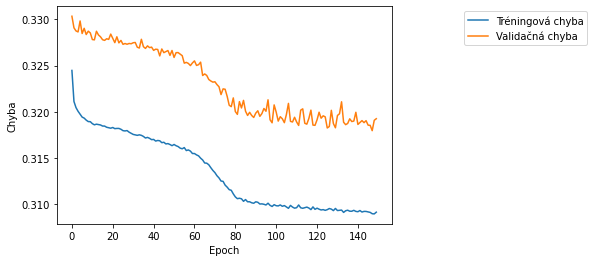

In [161]:
ax = sns.lineplot(data=df, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.6,1))
plt.savefig('best_val.png',   bbox_inches = 'tight')

In [2]:
########################### layers
##################################################
p_weightt = {'activation':[ 'tanh'],
          'optimizer': [Nadam],
          'first_neuron': [64], 
          'second_neuron': [40],   
          'third_neuron': [24],             
          'batch_size': [1024, 2048, 4096],
          'epochs': [500],
          'lr': [0.002],
          'weight_reg': [regularizers.l1(l1 = 0.00001), regularizers.l1(l1 = 0.000005), regularizers.l2(l2 = 0.0002), regularizers.l2(l2 = 0.00005)]
         }

NameError: ignored

In [ ]:
scanned_weight2 = talos.Scan(x_train, N_train, model = deep_weight, params = p_weightt, experiment_name= 'weight_reg_2', x_val = x_test, y_val= N_test)

## Batch norm and dropout


In [116]:
def deep_drop(x_train, N_train, x_test, N_test, params):
  Design = tf.keras.Input(shape=(37,), name = 'Design')
  LogVol = tf.keras.Input(shape=(1,), name = 'LogVol')

  layer1  = layers.Dense(params['first_neuron'], name = 'Layer1')(Design)
  batchnorm = layers.BatchNormalization()(layer1)
  activ = layers.Activation(params['activation'])(batchnorm)
  drop = layers.Dropout(params['dropout'])(activ)
  layer2  = layers.Dense(params['second_neuron'],  name = 'Layer2')(drop)
  batchnorm = layers.BatchNormalization()(layer2)
  activ = layers.Activation(params['activation'])(batchnorm)
  drop = layers.Dropout(params['dropout'])(activ)
  layer3  = layers.Dense(params['third_neuron'],  name = 'Layer3')(drop)
  batchnorm = layers.BatchNormalization()(layer3)
  activ = layers.Activation(params['activation'])(batchnorm)
  drop = layers.Dropout(params['dropout'])(activ)
  Network = layers.Dense(1, activation= 'linear', name = 'Network', 
                          kernel_initializer = tf.keras.initializers.Constant(0.),
                          bias_initializer =
                          tf.keras.initializers.Constant(np.log(lambda_hat_train)))(layer3)
  addition = layers.add([Network, LogVol], name = 'Add')
  response = layers.Dense(1, activation='exponential'
  , name = 'Response', trainable=False, kernel_initializer = tf.keras.initializers.Constant(1.),
  bias_initializer = tf.keras.initializers.Constant(0.))(addition)
  deep = keras.Model(
      inputs = [Design, LogVol],
      outputs = response
  )
  deep.compile(loss = poisson_deviance, optimizer = params['optimizer'](lr = params['lr'])) 

  history = deep.fit(
    x = [x_train, lv_train],
    y = N_train,
    validation_data = ([x_test, lv_test], N_test),
    verbose = 2,
    epochs = params['epochs'],
    batch_size = params['batch_size'])
  return history, deep

In [125]:

p_drop = {'activation':['tanh'],
          'optimizer': [Nadam],
          'first_neuron': [64], 
          'second_neuron': [32],   
          'third_neuron': [16],             
          'batch_size': [512, 1024],
          'epochs': [150],
          'lr': [0.001, 0.004, 0.01],
         'dropout' : [0 ,0.2,0.4]}

In [1]:
scanned_dropout0= talos.Scan(x_train, N_train, model = deep_drop, params = p_drop, experiment_name= 'weight_drop_0', x_val = x_test, y_val= N_test)

NameError: ignored

In [105]:
(scanned_dropout.data.drop(['start', 'end', 'epochs','round_epochs'], axis = 1).sort_values(by = 'val_loss'))

duration      loss  ...  second_neuron third_neuron
5  304.386026  0.304419  ...             40           16
3  304.446854  0.304373  ...             40           16
4  304.014107  0.303726  ...             40           16
7  304.064272  0.307966  ...             40           16
6  304.259697  0.308780  ...             40           16
8  304.263766  0.309091  ...             40           16
2  304.301884  0.293393  ...             40           16
1  301.820810  0.289481  ...             40           16
0  302.457847  0.289281  ...             40           16

[9 rows x 11 columns]

In [106]:
df = pd.DataFrame()
df['loss'] = scanned_dropout.round_history[5]['loss']
df['val_loss'] = scanned_dropout.round_history[5]['val_loss']
df.columns = ['Tréningová chyba', 'Validačná chyba']

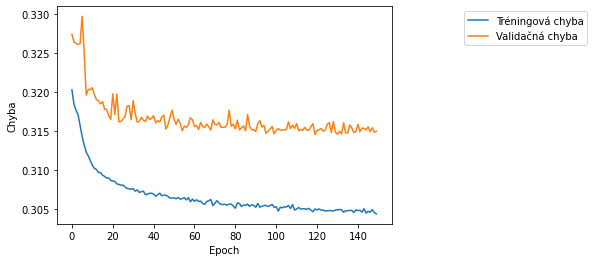

In [107]:
ax = sns.lineplot(data=df, dashes=False)
plt.xlabel('Epoch')
plt.ylabel('Chyba')
ax.legend(bbox_to_anchor = (1.6,1))
plt.savefig('best_val.png',   bbox_inches = 'tight')

In [119]:

p_drop1 = {'activation':['tanh', 'relu'],
          'optimizer': [Nadam],
          'first_neuron': [64, 48], 
          'second_neuron': [40, 32],   
          'third_neuron': [16],             
          'batch_size': [1024, 2048],
          'epochs': [150],
          'lr': [0.001, 0.004, 0.01],
         'dropout' : [0,0.2,0.4]}

In [120]:
scanned_dropout= talos.Scan(x_train, N_train, model = deep_drop, params = p_drop1, experiment_name= 'weight_drop_2', x_val = x_test, y_val= N_test)


















  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 1/150
596/596 - 3s - loss: 0.3198 - val_loss: 0.3273
Epoch 2/150
596/596 - 2s - loss: 0.3173 - val_loss: 0.3261
Epoch 3/150
596/596 - 2s - loss: 0.3163 - val_loss: 0.3264
Epoch 4/150
596/596 - 2s - loss: 0.3154 - val_loss: 0.3257
Epoch 5/150
596/596 - 2s - loss: 0.3142 - val_loss: 0.3254
Epoch 6/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3257
Epoch 7/150
596/596 - 2s - loss: 0.3112 - val_loss: 0.3222
Epoch 8/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3212
Epoch 9/150
596/596 - 2s - loss: 0.3087 - val_loss: 0.3207
Epoch 10/150
596/596 - 2s - loss: 0.3078 - val_loss: 0.3194
Epoch 11/150
596/596 - 2s - loss: 0.3072 - val_loss: 0.3196
Epoch 12/150
596/596 - 2s - loss: 0.3067 - val_loss: 0.3190
Epoch 13/150
596/596 - 2s - loss: 0.3063 - val_loss: 0.3188
Epoch 14/150
596/596 - 2s - loss: 0.3058 - val_loss: 0.3192
Epoch 15/150
596/596 - 2s - loss: 0.3053 - val_loss: 0.3185
Epoch 16/150
596/596 - 2s - loss: 0.3051 - val_loss: 0.3182
Epoch 17/150
596/596 - 2s - loss: 0.3049 - val_lo


















  1%|          | 1/144 [05:07<12:12:30, 307.35s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3197 - val_loss: 0.3281
Epoch 2/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3266
Epoch 3/150
596/596 - 2s - loss: 0.3166 - val_loss: 0.3266
Epoch 4/150
596/596 - 2s - loss: 0.3159 - val_loss: 0.3263
Epoch 5/150
596/596 - 2s - loss: 0.3149 - val_loss: 0.3263
Epoch 6/150
596/596 - 2s - loss: 0.3138 - val_loss: 0.3246
Epoch 7/150
596/596 - 2s - loss: 0.3126 - val_loss: 0.3248
Epoch 8/150
596/596 - 2s - loss: 0.3113 - val_loss: 0.3230
Epoch 9/150
596/596 - 2s - loss: 0.3101 - val_loss: 0.3227
Epoch 10/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3220
Epoch 11/150
596/596 - 2s - loss: 0.3083 - val_loss: 0.3201
Epoch 12/150
596/596 - 2s - loss: 0.3076 - val_loss: 0.3191
Epoch 13/150
596/596 - 2s - loss: 0.3070 - val_loss: 0.3187
Epoch 14/150
596/596 - 2s - loss: 0.3065 - val_loss: 0.3187
Epoch 15/150
596/596 - 2s - loss: 0.3062 - val_loss: 0.3197
Epoch 16/150
596/596 - 2s - loss: 0.3057 - val_loss: 0.3191
Epoch 17/150
596/596 - 2s - loss: 0.3053 - val_lo


















  1%|▏         | 2/144 [10:15<12:07:58, 307.59s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3193 - val_loss: 0.3292
Epoch 2/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3288
Epoch 3/150
596/596 - 2s - loss: 0.3146 - val_loss: 0.3254
Epoch 4/150
596/596 - 2s - loss: 0.3112 - val_loss: 0.3198
Epoch 5/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3191
Epoch 6/150
596/596 - 2s - loss: 0.3082 - val_loss: 0.3180
Epoch 7/150
596/596 - 2s - loss: 0.3073 - val_loss: 0.3185
Epoch 8/150
596/596 - 2s - loss: 0.3067 - val_loss: 0.3201
Epoch 9/150
596/596 - 2s - loss: 0.3060 - val_loss: 0.3236
Epoch 10/150
596/596 - 2s - loss: 0.3054 - val_loss: 0.3179
Epoch 11/150
596/596 - 2s - loss: 0.3050 - val_loss: 0.3186
Epoch 12/150
596/596 - 2s - loss: 0.3045 - val_loss: 0.3168
Epoch 13/150
596/596 - 2s - loss: 0.3040 - val_loss: 0.3178
Epoch 14/150
596/596 - 2s - loss: 0.3036 - val_loss: 0.3182
Epoch 15/150
596/596 - 2s - loss: 0.3033 - val_loss: 0.3175
Epoch 16/150
596/596 - 2s - loss: 0.3026 - val_loss: 0.3181
Epoch 17/150
596/596 - 2s - loss: 0.3025 - val_lo


















  2%|▏         | 3/144 [15:23<12:03:15, 307.77s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3194 - val_loss: 0.3273
Epoch 2/150
596/596 - 2s - loss: 0.3171 - val_loss: 0.3270
Epoch 3/150
596/596 - 2s - loss: 0.3147 - val_loss: 0.3235
Epoch 4/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3263
Epoch 5/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3205
Epoch 6/150
596/596 - 2s - loss: 0.3082 - val_loss: 0.3192
Epoch 7/150
596/596 - 2s - loss: 0.3073 - val_loss: 0.3188
Epoch 8/150
596/596 - 2s - loss: 0.3066 - val_loss: 0.3179
Epoch 9/150
596/596 - 2s - loss: 0.3060 - val_loss: 0.3183
Epoch 10/150
596/596 - 2s - loss: 0.3056 - val_loss: 0.3206
Epoch 11/150
596/596 - 2s - loss: 0.3050 - val_loss: 0.3173
Epoch 12/150
596/596 - 2s - loss: 0.3046 - val_loss: 0.3173
Epoch 13/150
596/596 - 2s - loss: 0.3042 - val_loss: 0.3185
Epoch 14/150
596/596 - 2s - loss: 0.3037 - val_loss: 0.3184
Epoch 15/150
596/596 - 2s - loss: 0.3034 - val_loss: 0.3181
Epoch 16/150
596/596 - 2s - loss: 0.3031 - val_loss: 0.3190
Epoch 17/150
596/596 - 2s - loss: 0.3029 - val_lo


















  3%|▎         | 4/144 [20:31<11:58:23, 307.88s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3196 - val_loss: 0.3292
Epoch 2/150
596/596 - 2s - loss: 0.3173 - val_loss: 0.3272
Epoch 3/150
596/596 - 2s - loss: 0.3149 - val_loss: 0.3237
Epoch 4/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3240
Epoch 5/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3190
Epoch 6/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3193
Epoch 7/150
596/596 - 2s - loss: 0.3074 - val_loss: 0.3176
Epoch 8/150
596/596 - 2s - loss: 0.3067 - val_loss: 0.3185
Epoch 9/150
596/596 - 2s - loss: 0.3061 - val_loss: 0.3171
Epoch 10/150
596/596 - 2s - loss: 0.3055 - val_loss: 0.3171
Epoch 11/150
596/596 - 2s - loss: 0.3051 - val_loss: 0.3173
Epoch 12/150
596/596 - 2s - loss: 0.3047 - val_loss: 0.3176
Epoch 13/150
596/596 - 2s - loss: 0.3043 - val_loss: 0.3184
Epoch 14/150
596/596 - 2s - loss: 0.3039 - val_loss: 0.3191
Epoch 15/150
596/596 - 2s - loss: 0.3036 - val_loss: 0.3203
Epoch 16/150
596/596 - 2s - loss: 0.3034 - val_loss: 0.3194
Epoch 17/150
596/596 - 2s - loss: 0.3031 - val_lo


















  3%|▎         | 5/144 [25:40<11:53:32, 308.00s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3195 - val_loss: 0.3290
Epoch 2/150
596/596 - 2s - loss: 0.3168 - val_loss: 0.3322
Epoch 3/150
596/596 - 2s - loss: 0.3134 - val_loss: 0.3399
Epoch 4/150
596/596 - 2s - loss: 0.3106 - val_loss: 0.3222
Epoch 5/150
596/596 - 2s - loss: 0.3089 - val_loss: 0.3208
Epoch 6/150
596/596 - 2s - loss: 0.3079 - val_loss: 0.3195
Epoch 7/150
596/596 - 2s - loss: 0.3070 - val_loss: 0.3194
Epoch 8/150
596/596 - 2s - loss: 0.3065 - val_loss: 0.3176
Epoch 9/150
596/596 - 2s - loss: 0.3060 - val_loss: 0.3177
Epoch 10/150
596/596 - 2s - loss: 0.3056 - val_loss: 0.3209
Epoch 11/150
596/596 - 2s - loss: 0.3052 - val_loss: 0.3176
Epoch 12/150
596/596 - 2s - loss: 0.3049 - val_loss: 0.3195
Epoch 13/150
596/596 - 2s - loss: 0.3046 - val_loss: 0.3176
Epoch 14/150
596/596 - 2s - loss: 0.3042 - val_loss: 0.3178
Epoch 15/150
596/596 - 2s - loss: 0.3038 - val_loss: 0.3167
Epoch 16/150
596/596 - 2s - loss: 0.3037 - val_loss: 0.3167
Epoch 17/150
596/596 - 2s - loss: 0.3034 - val_lo


















  4%|▍         | 6/144 [30:47<11:48:06, 307.87s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3199 - val_loss: 0.3276
Epoch 2/150
596/596 - 2s - loss: 0.3175 - val_loss: 0.3273
Epoch 3/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3265
Epoch 4/150
596/596 - 2s - loss: 0.3160 - val_loss: 0.3257
Epoch 5/150
596/596 - 2s - loss: 0.3151 - val_loss: 0.3253
Epoch 6/150
596/596 - 2s - loss: 0.3141 - val_loss: 0.3250
Epoch 7/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3243
Epoch 8/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3260
Epoch 9/150
596/596 - 2s - loss: 0.3101 - val_loss: 0.3221
Epoch 10/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3210
Epoch 11/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3210
Epoch 12/150
596/596 - 2s - loss: 0.3078 - val_loss: 0.3197
Epoch 13/150
596/596 - 2s - loss: 0.3072 - val_loss: 0.3198
Epoch 14/150
596/596 - 2s - loss: 0.3070 - val_loss: 0.3193
Epoch 15/150
596/596 - 2s - loss: 0.3067 - val_loss: 0.3200
Epoch 16/150
596/596 - 2s - loss: 0.3064 - val_loss: 0.3196
Epoch 17/150
596/596 - 2s - loss: 0.3061 - val_lo


















  5%|▍         | 7/144 [35:55<11:43:14, 307.99s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3202 - val_loss: 0.3271
Epoch 2/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3268
Epoch 3/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3272
Epoch 4/150
596/596 - 2s - loss: 0.3160 - val_loss: 0.3257
Epoch 5/150
596/596 - 2s - loss: 0.3150 - val_loss: 0.3250
Epoch 6/150
596/596 - 2s - loss: 0.3139 - val_loss: 0.3261
Epoch 7/150
596/596 - 2s - loss: 0.3126 - val_loss: 0.3229
Epoch 8/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3231
Epoch 9/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3217
Epoch 10/150
596/596 - 2s - loss: 0.3093 - val_loss: 0.3212
Epoch 11/150
596/596 - 2s - loss: 0.3086 - val_loss: 0.3198
Epoch 12/150
596/596 - 2s - loss: 0.3079 - val_loss: 0.3199
Epoch 13/150
596/596 - 2s - loss: 0.3074 - val_loss: 0.3197
Epoch 14/150
596/596 - 2s - loss: 0.3071 - val_loss: 0.3191
Epoch 15/150
596/596 - 2s - loss: 0.3064 - val_loss: 0.3193
Epoch 16/150
596/596 - 2s - loss: 0.3061 - val_loss: 0.3180
Epoch 17/150
596/596 - 2s - loss: 0.3058 - val_lo


















  6%|▌         | 8/144 [41:04<11:38:42, 308.25s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3195 - val_loss: 0.3283
Epoch 2/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3290
Epoch 3/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3261
Epoch 4/150
596/596 - 2s - loss: 0.3142 - val_loss: 0.3249
Epoch 5/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3274
Epoch 6/150
596/596 - 2s - loss: 0.3098 - val_loss: 0.3183
Epoch 7/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3185
Epoch 8/150
596/596 - 2s - loss: 0.3074 - val_loss: 0.3196
Epoch 9/150
596/596 - 2s - loss: 0.3069 - val_loss: 0.3203
Epoch 10/150
596/596 - 2s - loss: 0.3063 - val_loss: 0.3244
Epoch 11/150
596/596 - 2s - loss: 0.3058 - val_loss: 0.3185
Epoch 12/150
596/596 - 2s - loss: 0.3057 - val_loss: 0.3180
Epoch 13/150
596/596 - 2s - loss: 0.3051 - val_loss: 0.3182
Epoch 14/150
596/596 - 2s - loss: 0.3048 - val_loss: 0.3174
Epoch 15/150
596/596 - 2s - loss: 0.3046 - val_loss: 0.3207
Epoch 16/150
596/596 - 2s - loss: 0.3043 - val_loss: 0.3184
Epoch 17/150
596/596 - 2s - loss: 0.3040 - val_lo


















  6%|▋         | 9/144 [46:14<11:34:26, 308.64s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3194 - val_loss: 0.3274
Epoch 2/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3275
Epoch 3/150
596/596 - 2s - loss: 0.3158 - val_loss: 0.3260
Epoch 4/150
596/596 - 2s - loss: 0.3134 - val_loss: 0.3267
Epoch 5/150
596/596 - 2s - loss: 0.3110 - val_loss: 0.3225
Epoch 6/150
596/596 - 2s - loss: 0.3095 - val_loss: 0.3196
Epoch 7/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3194
Epoch 8/150
596/596 - 2s - loss: 0.3077 - val_loss: 0.3185
Epoch 9/150
596/596 - 2s - loss: 0.3071 - val_loss: 0.3181
Epoch 10/150
596/596 - 2s - loss: 0.3068 - val_loss: 0.3177
Epoch 11/150
596/596 - 2s - loss: 0.3061 - val_loss: 0.3174
Epoch 12/150
596/596 - 2s - loss: 0.3057 - val_loss: 0.3180
Epoch 13/150
596/596 - 2s - loss: 0.3054 - val_loss: 0.3180
Epoch 14/150
596/596 - 2s - loss: 0.3048 - val_loss: 0.3184
Epoch 15/150
596/596 - 2s - loss: 0.3046 - val_loss: 0.3189
Epoch 16/150
596/596 - 2s - loss: 0.3043 - val_loss: 0.3168
Epoch 17/150
596/596 - 2s - loss: 0.3039 - val_lo


















  7%|▋         | 10/144 [51:25<11:30:56, 309.38s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3197 - val_loss: 0.3292
Epoch 2/150
596/596 - 2s - loss: 0.3170 - val_loss: 0.3349
Epoch 3/150
596/596 - 2s - loss: 0.3138 - val_loss: 0.3534
Epoch 4/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3222
Epoch 5/150
596/596 - 2s - loss: 0.3092 - val_loss: 0.3192
Epoch 6/150
596/596 - 2s - loss: 0.3080 - val_loss: 0.3244
Epoch 7/150
596/596 - 2s - loss: 0.3074 - val_loss: 0.3183
Epoch 8/150
596/596 - 2s - loss: 0.3068 - val_loss: 0.3187
Epoch 9/150
596/596 - 2s - loss: 0.3064 - val_loss: 0.3180
Epoch 10/150
596/596 - 2s - loss: 0.3061 - val_loss: 0.3176
Epoch 11/150
596/596 - 2s - loss: 0.3058 - val_loss: 0.3181
Epoch 12/150
596/596 - 2s - loss: 0.3056 - val_loss: 0.3183
Epoch 13/150
596/596 - 2s - loss: 0.3054 - val_loss: 0.3168
Epoch 14/150
596/596 - 2s - loss: 0.3050 - val_loss: 0.3170
Epoch 15/150
596/596 - 2s - loss: 0.3048 - val_loss: 0.3166
Epoch 16/150
596/596 - 2s - loss: 0.3046 - val_loss: 0.3161
Epoch 17/150
596/596 - 2s - loss: 0.3043 - val_lo


















  8%|▊         | 11/144 [56:34<11:25:23, 309.20s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3197 - val_loss: 0.3273
Epoch 2/150
596/596 - 2s - loss: 0.3168 - val_loss: 0.3285
Epoch 3/150
596/596 - 2s - loss: 0.3129 - val_loss: 0.3313
Epoch 4/150
596/596 - 2s - loss: 0.3099 - val_loss: 0.3199
Epoch 5/150
596/596 - 2s - loss: 0.3087 - val_loss: 0.3201
Epoch 6/150
596/596 - 2s - loss: 0.3079 - val_loss: 0.3190
Epoch 7/150
596/596 - 2s - loss: 0.3072 - val_loss: 0.3165
Epoch 8/150
596/596 - 2s - loss: 0.3067 - val_loss: 0.3168
Epoch 9/150
596/596 - 2s - loss: 0.3062 - val_loss: 0.3200
Epoch 10/150
596/596 - 2s - loss: 0.3058 - val_loss: 0.3247
Epoch 11/150
596/596 - 2s - loss: 0.3054 - val_loss: 0.3176
Epoch 12/150
596/596 - 2s - loss: 0.3053 - val_loss: 0.3164
Epoch 13/150
596/596 - 2s - loss: 0.3047 - val_loss: 0.3164
Epoch 14/150
596/596 - 2s - loss: 0.3045 - val_loss: 0.3166
Epoch 15/150
596/596 - 2s - loss: 0.3044 - val_loss: 0.3167
Epoch 16/150
596/596 - 2s - loss: 0.3041 - val_loss: 0.3222
Epoch 17/150
596/596 - 2s - loss: 0.3039 - val_lo


















  8%|▊         | 12/144 [1:01:43<11:20:33, 309.35s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3210 - val_loss: 0.3273
Epoch 2/150
596/596 - 2s - loss: 0.3190 - val_loss: 0.3274
Epoch 3/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3267
Epoch 4/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3269
Epoch 5/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3266
Epoch 6/150
596/596 - 2s - loss: 0.3175 - val_loss: 0.3266
Epoch 7/150
596/596 - 2s - loss: 0.3173 - val_loss: 0.3263
Epoch 8/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3257
Epoch 9/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3251
Epoch 10/150
596/596 - 2s - loss: 0.3162 - val_loss: 0.3247
Epoch 11/150
596/596 - 2s - loss: 0.3155 - val_loss: 0.3240
Epoch 12/150
596/596 - 2s - loss: 0.3149 - val_loss: 0.3226
Epoch 13/150
596/596 - 2s - loss: 0.3143 - val_loss: 0.3223
Epoch 14/150
596/596 - 2s - loss: 0.3137 - val_loss: 0.3212
Epoch 15/150
596/596 - 2s - loss: 0.3134 - val_loss: 0.3212
Epoch 16/150
596/596 - 2s - loss: 0.3125 - val_loss: 0.3201
Epoch 17/150
596/596 - 2s - loss: 0.3123 - val_lo


















  9%|▉         | 13/144 [1:06:55<11:16:51, 310.01s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3211 - val_loss: 0.3282
Epoch 2/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3274
Epoch 3/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3274
Epoch 4/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3270
Epoch 5/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3271
Epoch 6/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3265
Epoch 7/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3266
Epoch 8/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3268
Epoch 9/150
596/596 - 2s - loss: 0.3170 - val_loss: 0.3260
Epoch 10/150
596/596 - 2s - loss: 0.3166 - val_loss: 0.3254
Epoch 11/150
596/596 - 2s - loss: 0.3163 - val_loss: 0.3250
Epoch 12/150
596/596 - 2s - loss: 0.3160 - val_loss: 0.3246
Epoch 13/150
596/596 - 2s - loss: 0.3152 - val_loss: 0.3239
Epoch 14/150
596/596 - 2s - loss: 0.3149 - val_loss: 0.3230
Epoch 15/150
596/596 - 2s - loss: 0.3144 - val_loss: 0.3232
Epoch 16/150
596/596 - 2s - loss: 0.3137 - val_loss: 0.3219
Epoch 17/150
596/596 - 2s - loss: 0.3131 - val_lo


















 10%|▉         | 14/144 [1:12:05<11:11:49, 310.07s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3203 - val_loss: 0.3279
Epoch 2/150
596/596 - 2s - loss: 0.3185 - val_loss: 0.3273
Epoch 3/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3265
Epoch 4/150
596/596 - 2s - loss: 0.3173 - val_loss: 0.3262
Epoch 5/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3260
Epoch 6/150
596/596 - 2s - loss: 0.3164 - val_loss: 0.3253
Epoch 7/150
596/596 - 2s - loss: 0.3154 - val_loss: 0.3240
Epoch 8/150
596/596 - 2s - loss: 0.3144 - val_loss: 0.3231
Epoch 9/150
596/596 - 2s - loss: 0.3133 - val_loss: 0.3212
Epoch 10/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3198
Epoch 11/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3213
Epoch 12/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3190
Epoch 13/150
596/596 - 2s - loss: 0.3105 - val_loss: 0.3192
Epoch 14/150
596/596 - 2s - loss: 0.3100 - val_loss: 0.3178
Epoch 15/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3172
Epoch 16/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3180
Epoch 17/150
596/596 - 2s - loss: 0.3093 - val_lo


















 10%|█         | 15/144 [1:17:17<11:07:42, 310.56s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3204 - val_loss: 0.3284
Epoch 2/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3289
Epoch 3/150
596/596 - 2s - loss: 0.3180 - val_loss: 0.3274
Epoch 4/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3270
Epoch 5/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3260
Epoch 6/150
596/596 - 2s - loss: 0.3164 - val_loss: 0.3247
Epoch 7/150
596/596 - 2s - loss: 0.3153 - val_loss: 0.3229
Epoch 8/150
596/596 - 2s - loss: 0.3143 - val_loss: 0.3224
Epoch 9/150
596/596 - 2s - loss: 0.3135 - val_loss: 0.3229
Epoch 10/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3216
Epoch 11/150
596/596 - 2s - loss: 0.3120 - val_loss: 0.3197
Epoch 12/150
596/596 - 2s - loss: 0.3110 - val_loss: 0.3192
Epoch 13/150
596/596 - 2s - loss: 0.3110 - val_loss: 0.3176
Epoch 14/150
596/596 - 2s - loss: 0.3105 - val_loss: 0.3188
Epoch 15/150
596/596 - 2s - loss: 0.3099 - val_loss: 0.3175
Epoch 16/150
596/596 - 2s - loss: 0.3099 - val_loss: 0.3193
Epoch 17/150
596/596 - 2s - loss: 0.3096 - val_lo


















 11%|█         | 16/144 [1:22:29<11:03:24, 310.97s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3204 - val_loss: 0.3281
Epoch 2/150
596/596 - 2s - loss: 0.3185 - val_loss: 0.3288
Epoch 3/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3265
Epoch 4/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3271
Epoch 5/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3272
Epoch 6/150
596/596 - 2s - loss: 0.3154 - val_loss: 0.3280
Epoch 7/150
596/596 - 2s - loss: 0.3135 - val_loss: 0.3250
Epoch 8/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3208
Epoch 9/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3197
Epoch 10/150
596/596 - 2s - loss: 0.3111 - val_loss: 0.3200
Epoch 11/150
596/596 - 2s - loss: 0.3105 - val_loss: 0.3191
Epoch 12/150
596/596 - 2s - loss: 0.3105 - val_loss: 0.3191
Epoch 13/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3172
Epoch 14/150
596/596 - 2s - loss: 0.3098 - val_loss: 0.3177
Epoch 15/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3186
Epoch 16/150
596/596 - 2s - loss: 0.3095 - val_loss: 0.3189
Epoch 17/150
596/596 - 2s - loss: 0.3094 - val_lo


















 12%|█▏        | 17/144 [1:27:40<10:58:13, 310.97s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3202 - val_loss: 0.3285
Epoch 2/150
596/596 - 2s - loss: 0.3188 - val_loss: 0.3272
Epoch 3/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3280
Epoch 4/150
596/596 - 2s - loss: 0.3173 - val_loss: 0.3254
Epoch 5/150
596/596 - 2s - loss: 0.3163 - val_loss: 0.3250
Epoch 6/150
596/596 - 2s - loss: 0.3153 - val_loss: 0.3241
Epoch 7/150
596/596 - 2s - loss: 0.3138 - val_loss: 0.3227
Epoch 8/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3216
Epoch 9/150
596/596 - 2s - loss: 0.3116 - val_loss: 0.3204
Epoch 10/150
596/596 - 2s - loss: 0.3111 - val_loss: 0.3196
Epoch 11/150
596/596 - 2s - loss: 0.3108 - val_loss: 0.3200
Epoch 12/150
596/596 - 2s - loss: 0.3104 - val_loss: 0.3181
Epoch 13/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3191
Epoch 14/150
596/596 - 2s - loss: 0.3100 - val_loss: 0.3176
Epoch 15/150
596/596 - 2s - loss: 0.3093 - val_loss: 0.3181
Epoch 16/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3241
Epoch 17/150
596/596 - 2s - loss: 0.3096 - val_lo


















 12%|█▎        | 18/144 [1:32:50<10:52:22, 310.66s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3217 - val_loss: 0.3280
Epoch 2/150
596/596 - 2s - loss: 0.3193 - val_loss: 0.3276
Epoch 3/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3277
Epoch 4/150
596/596 - 2s - loss: 0.3185 - val_loss: 0.3269
Epoch 5/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3270
Epoch 6/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3267
Epoch 7/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3264
Epoch 8/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3262
Epoch 9/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3259
Epoch 10/150
596/596 - 2s - loss: 0.3170 - val_loss: 0.3259
Epoch 11/150
596/596 - 2s - loss: 0.3168 - val_loss: 0.3258
Epoch 12/150
596/596 - 2s - loss: 0.3164 - val_loss: 0.3253
Epoch 13/150
596/596 - 2s - loss: 0.3160 - val_loss: 0.3254
Epoch 14/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3240
Epoch 15/150
596/596 - 2s - loss: 0.3151 - val_loss: 0.3238
Epoch 16/150
596/596 - 2s - loss: 0.3147 - val_loss: 0.3231
Epoch 17/150
596/596 - 2s - loss: 0.3140 - val_lo


















 13%|█▎        | 19/144 [1:38:04<10:49:10, 311.61s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3217 - val_loss: 0.3277
Epoch 2/150
596/596 - 2s - loss: 0.3194 - val_loss: 0.3274
Epoch 3/150
596/596 - 2s - loss: 0.3188 - val_loss: 0.3271
Epoch 4/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3267
Epoch 5/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3265
Epoch 6/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3262
Epoch 7/150
596/596 - 2s - loss: 0.3175 - val_loss: 0.3262
Epoch 8/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3264
Epoch 9/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3261
Epoch 10/150
596/596 - 2s - loss: 0.3170 - val_loss: 0.3261
Epoch 11/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3258
Epoch 12/150
596/596 - 2s - loss: 0.3165 - val_loss: 0.3256
Epoch 13/150
596/596 - 2s - loss: 0.3165 - val_loss: 0.3249
Epoch 14/150
596/596 - 2s - loss: 0.3163 - val_loss: 0.3246
Epoch 15/150
596/596 - 2s - loss: 0.3157 - val_loss: 0.3245
Epoch 16/150
596/596 - 2s - loss: 0.3154 - val_loss: 0.3242
Epoch 17/150
596/596 - 2s - loss: 0.3152 - val_lo


















 14%|█▍        | 20/144 [1:43:15<10:43:46, 311.50s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3204 - val_loss: 0.3281
Epoch 2/150
596/596 - 2s - loss: 0.3189 - val_loss: 0.3283
Epoch 3/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3271
Epoch 4/150
596/596 - 2s - loss: 0.3175 - val_loss: 0.3263
Epoch 5/150
596/596 - 2s - loss: 0.3168 - val_loss: 0.3255
Epoch 6/150
596/596 - 2s - loss: 0.3157 - val_loss: 0.3243
Epoch 7/150
596/596 - 2s - loss: 0.3146 - val_loss: 0.3230
Epoch 8/150
596/596 - 2s - loss: 0.3137 - val_loss: 0.3234
Epoch 9/150
596/596 - 2s - loss: 0.3129 - val_loss: 0.3216
Epoch 10/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3190
Epoch 11/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.3197
Epoch 12/150
596/596 - 2s - loss: 0.3111 - val_loss: 0.3186
Epoch 13/150
596/596 - 2s - loss: 0.3106 - val_loss: 0.3194
Epoch 14/150
596/596 - 2s - loss: 0.3103 - val_loss: 0.3179
Epoch 15/150
596/596 - 2s - loss: 0.3100 - val_loss: 0.3178
Epoch 16/150
596/596 - 2s - loss: 0.3100 - val_loss: 0.3182
Epoch 17/150
596/596 - 2s - loss: 0.3097 - val_lo


















 15%|█▍        | 21/144 [1:48:26<10:38:35, 311.51s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3205 - val_loss: 0.3278
Epoch 2/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3271
Epoch 3/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3265
Epoch 4/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3280
Epoch 5/150
596/596 - 2s - loss: 0.3170 - val_loss: 0.3257
Epoch 6/150
596/596 - 2s - loss: 0.3164 - val_loss: 0.3245
Epoch 7/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3240
Epoch 8/150
596/596 - 2s - loss: 0.3144 - val_loss: 0.3237
Epoch 9/150
596/596 - 2s - loss: 0.3135 - val_loss: 0.3209
Epoch 10/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3203
Epoch 11/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3206
Epoch 12/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3191
Epoch 13/150
596/596 - 2s - loss: 0.3112 - val_loss: 0.3220
Epoch 14/150
596/596 - 2s - loss: 0.3108 - val_loss: 0.3194
Epoch 15/150
596/596 - 2s - loss: 0.3107 - val_loss: 0.3181
Epoch 16/150
596/596 - 2s - loss: 0.3105 - val_loss: 0.3195
Epoch 17/150
596/596 - 2s - loss: 0.3101 - val_lo


















 15%|█▌        | 22/144 [1:53:36<10:32:27, 311.05s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3203 - val_loss: 0.3275
Epoch 2/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3270
Epoch 3/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3260
Epoch 4/150
596/596 - 2s - loss: 0.3168 - val_loss: 0.3249
Epoch 5/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3275
Epoch 6/150
596/596 - 2s - loss: 0.3146 - val_loss: 0.3221
Epoch 7/150
596/596 - 2s - loss: 0.3133 - val_loss: 0.3253
Epoch 8/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3227
Epoch 9/150
596/596 - 2s - loss: 0.3121 - val_loss: 0.3200
Epoch 10/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3181
Epoch 11/150
596/596 - 2s - loss: 0.3113 - val_loss: 0.3215
Epoch 12/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3191
Epoch 13/150
596/596 - 2s - loss: 0.3105 - val_loss: 0.3194
Epoch 14/150
596/596 - 2s - loss: 0.3107 - val_loss: 0.3187
Epoch 15/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3182
Epoch 16/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3188
Epoch 17/150
596/596 - 2s - loss: 0.3097 - val_lo


















 16%|█▌        | 23/144 [1:58:47<10:27:03, 310.94s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3206 - val_loss: 0.3304
Epoch 2/150
596/596 - 2s - loss: 0.3188 - val_loss: 0.3268
Epoch 3/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3280
Epoch 4/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3260
Epoch 5/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3261
Epoch 6/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3252
Epoch 7/150
596/596 - 2s - loss: 0.3141 - val_loss: 0.3221
Epoch 8/150
596/596 - 2s - loss: 0.3133 - val_loss: 0.3223
Epoch 9/150
596/596 - 2s - loss: 0.3125 - val_loss: 0.3225
Epoch 10/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.3204
Epoch 11/150
596/596 - 2s - loss: 0.3116 - val_loss: 0.3192
Epoch 12/150
596/596 - 2s - loss: 0.3112 - val_loss: 0.3193
Epoch 13/150
596/596 - 2s - loss: 0.3110 - val_loss: 0.3187
Epoch 14/150
596/596 - 2s - loss: 0.3107 - val_loss: 0.3201
Epoch 15/150
596/596 - 2s - loss: 0.3105 - val_loss: 0.3201
Epoch 16/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3196
Epoch 17/150
596/596 - 2s - loss: 0.3102 - val_lo


















 17%|█▋        | 24/144 [2:03:59<10:22:15, 311.13s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3226 - val_loss: 0.3279
Epoch 2/150
596/596 - 2s - loss: 0.3201 - val_loss: 0.3278
Epoch 3/150
596/596 - 2s - loss: 0.3195 - val_loss: 0.3276
Epoch 4/150
596/596 - 2s - loss: 0.3193 - val_loss: 0.3274
Epoch 5/150
596/596 - 2s - loss: 0.3189 - val_loss: 0.3272
Epoch 6/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3272
Epoch 7/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3272
Epoch 8/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3269
Epoch 9/150
596/596 - 2s - loss: 0.3184 - val_loss: 0.3267
Epoch 10/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3268
Epoch 11/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3265
Epoch 12/150
596/596 - 2s - loss: 0.3180 - val_loss: 0.3264
Epoch 13/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3263
Epoch 14/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3267
Epoch 15/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3262
Epoch 16/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3258
Epoch 17/150
596/596 - 2s - loss: 0.3173 - val_lo


















 17%|█▋        | 25/144 [2:09:10<10:17:23, 311.29s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3225 - val_loss: 0.3283
Epoch 2/150
596/596 - 2s - loss: 0.3200 - val_loss: 0.3280
Epoch 3/150
596/596 - 2s - loss: 0.3197 - val_loss: 0.3278
Epoch 4/150
596/596 - 2s - loss: 0.3192 - val_loss: 0.3276
Epoch 5/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3273
Epoch 6/150
596/596 - 2s - loss: 0.3188 - val_loss: 0.3273
Epoch 7/150
596/596 - 2s - loss: 0.3188 - val_loss: 0.3271
Epoch 8/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3267
Epoch 9/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3266
Epoch 10/150
596/596 - 2s - loss: 0.3184 - val_loss: 0.3266
Epoch 11/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3264
Epoch 12/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3263
Epoch 13/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3263
Epoch 14/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3261
Epoch 15/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3261
Epoch 16/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3259
Epoch 17/150
596/596 - 2s - loss: 0.3173 - val_lo


















 18%|█▊        | 26/144 [2:14:22<10:12:23, 311.38s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3214 - val_loss: 0.3284
Epoch 2/150
596/596 - 2s - loss: 0.3195 - val_loss: 0.3281
Epoch 3/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3277
Epoch 4/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3267
Epoch 5/150
596/596 - 2s - loss: 0.3185 - val_loss: 0.3264
Epoch 6/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3264
Epoch 7/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3257
Epoch 8/150
596/596 - 2s - loss: 0.3171 - val_loss: 0.3252
Epoch 9/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3249
Epoch 10/150
596/596 - 2s - loss: 0.3166 - val_loss: 0.3243
Epoch 11/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3241
Epoch 12/150
596/596 - 2s - loss: 0.3159 - val_loss: 0.3234
Epoch 13/150
596/596 - 2s - loss: 0.3153 - val_loss: 0.3231
Epoch 14/150
596/596 - 2s - loss: 0.3149 - val_loss: 0.3215
Epoch 15/150
596/596 - 2s - loss: 0.3146 - val_loss: 0.3213
Epoch 16/150
596/596 - 2s - loss: 0.3138 - val_loss: 0.3229
Epoch 17/150
596/596 - 2s - loss: 0.3139 - val_lo


















 19%|█▉        | 27/144 [2:19:35<10:08:29, 312.04s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3213 - val_loss: 0.3281
Epoch 2/150
596/596 - 2s - loss: 0.3196 - val_loss: 0.3284
Epoch 3/150
596/596 - 2s - loss: 0.3190 - val_loss: 0.3274
Epoch 4/150
596/596 - 2s - loss: 0.3189 - val_loss: 0.3270
Epoch 5/150
596/596 - 2s - loss: 0.3184 - val_loss: 0.3270
Epoch 6/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3266
Epoch 7/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3262
Epoch 8/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3256
Epoch 9/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3257
Epoch 10/150
596/596 - 2s - loss: 0.3168 - val_loss: 0.3247
Epoch 11/150
596/596 - 2s - loss: 0.3164 - val_loss: 0.3240
Epoch 12/150
596/596 - 2s - loss: 0.3159 - val_loss: 0.3239
Epoch 13/150
596/596 - 2s - loss: 0.3155 - val_loss: 0.3247
Epoch 14/150
596/596 - 2s - loss: 0.3155 - val_loss: 0.3234
Epoch 15/150
596/596 - 2s - loss: 0.3152 - val_loss: 0.3228
Epoch 16/150
596/596 - 2s - loss: 0.3146 - val_loss: 0.3220
Epoch 17/150
596/596 - 2s - loss: 0.3141 - val_lo


















 19%|█▉        | 28/144 [2:24:48<10:03:43, 312.27s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3214 - val_loss: 0.3284
Epoch 2/150
596/596 - 2s - loss: 0.3195 - val_loss: 0.3286
Epoch 3/150
596/596 - 2s - loss: 0.3189 - val_loss: 0.3276
Epoch 4/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3265
Epoch 5/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3261
Epoch 6/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3264
Epoch 7/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3255
Epoch 8/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3255
Epoch 9/150
596/596 - 2s - loss: 0.3165 - val_loss: 0.3259
Epoch 10/150
596/596 - 2s - loss: 0.3159 - val_loss: 0.3240
Epoch 11/150
596/596 - 2s - loss: 0.3158 - val_loss: 0.3241
Epoch 12/150
596/596 - 2s - loss: 0.3153 - val_loss: 0.3241
Epoch 13/150
596/596 - 2s - loss: 0.3148 - val_loss: 0.3218
Epoch 14/150
596/596 - 2s - loss: 0.3144 - val_loss: 0.3220
Epoch 15/150
596/596 - 2s - loss: 0.3142 - val_loss: 0.3212
Epoch 16/150
596/596 - 2s - loss: 0.3138 - val_loss: 0.3209
Epoch 17/150
596/596 - 2s - loss: 0.3138 - val_lo


















 20%|██        | 29/144 [2:29:59<9:57:55, 311.96s/it] 

Epoch 1/150
596/596 - 3s - loss: 0.3214 - val_loss: 0.3282
Epoch 2/150
596/596 - 2s - loss: 0.3194 - val_loss: 0.3280
Epoch 3/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3270
Epoch 4/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3263
Epoch 5/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3274
Epoch 6/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3266
Epoch 7/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3249
Epoch 8/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3243
Epoch 9/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3246
Epoch 10/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3235
Epoch 11/150
596/596 - 2s - loss: 0.3154 - val_loss: 0.3246
Epoch 12/150
596/596 - 2s - loss: 0.3150 - val_loss: 0.3225
Epoch 13/150
596/596 - 2s - loss: 0.3148 - val_loss: 0.3224
Epoch 14/150
596/596 - 2s - loss: 0.3144 - val_loss: 0.3215
Epoch 15/150
596/596 - 2s - loss: 0.3142 - val_loss: 0.3215
Epoch 16/150
596/596 - 2s - loss: 0.3139 - val_loss: 0.3208
Epoch 17/150
596/596 - 2s - loss: 0.3138 - val_lo


















 21%|██        | 30/144 [2:35:13<9:53:26, 312.34s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3229 - val_loss: 0.3279
Epoch 2/150
596/596 - 2s - loss: 0.3201 - val_loss: 0.3276
Epoch 3/150
596/596 - 2s - loss: 0.3198 - val_loss: 0.3275
Epoch 4/150
596/596 - 2s - loss: 0.3193 - val_loss: 0.3276
Epoch 5/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3270
Epoch 6/150
596/596 - 2s - loss: 0.3189 - val_loss: 0.3271
Epoch 7/150
596/596 - 2s - loss: 0.3188 - val_loss: 0.3271
Epoch 8/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3267
Epoch 9/150
596/596 - 2s - loss: 0.3185 - val_loss: 0.3269
Epoch 10/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3266
Epoch 11/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3263
Epoch 12/150
596/596 - 2s - loss: 0.3180 - val_loss: 0.3262
Epoch 13/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3259
Epoch 14/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3259
Epoch 15/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3259
Epoch 16/150
596/596 - 2s - loss: 0.3175 - val_loss: 0.3258
Epoch 17/150
596/596 - 2s - loss: 0.3172 - val_lo


















 22%|██▏       | 31/144 [2:40:25<9:48:07, 312.27s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3234 - val_loss: 0.3287
Epoch 2/150
596/596 - 2s - loss: 0.3202 - val_loss: 0.3282
Epoch 3/150
596/596 - 2s - loss: 0.3198 - val_loss: 0.3278
Epoch 4/150
596/596 - 2s - loss: 0.3194 - val_loss: 0.3275
Epoch 5/150
596/596 - 2s - loss: 0.3194 - val_loss: 0.3275
Epoch 6/150
596/596 - 2s - loss: 0.3190 - val_loss: 0.3273
Epoch 7/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3272
Epoch 8/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3272
Epoch 9/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3269
Epoch 10/150
596/596 - 2s - loss: 0.3185 - val_loss: 0.3269
Epoch 11/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3265
Epoch 12/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3268
Epoch 13/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3264
Epoch 14/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3262
Epoch 15/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3259
Epoch 16/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3258
Epoch 17/150
596/596 - 2s - loss: 0.3176 - val_lo


















 22%|██▏       | 32/144 [2:45:37<9:42:43, 312.17s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3216 - val_loss: 0.3284
Epoch 2/150
596/596 - 2s - loss: 0.3197 - val_loss: 0.3276
Epoch 3/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3273
Epoch 4/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3271
Epoch 5/150
596/596 - 2s - loss: 0.3186 - val_loss: 0.3270
Epoch 6/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3267
Epoch 7/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3268
Epoch 8/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3253
Epoch 9/150
596/596 - 2s - loss: 0.3175 - val_loss: 0.3253
Epoch 10/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3246
Epoch 11/150
596/596 - 2s - loss: 0.3165 - val_loss: 0.3241
Epoch 12/150
596/596 - 2s - loss: 0.3163 - val_loss: 0.3234
Epoch 13/150
596/596 - 2s - loss: 0.3157 - val_loss: 0.3235
Epoch 14/150
596/596 - 2s - loss: 0.3153 - val_loss: 0.3219
Epoch 15/150
596/596 - 2s - loss: 0.3150 - val_loss: 0.3220
Epoch 16/150
596/596 - 2s - loss: 0.3146 - val_loss: 0.3214
Epoch 17/150
596/596 - 2s - loss: 0.3144 - val_lo


















 23%|██▎       | 33/144 [2:50:48<9:37:06, 311.95s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3215 - val_loss: 0.3283
Epoch 2/150
596/596 - 2s - loss: 0.3197 - val_loss: 0.3281
Epoch 3/150
596/596 - 2s - loss: 0.3194 - val_loss: 0.3277
Epoch 4/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3280
Epoch 5/150
596/596 - 2s - loss: 0.3188 - val_loss: 0.3273
Epoch 6/150
596/596 - 2s - loss: 0.3184 - val_loss: 0.3271
Epoch 7/150
596/596 - 2s - loss: 0.3184 - val_loss: 0.3264
Epoch 8/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3267
Epoch 9/150
596/596 - 2s - loss: 0.3180 - val_loss: 0.3262
Epoch 10/150
596/596 - 2s - loss: 0.3175 - val_loss: 0.3261
Epoch 11/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3255
Epoch 12/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3256
Epoch 13/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3247
Epoch 14/150
596/596 - 2s - loss: 0.3163 - val_loss: 0.3243
Epoch 15/150
596/596 - 2s - loss: 0.3164 - val_loss: 0.3239
Epoch 16/150
596/596 - 2s - loss: 0.3157 - val_loss: 0.3235
Epoch 17/150
596/596 - 2s - loss: 0.3155 - val_lo


















 24%|██▎       | 34/144 [2:55:58<9:31:00, 311.46s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3212 - val_loss: 0.3281
Epoch 2/150
596/596 - 2s - loss: 0.3197 - val_loss: 0.3280
Epoch 3/150
596/596 - 2s - loss: 0.3194 - val_loss: 0.3305
Epoch 4/150
596/596 - 2s - loss: 0.3190 - val_loss: 0.3268
Epoch 5/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3268
Epoch 6/150
596/596 - 2s - loss: 0.3185 - val_loss: 0.3270
Epoch 7/150
596/596 - 2s - loss: 0.3180 - val_loss: 0.3274
Epoch 8/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3264
Epoch 9/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3292
Epoch 10/150
596/596 - 2s - loss: 0.3170 - val_loss: 0.3257
Epoch 11/150
596/596 - 2s - loss: 0.3165 - val_loss: 0.3253
Epoch 12/150
596/596 - 2s - loss: 0.3160 - val_loss: 0.3253
Epoch 13/150
596/596 - 2s - loss: 0.3160 - val_loss: 0.3237
Epoch 14/150
596/596 - 2s - loss: 0.3155 - val_loss: 0.3234
Epoch 15/150
596/596 - 2s - loss: 0.3154 - val_loss: 0.3254
Epoch 16/150
596/596 - 2s - loss: 0.3148 - val_loss: 0.3218
Epoch 17/150
596/596 - 2s - loss: 0.3145 - val_lo


















 24%|██▍       | 35/144 [3:01:11<9:26:22, 311.77s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3214 - val_loss: 0.3299
Epoch 2/150
596/596 - 2s - loss: 0.3195 - val_loss: 0.3279
Epoch 3/150
596/596 - 2s - loss: 0.3192 - val_loss: 0.3275
Epoch 4/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3268
Epoch 5/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3268
Epoch 6/150
596/596 - 2s - loss: 0.3185 - val_loss: 0.3266
Epoch 7/150
596/596 - 2s - loss: 0.3180 - val_loss: 0.3254
Epoch 8/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3263
Epoch 9/150
596/596 - 2s - loss: 0.3171 - val_loss: 0.3258
Epoch 10/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3260
Epoch 11/150
596/596 - 2s - loss: 0.3164 - val_loss: 0.3240
Epoch 12/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3242
Epoch 13/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3236
Epoch 14/150
596/596 - 2s - loss: 0.3155 - val_loss: 0.3232
Epoch 15/150
596/596 - 2s - loss: 0.3151 - val_loss: 0.3223
Epoch 16/150
596/596 - 2s - loss: 0.3152 - val_loss: 0.3232
Epoch 17/150
596/596 - 2s - loss: 0.3146 - val_lo


















 25%|██▌       | 36/144 [3:06:23<9:21:07, 311.74s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3199 - val_loss: 0.3272
Epoch 2/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3266
Epoch 3/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3264
Epoch 4/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3264
Epoch 5/150
298/298 - 1s - loss: 0.3152 - val_loss: 0.3259
Epoch 6/150
298/298 - 1s - loss: 0.3144 - val_loss: 0.3254
Epoch 7/150
298/298 - 1s - loss: 0.3135 - val_loss: 0.3243
Epoch 8/150
298/298 - 1s - loss: 0.3124 - val_loss: 0.3243
Epoch 9/150
298/298 - 1s - loss: 0.3113 - val_loss: 0.3235
Epoch 10/150
298/298 - 1s - loss: 0.3102 - val_loss: 0.3218
Epoch 11/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.3223
Epoch 12/150
298/298 - 1s - loss: 0.3084 - val_loss: 0.3203
Epoch 13/150
298/298 - 1s - loss: 0.3075 - val_loss: 0.3215
Epoch 14/150
298/298 - 1s - loss: 0.3069 - val_loss: 0.3187
Epoch 15/150
298/298 - 1s - loss: 0.3063 - val_loss: 0.3201
Epoch 16/150
298/298 - 1s - loss: 0.3058 - val_loss: 0.3194
Epoch 17/150
298/298 - 1s - loss: 0.3054 - val_lo


















 26%|██▌       | 37/144 [3:09:10<7:58:26, 268.29s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3200 - val_loss: 0.3273
Epoch 2/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3266
Epoch 3/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3267
Epoch 4/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3258
Epoch 5/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3262
Epoch 6/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3258
Epoch 7/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.3248
Epoch 8/150
298/298 - 1s - loss: 0.3128 - val_loss: 0.3261
Epoch 9/150
298/298 - 1s - loss: 0.3118 - val_loss: 0.3245
Epoch 10/150
298/298 - 1s - loss: 0.3110 - val_loss: 0.3246
Epoch 11/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3232
Epoch 12/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.3220
Epoch 13/150
298/298 - 1s - loss: 0.3087 - val_loss: 0.3228
Epoch 14/150
298/298 - 1s - loss: 0.3079 - val_loss: 0.3216
Epoch 15/150
298/298 - 1s - loss: 0.3076 - val_loss: 0.3197
Epoch 16/150
298/298 - 1s - loss: 0.3070 - val_loss: 0.3208
Epoch 17/150
298/298 - 1s - loss: 0.3066 - val_lo


















 26%|██▋       | 38/144 [3:11:56<7:00:05, 237.79s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3194 - val_loss: 0.3272
Epoch 2/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3287
Epoch 3/150
298/298 - 1s - loss: 0.3151 - val_loss: 0.3373
Epoch 4/150
298/298 - 1s - loss: 0.3125 - val_loss: 0.3377
Epoch 5/150
298/298 - 1s - loss: 0.3102 - val_loss: 0.3201
Epoch 6/150
298/298 - 1s - loss: 0.3090 - val_loss: 0.3225
Epoch 7/150
298/298 - 1s - loss: 0.3081 - val_loss: 0.3189
Epoch 8/150
298/298 - 1s - loss: 0.3074 - val_loss: 0.3250
Epoch 9/150
298/298 - 1s - loss: 0.3069 - val_loss: 0.3183
Epoch 10/150
298/298 - 1s - loss: 0.3063 - val_loss: 0.3189
Epoch 11/150
298/298 - 1s - loss: 0.3057 - val_loss: 0.3182
Epoch 12/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.3199
Epoch 13/150
298/298 - 1s - loss: 0.3049 - val_loss: 0.3186
Epoch 14/150
298/298 - 1s - loss: 0.3045 - val_loss: 0.3193
Epoch 15/150
298/298 - 1s - loss: 0.3040 - val_loss: 0.3217
Epoch 16/150
298/298 - 1s - loss: 0.3035 - val_loss: 0.3194
Epoch 17/150
298/298 - 1s - loss: 0.3032 - val_lo


















 27%|██▋       | 39/144 [3:14:42<6:18:36, 216.35s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3193 - val_loss: 0.3286
Epoch 2/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3290
Epoch 3/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.3313
Epoch 4/150
298/298 - 1s - loss: 0.3133 - val_loss: 0.3408
Epoch 5/150
298/298 - 1s - loss: 0.3106 - val_loss: 0.3406
Epoch 6/150
298/298 - 1s - loss: 0.3090 - val_loss: 0.3301
Epoch 7/150
298/298 - 1s - loss: 0.3077 - val_loss: 0.3176
Epoch 8/150
298/298 - 1s - loss: 0.3070 - val_loss: 0.3197
Epoch 9/150
298/298 - 1s - loss: 0.3063 - val_loss: 0.3187
Epoch 10/150
298/298 - 1s - loss: 0.3057 - val_loss: 0.3184
Epoch 11/150
298/298 - 1s - loss: 0.3053 - val_loss: 0.3206
Epoch 12/150
298/298 - 1s - loss: 0.3048 - val_loss: 0.3186
Epoch 13/150
298/298 - 1s - loss: 0.3044 - val_loss: 0.3187
Epoch 14/150
298/298 - 1s - loss: 0.3041 - val_loss: 0.3212
Epoch 15/150
298/298 - 1s - loss: 0.3036 - val_loss: 0.3188
Epoch 16/150
298/298 - 1s - loss: 0.3033 - val_loss: 0.3206
Epoch 17/150
298/298 - 1s - loss: 0.3031 - val_lo


















 28%|██▊       | 40/144 [3:17:30<5:49:25, 201.59s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3192 - val_loss: 0.3272
Epoch 2/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3307
Epoch 3/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3318
Epoch 4/150
298/298 - 1s - loss: 0.3119 - val_loss: 0.3532
Epoch 5/150
298/298 - 1s - loss: 0.3093 - val_loss: 0.3469
Epoch 6/150
298/298 - 1s - loss: 0.3078 - val_loss: 0.3327
Epoch 7/150
298/298 - 1s - loss: 0.3066 - val_loss: 0.3324
Epoch 8/150
298/298 - 1s - loss: 0.3057 - val_loss: 0.3280
Epoch 9/150
298/298 - 1s - loss: 0.3051 - val_loss: 0.3294
Epoch 10/150
298/298 - 1s - loss: 0.3044 - val_loss: 0.3187
Epoch 11/150
298/298 - 1s - loss: 0.3041 - val_loss: 0.3216
Epoch 12/150
298/298 - 1s - loss: 0.3035 - val_loss: 0.3242
Epoch 13/150
298/298 - 1s - loss: 0.3031 - val_loss: 0.3170
Epoch 14/150
298/298 - 1s - loss: 0.3028 - val_loss: 0.3211
Epoch 15/150
298/298 - 1s - loss: 0.3024 - val_loss: 0.3201
Epoch 16/150
298/298 - 1s - loss: 0.3021 - val_loss: 0.3190
Epoch 17/150
298/298 - 1s - loss: 0.3017 - val_lo


















 28%|██▊       | 41/144 [3:20:17<5:28:29, 191.36s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3196 - val_loss: 0.3278
Epoch 2/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3280
Epoch 3/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3307
Epoch 4/150
298/298 - 1s - loss: 0.3132 - val_loss: 0.3353
Epoch 5/150
298/298 - 1s - loss: 0.3106 - val_loss: 0.3316
Epoch 6/150
298/298 - 1s - loss: 0.3085 - val_loss: 0.3203
Epoch 7/150
298/298 - 1s - loss: 0.3074 - val_loss: 0.3180
Epoch 8/150
298/298 - 1s - loss: 0.3063 - val_loss: 0.3238
Epoch 9/150
298/298 - 1s - loss: 0.3058 - val_loss: 0.3186
Epoch 10/150
298/298 - 1s - loss: 0.3052 - val_loss: 0.3207
Epoch 11/150
298/298 - 1s - loss: 0.3046 - val_loss: 0.3178
Epoch 12/150
298/298 - 1s - loss: 0.3043 - val_loss: 0.3173
Epoch 13/150
298/298 - 1s - loss: 0.3038 - val_loss: 0.3215
Epoch 14/150
298/298 - 1s - loss: 0.3034 - val_loss: 0.3177
Epoch 15/150
298/298 - 1s - loss: 0.3030 - val_loss: 0.3167
Epoch 16/150
298/298 - 1s - loss: 0.3026 - val_loss: 0.3198
Epoch 17/150
298/298 - 1s - loss: 0.3022 - val_lo


















 29%|██▉       | 42/144 [3:23:04<5:12:51, 184.03s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3209 - val_loss: 0.3277
Epoch 2/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3273
Epoch 3/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3263
Epoch 4/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3265
Epoch 5/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3260
Epoch 6/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3248
Epoch 7/150
298/298 - 1s - loss: 0.3141 - val_loss: 0.3243
Epoch 8/150
298/298 - 1s - loss: 0.3131 - val_loss: 0.3232
Epoch 9/150
298/298 - 1s - loss: 0.3121 - val_loss: 0.3239
Epoch 10/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3243
Epoch 11/150
298/298 - 1s - loss: 0.3103 - val_loss: 0.3207
Epoch 12/150
298/298 - 1s - loss: 0.3095 - val_loss: 0.3204
Epoch 13/150
298/298 - 1s - loss: 0.3087 - val_loss: 0.3222
Epoch 14/150
298/298 - 1s - loss: 0.3082 - val_loss: 0.3201
Epoch 15/150
298/298 - 1s - loss: 0.3075 - val_loss: 0.3193
Epoch 16/150
298/298 - 1s - loss: 0.3072 - val_loss: 0.3188
Epoch 17/150
298/298 - 1s - loss: 0.3068 - val_lo


















 30%|██▉       | 43/144 [3:25:51<5:01:15, 178.96s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3206 - val_loss: 0.3276
Epoch 2/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3272
Epoch 3/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3265
Epoch 4/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3262
Epoch 5/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3258
Epoch 6/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3250
Epoch 7/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3256
Epoch 8/150
298/298 - 1s - loss: 0.3130 - val_loss: 0.3232
Epoch 9/150
298/298 - 1s - loss: 0.3120 - val_loss: 0.3247
Epoch 10/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3222
Epoch 11/150
298/298 - 1s - loss: 0.3103 - val_loss: 0.3235
Epoch 12/150
298/298 - 1s - loss: 0.3097 - val_loss: 0.3211
Epoch 13/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.3210
Epoch 14/150
298/298 - 1s - loss: 0.3088 - val_loss: 0.3210
Epoch 15/150
298/298 - 1s - loss: 0.3084 - val_loss: 0.3198
Epoch 16/150
298/298 - 1s - loss: 0.3080 - val_loss: 0.3192
Epoch 17/150
298/298 - 1s - loss: 0.3076 - val_lo


















 31%|███       | 44/144 [3:28:38<4:52:00, 175.21s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3195 - val_loss: 0.3272
Epoch 2/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3293
Epoch 3/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3339
Epoch 4/150
298/298 - 1s - loss: 0.3134 - val_loss: 0.3284
Epoch 5/150
298/298 - 1s - loss: 0.3109 - val_loss: 0.3283
Epoch 6/150
298/298 - 1s - loss: 0.3093 - val_loss: 0.3208
Epoch 7/150
298/298 - 1s - loss: 0.3082 - val_loss: 0.3215
Epoch 8/150
298/298 - 1s - loss: 0.3074 - val_loss: 0.3210
Epoch 9/150
298/298 - 1s - loss: 0.3068 - val_loss: 0.3183
Epoch 10/150
298/298 - 1s - loss: 0.3063 - val_loss: 0.3221
Epoch 11/150
298/298 - 1s - loss: 0.3056 - val_loss: 0.3209
Epoch 12/150
298/298 - 1s - loss: 0.3051 - val_loss: 0.3211
Epoch 13/150
298/298 - 1s - loss: 0.3050 - val_loss: 0.3204
Epoch 14/150
298/298 - 1s - loss: 0.3044 - val_loss: 0.3183
Epoch 15/150
298/298 - 1s - loss: 0.3041 - val_loss: 0.3179
Epoch 16/150
298/298 - 1s - loss: 0.3038 - val_loss: 0.3294
Epoch 17/150
298/298 - 1s - loss: 0.3035 - val_lo


















 31%|███▏      | 45/144 [3:31:25<4:45:04, 172.77s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3195 - val_loss: 0.3278
Epoch 2/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3284
Epoch 3/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3268
Epoch 4/150
298/298 - 1s - loss: 0.3147 - val_loss: 0.3285
Epoch 5/150
298/298 - 1s - loss: 0.3127 - val_loss: 0.3266
Epoch 6/150
298/298 - 1s - loss: 0.3109 - val_loss: 0.3282
Epoch 7/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.3220
Epoch 8/150
298/298 - 1s - loss: 0.3083 - val_loss: 0.3185
Epoch 9/150
298/298 - 1s - loss: 0.3072 - val_loss: 0.3215
Epoch 10/150
298/298 - 1s - loss: 0.3065 - val_loss: 0.3210
Epoch 11/150
298/298 - 1s - loss: 0.3060 - val_loss: 0.3179
Epoch 12/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.3173
Epoch 13/150
298/298 - 1s - loss: 0.3048 - val_loss: 0.3162
Epoch 14/150
298/298 - 1s - loss: 0.3044 - val_loss: 0.3171
Epoch 15/150
298/298 - 1s - loss: 0.3043 - val_loss: 0.3170
Epoch 16/150
298/298 - 1s - loss: 0.3039 - val_loss: 0.3223
Epoch 17/150
298/298 - 1s - loss: 0.3035 - val_lo


















 32%|███▏      | 46/144 [3:34:11<4:38:58, 170.80s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3197 - val_loss: 0.3286
Epoch 2/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3293
Epoch 3/150
298/298 - 1s - loss: 0.3142 - val_loss: 0.3432
Epoch 4/150
298/298 - 1s - loss: 0.3109 - val_loss: 0.3331
Epoch 5/150
298/298 - 1s - loss: 0.3090 - val_loss: 0.3338
Epoch 6/150
298/298 - 1s - loss: 0.3078 - val_loss: 0.3254
Epoch 7/150
298/298 - 1s - loss: 0.3071 - val_loss: 0.3215
Epoch 8/150
298/298 - 1s - loss: 0.3065 - val_loss: 0.3171
Epoch 9/150
298/298 - 1s - loss: 0.3059 - val_loss: 0.3206
Epoch 10/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.3250
Epoch 11/150
298/298 - 1s - loss: 0.3051 - val_loss: 0.3167
Epoch 12/150
298/298 - 1s - loss: 0.3046 - val_loss: 0.3173
Epoch 13/150
298/298 - 1s - loss: 0.3043 - val_loss: 0.3233
Epoch 14/150
298/298 - 1s - loss: 0.3038 - val_loss: 0.3255
Epoch 15/150
298/298 - 1s - loss: 0.3038 - val_loss: 0.3224
Epoch 16/150
298/298 - 1s - loss: 0.3034 - val_loss: 0.3207
Epoch 17/150
298/298 - 1s - loss: 0.3030 - val_lo


















 33%|███▎      | 47/144 [3:36:57<4:33:53, 169.42s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3196 - val_loss: 0.3324
Epoch 2/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3310
Epoch 3/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3376
Epoch 4/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3433
Epoch 5/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.3266
Epoch 6/150
298/298 - 1s - loss: 0.3082 - val_loss: 0.3178
Epoch 7/150
298/298 - 1s - loss: 0.3073 - val_loss: 0.3272
Epoch 8/150
298/298 - 1s - loss: 0.3066 - val_loss: 0.3179
Epoch 9/150
298/298 - 1s - loss: 0.3060 - val_loss: 0.3207
Epoch 10/150
298/298 - 1s - loss: 0.3056 - val_loss: 0.3180
Epoch 11/150
298/298 - 1s - loss: 0.3050 - val_loss: 0.3174
Epoch 12/150
298/298 - 1s - loss: 0.3047 - val_loss: 0.3188
Epoch 13/150
298/298 - 1s - loss: 0.3044 - val_loss: 0.3169
Epoch 14/150
298/298 - 1s - loss: 0.3040 - val_loss: 0.3200
Epoch 15/150
298/298 - 1s - loss: 0.3038 - val_loss: 0.3175
Epoch 16/150
298/298 - 1s - loss: 0.3034 - val_loss: 0.3186
Epoch 17/150
298/298 - 1s - loss: 0.3031 - val_lo


















 33%|███▎      | 48/144 [3:39:43<4:29:28, 168.42s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3218 - val_loss: 0.3283
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3276
Epoch 3/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3272
Epoch 4/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3267
Epoch 5/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3264
Epoch 6/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3266
Epoch 7/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3260
Epoch 8/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3258
Epoch 9/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3259
Epoch 10/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3256
Epoch 11/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3254
Epoch 12/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3250
Epoch 13/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3242
Epoch 14/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.3238
Epoch 15/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3231
Epoch 16/150
298/298 - 1s - loss: 0.3143 - val_loss: 0.3228
Epoch 17/150
298/298 - 1s - loss: 0.3139 - val_lo


















 34%|███▍      | 49/144 [3:42:30<4:25:55, 167.95s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3224 - val_loss: 0.3286
Epoch 2/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3273
Epoch 3/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3269
Epoch 4/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3270
Epoch 5/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3264
Epoch 6/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3263
Epoch 7/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3262
Epoch 8/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3260
Epoch 9/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3269
Epoch 10/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3259
Epoch 11/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3255
Epoch 12/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3259
Epoch 13/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3252
Epoch 14/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3253
Epoch 15/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3247
Epoch 16/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3240
Epoch 17/150
298/298 - 1s - loss: 0.3155 - val_lo


















 35%|███▍      | 50/144 [3:45:18<4:23:02, 167.90s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3205 - val_loss: 0.3278
Epoch 2/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3287
Epoch 3/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3263
Epoch 5/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3257
Epoch 6/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3262
Epoch 7/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.3231
Epoch 8/150
298/298 - 1s - loss: 0.3139 - val_loss: 0.3222
Epoch 9/150
298/298 - 1s - loss: 0.3127 - val_loss: 0.3222
Epoch 10/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3194
Epoch 11/150
298/298 - 1s - loss: 0.3116 - val_loss: 0.3192
Epoch 12/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3178
Epoch 13/150
298/298 - 1s - loss: 0.3106 - val_loss: 0.3184
Epoch 14/150
298/298 - 1s - loss: 0.3103 - val_loss: 0.3177
Epoch 15/150
298/298 - 1s - loss: 0.3100 - val_loss: 0.3179
Epoch 16/150
298/298 - 1s - loss: 0.3097 - val_loss: 0.3182
Epoch 17/150
298/298 - 1s - loss: 0.3094 - val_lo


















 35%|███▌      | 51/144 [3:48:06<4:20:12, 167.87s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3202 - val_loss: 0.3274
Epoch 2/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3275
Epoch 3/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3291
Epoch 4/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3261
Epoch 5/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3262
Epoch 6/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3257
Epoch 7/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3238
Epoch 8/150
298/298 - 1s - loss: 0.3139 - val_loss: 0.3218
Epoch 9/150
298/298 - 1s - loss: 0.3127 - val_loss: 0.3230
Epoch 10/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3197
Epoch 11/150
298/298 - 1s - loss: 0.3117 - val_loss: 0.3205
Epoch 12/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3190
Epoch 13/150
298/298 - 1s - loss: 0.3109 - val_loss: 0.3187
Epoch 14/150
298/298 - 1s - loss: 0.3107 - val_loss: 0.3182
Epoch 15/150
298/298 - 1s - loss: 0.3104 - val_loss: 0.3178
Epoch 16/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3179
Epoch 17/150
298/298 - 1s - loss: 0.3098 - val_lo


















 36%|███▌      | 52/144 [3:50:52<4:16:40, 167.40s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3206 - val_loss: 0.3284
Epoch 2/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3284
Epoch 3/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3275
Epoch 4/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3264
Epoch 5/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3298
Epoch 6/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3226
Epoch 7/150
298/298 - 1s - loss: 0.3128 - val_loss: 0.3239
Epoch 8/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3204
Epoch 9/150
298/298 - 1s - loss: 0.3115 - val_loss: 0.3244
Epoch 10/150
298/298 - 1s - loss: 0.3110 - val_loss: 0.3219
Epoch 11/150
298/298 - 1s - loss: 0.3106 - val_loss: 0.3202
Epoch 12/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3183
Epoch 13/150
298/298 - 1s - loss: 0.3099 - val_loss: 0.3206
Epoch 14/150
298/298 - 1s - loss: 0.3095 - val_loss: 0.3175
Epoch 15/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.3175
Epoch 16/150
298/298 - 1s - loss: 0.3090 - val_loss: 0.3170
Epoch 17/150
298/298 - 1s - loss: 0.3086 - val_lo


















 37%|███▋      | 53/144 [3:53:40<4:14:20, 167.70s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3203 - val_loss: 0.3274
Epoch 2/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3271
Epoch 3/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3275
Epoch 4/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3266
Epoch 5/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3255
Epoch 6/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3258
Epoch 7/150
298/298 - 1s - loss: 0.3132 - val_loss: 0.3317
Epoch 8/150
298/298 - 1s - loss: 0.3124 - val_loss: 0.3240
Epoch 9/150
298/298 - 1s - loss: 0.3113 - val_loss: 0.3237
Epoch 10/150
298/298 - 1s - loss: 0.3109 - val_loss: 0.3202
Epoch 11/150
298/298 - 1s - loss: 0.3106 - val_loss: 0.3194
Epoch 12/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3193
Epoch 13/150
298/298 - 1s - loss: 0.3100 - val_loss: 0.3185
Epoch 14/150
298/298 - 1s - loss: 0.3095 - val_loss: 0.3205
Epoch 15/150
298/298 - 1s - loss: 0.3096 - val_loss: 0.3174
Epoch 16/150
298/298 - 1s - loss: 0.3093 - val_loss: 0.3183
Epoch 17/150
298/298 - 1s - loss: 0.3092 - val_lo


















 38%|███▊      | 54/144 [3:56:27<4:10:58, 167.32s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3219 - val_loss: 0.3284
Epoch 2/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3275
Epoch 3/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3272
Epoch 4/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3269
Epoch 5/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3268
Epoch 6/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3268
Epoch 7/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3263
Epoch 8/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3265
Epoch 9/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3259
Epoch 10/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3255
Epoch 11/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3247
Epoch 12/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3245
Epoch 13/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3240
Epoch 14/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3233
Epoch 15/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3224
Epoch 16/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3220
Epoch 17/150
298/298 - 1s - loss: 0.3141 - val_lo


















 38%|███▊      | 55/144 [3:59:14<4:08:20, 167.42s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3224 - val_loss: 0.3282
Epoch 2/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3276
Epoch 3/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3273
Epoch 4/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3268
Epoch 6/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3266
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3268
Epoch 8/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3265
Epoch 9/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3261
Epoch 10/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3260
Epoch 11/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3259
Epoch 12/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3257
Epoch 13/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3250
Epoch 14/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3249
Epoch 15/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3242
Epoch 16/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3233
Epoch 17/150
298/298 - 1s - loss: 0.3149 - val_lo


















 39%|███▉      | 56/144 [4:02:02<4:05:34, 167.44s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3204 - val_loss: 0.3280
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3277
Epoch 3/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3268
Epoch 4/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3274
Epoch 5/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3262
Epoch 6/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3255
Epoch 8/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3257
Epoch 9/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3258
Epoch 10/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3266
Epoch 11/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.3223
Epoch 12/150
298/298 - 1s - loss: 0.3128 - val_loss: 0.3230
Epoch 13/150
298/298 - 1s - loss: 0.3124 - val_loss: 0.3208
Epoch 14/150
298/298 - 1s - loss: 0.3118 - val_loss: 0.3190
Epoch 15/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3177
Epoch 16/150
298/298 - 1s - loss: 0.3108 - val_loss: 0.3192
Epoch 17/150
298/298 - 1s - loss: 0.3106 - val_lo


















 40%|███▉      | 57/144 [4:04:49<4:02:40, 167.37s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3211 - val_loss: 0.3283
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3282
Epoch 3/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3272
Epoch 4/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3270
Epoch 5/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3272
Epoch 6/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3289
Epoch 7/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3248
Epoch 8/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3249
Epoch 9/150
298/298 - 1s - loss: 0.3138 - val_loss: 0.3271
Epoch 10/150
298/298 - 1s - loss: 0.3128 - val_loss: 0.3205
Epoch 11/150
298/298 - 1s - loss: 0.3125 - val_loss: 0.3200
Epoch 12/150
298/298 - 1s - loss: 0.3119 - val_loss: 0.3198
Epoch 13/150
298/298 - 1s - loss: 0.3114 - val_loss: 0.3177
Epoch 14/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3220
Epoch 15/150
298/298 - 1s - loss: 0.3108 - val_loss: 0.3188
Epoch 16/150
298/298 - 1s - loss: 0.3107 - val_loss: 0.3171
Epoch 17/150
298/298 - 1s - loss: 0.3103 - val_lo


















 40%|████      | 58/144 [4:07:36<3:59:44, 167.26s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3204 - val_loss: 0.3287
Epoch 2/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3277
Epoch 3/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3291
Epoch 4/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3272
Epoch 5/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3282
Epoch 6/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3235
Epoch 7/150
298/298 - 1s - loss: 0.3129 - val_loss: 0.3238
Epoch 8/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3244
Epoch 9/150
298/298 - 1s - loss: 0.3120 - val_loss: 0.3202
Epoch 10/150
298/298 - 1s - loss: 0.3113 - val_loss: 0.3198
Epoch 11/150
298/298 - 1s - loss: 0.3108 - val_loss: 0.3185
Epoch 12/150
298/298 - 1s - loss: 0.3104 - val_loss: 0.3183
Epoch 13/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3188
Epoch 14/150
298/298 - 1s - loss: 0.3099 - val_loss: 0.3176
Epoch 15/150
298/298 - 1s - loss: 0.3100 - val_loss: 0.3181
Epoch 16/150
298/298 - 1s - loss: 0.3097 - val_loss: 0.3180
Epoch 17/150
298/298 - 1s - loss: 0.3095 - val_lo


















 41%|████      | 59/144 [4:10:22<3:56:31, 166.96s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3204 - val_loss: 0.3285
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3279
Epoch 3/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3266
Epoch 4/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3271
Epoch 6/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3265
Epoch 7/150
298/298 - 1s - loss: 0.3134 - val_loss: 0.3244
Epoch 8/150
298/298 - 1s - loss: 0.3125 - val_loss: 0.3205
Epoch 9/150
298/298 - 1s - loss: 0.3118 - val_loss: 0.3192
Epoch 10/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3185
Epoch 11/150
298/298 - 1s - loss: 0.3106 - val_loss: 0.3190
Epoch 12/150
298/298 - 1s - loss: 0.3104 - val_loss: 0.3188
Epoch 13/150
298/298 - 1s - loss: 0.3103 - val_loss: 0.3180
Epoch 14/150
298/298 - 1s - loss: 0.3096 - val_loss: 0.3205
Epoch 15/150
298/298 - 1s - loss: 0.3099 - val_loss: 0.3171
Epoch 16/150
298/298 - 1s - loss: 0.3094 - val_loss: 0.3170
Epoch 17/150
298/298 - 1s - loss: 0.3094 - val_lo


















 42%|████▏     | 60/144 [4:13:10<3:54:00, 167.15s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3232 - val_loss: 0.3289
Epoch 2/150
298/298 - 1s - loss: 0.3202 - val_loss: 0.3278
Epoch 3/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3280
Epoch 4/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3274
Epoch 5/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3275
Epoch 6/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3270
Epoch 8/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3269
Epoch 9/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3272
Epoch 10/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3267
Epoch 11/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3268
Epoch 12/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3266
Epoch 13/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3266
Epoch 14/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3264
Epoch 15/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3263
Epoch 16/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3263
Epoch 17/150
298/298 - 1s - loss: 0.3178 - val_lo


















 42%|████▏     | 61/144 [4:15:58<3:51:34, 167.41s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3237 - val_loss: 0.3291
Epoch 2/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3277
Epoch 3/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3276
Epoch 5/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3275
Epoch 6/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3276
Epoch 7/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3278
Epoch 8/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3270
Epoch 10/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3267
Epoch 12/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3267
Epoch 13/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3268
Epoch 14/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3266
Epoch 15/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3263
Epoch 16/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3262
Epoch 17/150
298/298 - 1s - loss: 0.3178 - val_lo


















 43%|████▎     | 62/144 [4:18:45<3:48:45, 167.39s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3215 - val_loss: 0.3287
Epoch 2/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3279
Epoch 3/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3282
Epoch 4/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3276
Epoch 5/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3270
Epoch 6/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3268
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3266
Epoch 8/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3266
Epoch 9/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3261
Epoch 10/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3257
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3249
Epoch 12/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3244
Epoch 13/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3239
Epoch 14/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3231
Epoch 15/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3231
Epoch 16/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3218
Epoch 17/150
298/298 - 1s - loss: 0.3142 - val_lo


















 44%|████▍     | 63/144 [4:21:33<3:46:08, 167.52s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3216 - val_loss: 0.3294
Epoch 2/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3280
Epoch 3/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3271
Epoch 5/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3269
Epoch 6/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3272
Epoch 7/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3263
Epoch 8/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3263
Epoch 10/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3258
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3253
Epoch 12/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3254
Epoch 13/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3242
Epoch 14/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3245
Epoch 15/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3233
Epoch 16/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3231
Epoch 17/150
298/298 - 1s - loss: 0.3149 - val_lo


















 44%|████▍     | 64/144 [4:24:21<3:43:22, 167.53s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3214 - val_loss: 0.3286
Epoch 2/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3273
Epoch 4/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3270
Epoch 5/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3271
Epoch 6/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3262
Epoch 7/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3258
Epoch 8/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3253
Epoch 9/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3250
Epoch 10/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3234
Epoch 11/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3231
Epoch 12/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3232
Epoch 13/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.3220
Epoch 14/150
298/298 - 1s - loss: 0.3144 - val_loss: 0.3230
Epoch 15/150
298/298 - 1s - loss: 0.3143 - val_loss: 0.3217
Epoch 16/150
298/298 - 1s - loss: 0.3138 - val_loss: 0.3224
Epoch 17/150
298/298 - 1s - loss: 0.3135 - val_lo


















 45%|████▌     | 65/144 [4:27:08<3:40:33, 167.51s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3213 - val_loss: 0.3288
Epoch 2/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3282
Epoch 3/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3276
Epoch 4/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3268
Epoch 5/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3265
Epoch 6/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3275
Epoch 7/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3261
Epoch 8/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3259
Epoch 9/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3253
Epoch 10/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3256
Epoch 11/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3254
Epoch 12/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3248
Epoch 13/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3253
Epoch 14/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3233
Epoch 15/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3237
Epoch 16/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3225
Epoch 17/150
298/298 - 1s - loss: 0.3144 - val_lo


















 46%|████▌     | 66/144 [4:29:56<3:38:03, 167.74s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3238 - val_loss: 0.3291
Epoch 2/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3277
Epoch 3/150
298/298 - 1s - loss: 0.3200 - val_loss: 0.3276
Epoch 4/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3274
Epoch 6/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3272
Epoch 8/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3272
Epoch 9/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3273
Epoch 10/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3269
Epoch 11/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3273
Epoch 12/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3268
Epoch 13/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3267
Epoch 14/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3268
Epoch 15/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3266
Epoch 16/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3265
Epoch 17/150
298/298 - 1s - loss: 0.3180 - val_lo


















 47%|████▋     | 67/144 [4:32:43<3:34:59, 167.52s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3241 - val_loss: 0.3289
Epoch 2/150
298/298 - 1s - loss: 0.3207 - val_loss: 0.3279
Epoch 3/150
298/298 - 1s - loss: 0.3202 - val_loss: 0.3279
Epoch 4/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3278
Epoch 5/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3277
Epoch 6/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3274
Epoch 8/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3271
Epoch 10/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3270
Epoch 11/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3268
Epoch 12/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3268
Epoch 13/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3267
Epoch 14/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3265
Epoch 15/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3265
Epoch 16/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3263
Epoch 17/150
298/298 - 1s - loss: 0.3183 - val_lo


















 47%|████▋     | 68/144 [4:35:31<3:32:15, 167.57s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3216 - val_loss: 0.3276
Epoch 2/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3274
Epoch 3/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3269
Epoch 4/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3275
Epoch 5/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3270
Epoch 6/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3267
Epoch 7/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3264
Epoch 8/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3261
Epoch 9/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3263
Epoch 10/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3255
Epoch 11/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3257
Epoch 12/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3248
Epoch 13/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3241
Epoch 14/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3236
Epoch 15/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3245
Epoch 16/150
298/298 - 1s - loss: 0.3151 - val_loss: 0.3227
Epoch 17/150
298/298 - 1s - loss: 0.3148 - val_lo


















 48%|████▊     | 69/144 [4:38:18<3:29:18, 167.45s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3221 - val_loss: 0.3287
Epoch 2/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3275
Epoch 3/150
298/298 - 1s - loss: 0.3196 - val_loss: 0.3273
Epoch 4/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3278
Epoch 5/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3275
Epoch 6/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3266
Epoch 7/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3267
Epoch 8/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3264
Epoch 9/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3266
Epoch 10/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3262
Epoch 11/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3254
Epoch 12/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3251
Epoch 13/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3246
Epoch 14/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3242
Epoch 15/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3232
Epoch 16/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3228
Epoch 17/150
298/298 - 1s - loss: 0.3153 - val_lo


















 49%|████▊     | 70/144 [4:41:06<3:26:32, 167.47s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3215 - val_loss: 0.3282
Epoch 2/150
298/298 - 1s - loss: 0.3198 - val_loss: 0.3280
Epoch 3/150
298/298 - 1s - loss: 0.3192 - val_loss: 0.3277
Epoch 4/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3269
Epoch 5/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3273
Epoch 6/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3266
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3272
Epoch 8/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3263
Epoch 9/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3271
Epoch 10/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3249
Epoch 11/150
298/298 - 1s - loss: 0.3167 - val_loss: 0.3253
Epoch 12/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3237
Epoch 13/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3231
Epoch 14/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3239
Epoch 15/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3218
Epoch 16/150
298/298 - 1s - loss: 0.3143 - val_loss: 0.3205
Epoch 17/150
298/298 - 1s - loss: 0.3139 - val_lo


















 49%|████▉     | 71/144 [4:43:53<3:23:46, 167.49s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3214 - val_loss: 0.3301
Epoch 2/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3278
Epoch 3/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3275
Epoch 4/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3276
Epoch 5/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3279
Epoch 6/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3274
Epoch 7/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3263
Epoch 8/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3260
Epoch 9/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3255
Epoch 10/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3253
Epoch 11/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3257
Epoch 12/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3253
Epoch 13/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3234
Epoch 14/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3227
Epoch 15/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3222
Epoch 16/150
298/298 - 1s - loss: 0.3142 - val_loss: 0.3220
Epoch 17/150
298/298 - 1s - loss: 0.3142 - val_lo


















 50%|█████     | 72/144 [4:46:41<3:20:54, 167.43s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3197 - val_loss: 0.3268
Epoch 2/150
596/596 - 2s - loss: 0.3158 - val_loss: 0.3276
Epoch 3/150
596/596 - 2s - loss: 0.3140 - val_loss: 0.3261
Epoch 4/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3240
Epoch 5/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3223
Epoch 6/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3225
Epoch 7/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3209
Epoch 8/150
596/596 - 2s - loss: 0.3076 - val_loss: 0.3199
Epoch 9/150
596/596 - 2s - loss: 0.3066 - val_loss: 0.3205
Epoch 10/150
596/596 - 2s - loss: 0.3061 - val_loss: 0.3194
Epoch 11/150
596/596 - 2s - loss: 0.3056 - val_loss: 0.3203
Epoch 12/150
596/596 - 2s - loss: 0.3052 - val_loss: 0.3226
Epoch 13/150
596/596 - 2s - loss: 0.3049 - val_loss: 0.3184
Epoch 14/150
596/596 - 2s - loss: 0.3044 - val_loss: 0.3188
Epoch 15/150
596/596 - 2s - loss: 0.3041 - val_loss: 0.3183
Epoch 16/150
596/596 - 2s - loss: 0.3040 - val_loss: 0.3199
Epoch 17/150
596/596 - 2s - loss: 0.3039 - val_lo


















 51%|█████     | 73/144 [4:51:53<4:09:40, 210.99s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3196 - val_loss: 0.3273
Epoch 2/150
596/596 - 2s - loss: 0.3165 - val_loss: 0.3275
Epoch 3/150
596/596 - 2s - loss: 0.3149 - val_loss: 0.3268
Epoch 4/150
596/596 - 2s - loss: 0.3134 - val_loss: 0.3250
Epoch 5/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3240
Epoch 6/150
596/596 - 2s - loss: 0.3101 - val_loss: 0.3218
Epoch 7/150
596/596 - 2s - loss: 0.3086 - val_loss: 0.3204
Epoch 8/150
596/596 - 2s - loss: 0.3077 - val_loss: 0.3197
Epoch 9/150
596/596 - 2s - loss: 0.3067 - val_loss: 0.3196
Epoch 10/150
596/596 - 2s - loss: 0.3060 - val_loss: 0.3191
Epoch 11/150
596/596 - 2s - loss: 0.3055 - val_loss: 0.3193
Epoch 12/150
596/596 - 2s - loss: 0.3051 - val_loss: 0.3183
Epoch 13/150
596/596 - 2s - loss: 0.3046 - val_loss: 0.3185
Epoch 14/150
596/596 - 2s - loss: 0.3044 - val_loss: 0.3187
Epoch 15/150
596/596 - 2s - loss: 0.3040 - val_loss: 0.3181
Epoch 16/150
596/596 - 2s - loss: 0.3038 - val_loss: 0.3208
Epoch 17/150
596/596 - 2s - loss: 0.3037 - val_lo


















 51%|█████▏    | 74/144 [4:57:05<4:41:17, 241.11s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3185 - val_loss: 0.3310
Epoch 2/150
596/596 - 2s - loss: 0.3140 - val_loss: 0.4767
Epoch 3/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3860
Epoch 4/150
596/596 - 2s - loss: 0.3082 - val_loss: 0.3517
Epoch 5/150
596/596 - 2s - loss: 0.3070 - val_loss: 0.3356
Epoch 6/150
596/596 - 2s - loss: 0.3062 - val_loss: 0.3285
Epoch 7/150
596/596 - 2s - loss: 0.3055 - val_loss: 0.3226
Epoch 8/150
596/596 - 2s - loss: 0.3051 - val_loss: 0.3293
Epoch 9/150
596/596 - 2s - loss: 0.3047 - val_loss: 0.3241
Epoch 10/150
596/596 - 2s - loss: 0.3042 - val_loss: 0.3203
Epoch 11/150
596/596 - 2s - loss: 0.3039 - val_loss: 0.3193
Epoch 12/150
596/596 - 2s - loss: 0.3035 - val_loss: 0.3246
Epoch 13/150
596/596 - 2s - loss: 0.3032 - val_loss: 0.3194
Epoch 14/150
596/596 - 2s - loss: 0.3027 - val_loss: 0.3240
Epoch 15/150
596/596 - 2s - loss: 0.3024 - val_loss: 0.3187
Epoch 16/150
596/596 - 2s - loss: 0.3023 - val_loss: 0.3180
Epoch 17/150
596/596 - 2s - loss: 0.3018 - val_lo


















 52%|█████▏    | 75/144 [5:02:17<5:01:56, 262.55s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3182 - val_loss: 0.3614
Epoch 2/150
596/596 - 2s - loss: 0.3134 - val_loss: 0.5004
Epoch 3/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3420
Epoch 4/150
596/596 - 2s - loss: 0.3081 - val_loss: 0.3230
Epoch 5/150
596/596 - 2s - loss: 0.3070 - val_loss: 0.3243
Epoch 6/150
596/596 - 2s - loss: 0.3060 - val_loss: 0.3306
Epoch 7/150
596/596 - 2s - loss: 0.3056 - val_loss: 0.3341
Epoch 8/150
596/596 - 2s - loss: 0.3052 - val_loss: 0.3364
Epoch 9/150
596/596 - 2s - loss: 0.3046 - val_loss: 0.3187
Epoch 10/150
596/596 - 2s - loss: 0.3042 - val_loss: 0.3205
Epoch 11/150
596/596 - 2s - loss: 0.3040 - val_loss: 0.3214
Epoch 12/150
596/596 - 2s - loss: 0.3036 - val_loss: 0.3415
Epoch 13/150
596/596 - 2s - loss: 0.3033 - val_loss: 0.3165
Epoch 14/150
596/596 - 2s - loss: 0.3029 - val_loss: 0.3216
Epoch 15/150
596/596 - 2s - loss: 0.3027 - val_loss: 0.3202
Epoch 16/150
596/596 - 2s - loss: 0.3024 - val_loss: 0.3174
Epoch 17/150
596/596 - 2s - loss: 0.3022 - val_lo


















 53%|█████▎    | 76/144 [5:07:28<5:13:56, 277.01s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3183 - val_loss: 1.0546
Epoch 2/150
596/596 - 2s - loss: 0.3115 - val_loss: 0.8745
Epoch 3/150
596/596 - 2s - loss: 0.3086 - val_loss: 0.5160
Epoch 4/150
596/596 - 2s - loss: 0.3078 - val_loss: 0.3627
Epoch 5/150
596/596 - 2s - loss: 0.3069 - val_loss: 0.3253
Epoch 6/150
596/596 - 2s - loss: 0.3063 - val_loss: 0.3515
Epoch 7/150
596/596 - 2s - loss: 0.3061 - val_loss: 0.3524
Epoch 8/150
596/596 - 2s - loss: 0.3056 - val_loss: 0.3334
Epoch 9/150
596/596 - 2s - loss: 0.3053 - val_loss: 0.3359
Epoch 10/150
596/596 - 2s - loss: 0.3049 - val_loss: 0.3233
Epoch 11/150
596/596 - 2s - loss: 0.3048 - val_loss: 0.3173
Epoch 12/150
596/596 - 2s - loss: 0.3043 - val_loss: 0.3200
Epoch 13/150
596/596 - 2s - loss: 0.3042 - val_loss: 0.3222
Epoch 14/150
596/596 - 2s - loss: 0.3039 - val_loss: 0.3183
Epoch 15/150
596/596 - 2s - loss: 0.3037 - val_loss: 0.3298
Epoch 16/150
596/596 - 2s - loss: 0.3034 - val_loss: 0.3217
Epoch 17/150
596/596 - 2s - loss: 0.3033 - val_lo


















 53%|█████▎    | 77/144 [5:12:40<5:20:58, 287.44s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3183 - val_loss: 0.3878
Epoch 2/150
596/596 - 2s - loss: 0.3118 - val_loss: 2.3245
Epoch 3/150
596/596 - 2s - loss: 0.3088 - val_loss: 0.5557
Epoch 4/150
596/596 - 2s - loss: 0.3074 - val_loss: 0.3413
Epoch 5/150
596/596 - 2s - loss: 0.3068 - val_loss: 0.3724
Epoch 6/150
596/596 - 2s - loss: 0.3062 - val_loss: 0.3226
Epoch 7/150
596/596 - 2s - loss: 0.3057 - val_loss: 0.3260
Epoch 8/150
596/596 - 2s - loss: 0.3053 - val_loss: 0.3250
Epoch 9/150
596/596 - 2s - loss: 0.3050 - val_loss: 0.3174
Epoch 10/150
596/596 - 2s - loss: 0.3046 - val_loss: 0.3566
Epoch 11/150
596/596 - 2s - loss: 0.3044 - val_loss: 0.3283
Epoch 12/150
596/596 - 2s - loss: 0.3043 - val_loss: 0.3217
Epoch 13/150
596/596 - 2s - loss: 0.3038 - val_loss: 0.3214
Epoch 14/150
596/596 - 2s - loss: 0.3037 - val_loss: 0.3170
Epoch 15/150
596/596 - 2s - loss: 0.3036 - val_loss: 0.3281
Epoch 16/150
596/596 - 2s - loss: 0.3032 - val_loss: 0.3250
Epoch 17/150
596/596 - 2s - loss: 0.3030 - val_lo


















 54%|█████▍    | 78/144 [5:17:52<5:24:14, 294.77s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3197 - val_loss: 0.3269
Epoch 2/150
596/596 - 2s - loss: 0.3164 - val_loss: 0.3265
Epoch 3/150
596/596 - 2s - loss: 0.3146 - val_loss: 0.3268
Epoch 4/150
596/596 - 2s - loss: 0.3127 - val_loss: 0.3240
Epoch 5/150
596/596 - 2s - loss: 0.3110 - val_loss: 0.3236
Epoch 6/150
596/596 - 2s - loss: 0.3095 - val_loss: 0.3221
Epoch 7/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3216
Epoch 8/150
596/596 - 2s - loss: 0.3074 - val_loss: 0.3214
Epoch 9/150
596/596 - 2s - loss: 0.3066 - val_loss: 0.3202
Epoch 10/150
596/596 - 2s - loss: 0.3060 - val_loss: 0.3190
Epoch 11/150
596/596 - 2s - loss: 0.3056 - val_loss: 0.3182
Epoch 12/150
596/596 - 2s - loss: 0.3052 - val_loss: 0.3187
Epoch 13/150
596/596 - 2s - loss: 0.3048 - val_loss: 0.3191
Epoch 14/150
596/596 - 2s - loss: 0.3046 - val_loss: 0.3192
Epoch 15/150
596/596 - 2s - loss: 0.3044 - val_loss: 0.3192
Epoch 16/150
596/596 - 2s - loss: 0.3041 - val_loss: 0.3176
Epoch 17/150
596/596 - 2s - loss: 0.3038 - val_lo


















 55%|█████▍    | 79/144 [5:23:02<5:24:30, 299.54s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3200 - val_loss: 0.3271
Epoch 2/150
596/596 - 2s - loss: 0.3163 - val_loss: 0.3266
Epoch 3/150
596/596 - 2s - loss: 0.3144 - val_loss: 0.3252
Epoch 4/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3238
Epoch 5/150
596/596 - 2s - loss: 0.3112 - val_loss: 0.3228
Epoch 6/150
596/596 - 2s - loss: 0.3099 - val_loss: 0.3218
Epoch 7/150
596/596 - 2s - loss: 0.3087 - val_loss: 0.3252
Epoch 8/150
596/596 - 2s - loss: 0.3078 - val_loss: 0.3216
Epoch 9/150
596/596 - 2s - loss: 0.3070 - val_loss: 0.3189
Epoch 10/150
596/596 - 2s - loss: 0.3065 - val_loss: 0.3203
Epoch 11/150
596/596 - 2s - loss: 0.3061 - val_loss: 0.3205
Epoch 12/150
596/596 - 2s - loss: 0.3058 - val_loss: 0.3182
Epoch 13/150
596/596 - 2s - loss: 0.3054 - val_loss: 0.3189
Epoch 14/150
596/596 - 2s - loss: 0.3051 - val_loss: 0.3185
Epoch 15/150
596/596 - 2s - loss: 0.3048 - val_loss: 0.3171
Epoch 16/150
596/596 - 2s - loss: 0.3047 - val_loss: 0.3200
Epoch 17/150
596/596 - 2s - loss: 0.3043 - val_lo


















 56%|█████▌    | 80/144 [5:28:12<5:22:46, 302.60s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3187 - val_loss: 0.3333
Epoch 2/150
596/596 - 2s - loss: 0.3142 - val_loss: 0.3545
Epoch 3/150
596/596 - 2s - loss: 0.3103 - val_loss: 0.3829
Epoch 4/150
596/596 - 2s - loss: 0.3083 - val_loss: 0.3356
Epoch 5/150
596/596 - 2s - loss: 0.3071 - val_loss: 0.3208
Epoch 6/150
596/596 - 2s - loss: 0.3064 - val_loss: 0.3234
Epoch 7/150
596/596 - 2s - loss: 0.3058 - val_loss: 0.3334
Epoch 8/150
596/596 - 2s - loss: 0.3053 - val_loss: 0.3184
Epoch 9/150
596/596 - 2s - loss: 0.3050 - val_loss: 0.3267
Epoch 10/150
596/596 - 2s - loss: 0.3047 - val_loss: 0.3221
Epoch 11/150
596/596 - 2s - loss: 0.3045 - val_loss: 0.3193
Epoch 12/150
596/596 - 2s - loss: 0.3043 - val_loss: 0.3164
Epoch 13/150
596/596 - 2s - loss: 0.3039 - val_loss: 0.3195
Epoch 14/150
596/596 - 2s - loss: 0.3038 - val_loss: 0.3159
Epoch 15/150
596/596 - 2s - loss: 0.3035 - val_loss: 0.3163
Epoch 16/150
596/596 - 2s - loss: 0.3033 - val_loss: 0.3173
Epoch 17/150
596/596 - 2s - loss: 0.3032 - val_lo


















 56%|█████▋    | 81/144 [5:33:23<5:20:12, 304.96s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3183 - val_loss: 0.3401
Epoch 2/150
596/596 - 2s - loss: 0.3137 - val_loss: 0.3667
Epoch 3/150
596/596 - 2s - loss: 0.3098 - val_loss: 0.4552
Epoch 4/150
596/596 - 2s - loss: 0.3079 - val_loss: 0.3494
Epoch 5/150
596/596 - 2s - loss: 0.3070 - val_loss: 0.3312
Epoch 6/150
596/596 - 2s - loss: 0.3063 - val_loss: 0.3319
Epoch 7/150
596/596 - 2s - loss: 0.3057 - val_loss: 0.3271
Epoch 8/150
596/596 - 2s - loss: 0.3052 - val_loss: 0.3180
Epoch 9/150
596/596 - 2s - loss: 0.3049 - val_loss: 0.3187
Epoch 10/150
596/596 - 2s - loss: 0.3045 - val_loss: 0.3195
Epoch 11/150
596/596 - 2s - loss: 0.3042 - val_loss: 0.3197
Epoch 12/150
596/596 - 2s - loss: 0.3039 - val_loss: 0.3177
Epoch 13/150
596/596 - 2s - loss: 0.3036 - val_loss: 0.3299
Epoch 14/150
596/596 - 2s - loss: 0.3033 - val_loss: 0.3188
Epoch 15/150
596/596 - 2s - loss: 0.3029 - val_loss: 0.3168
Epoch 16/150
596/596 - 2s - loss: 0.3029 - val_loss: 0.3175
Epoch 17/150
596/596 - 2s - loss: 0.3028 - val_lo


















 57%|█████▋    | 82/144 [5:38:36<5:17:41, 307.45s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3185 - val_loss: 0.3836
Epoch 2/150
596/596 - 2s - loss: 0.3121 - val_loss: 1.4293
Epoch 3/150
596/596 - 2s - loss: 0.3089 - val_loss: 0.4500
Epoch 4/150
596/596 - 2s - loss: 0.3076 - val_loss: 0.3506
Epoch 5/150
596/596 - 2s - loss: 0.3069 - val_loss: 0.3426
Epoch 6/150
596/596 - 2s - loss: 0.3064 - val_loss: 0.3289
Epoch 7/150
596/596 - 2s - loss: 0.3059 - val_loss: 0.3524
Epoch 8/150
596/596 - 2s - loss: 0.3056 - val_loss: 0.3218
Epoch 9/150
596/596 - 2s - loss: 0.3052 - val_loss: 0.3210
Epoch 10/150
596/596 - 2s - loss: 0.3050 - val_loss: 0.3256
Epoch 11/150
596/596 - 2s - loss: 0.3047 - val_loss: 0.3257
Epoch 12/150
596/596 - 2s - loss: 0.3044 - val_loss: 0.3174
Epoch 13/150
596/596 - 2s - loss: 0.3041 - val_loss: 0.3180
Epoch 14/150
596/596 - 2s - loss: 0.3039 - val_loss: 0.3163
Epoch 15/150
596/596 - 2s - loss: 0.3039 - val_loss: 0.3193
Epoch 16/150
596/596 - 2s - loss: 0.3036 - val_loss: 0.3169
Epoch 17/150
596/596 - 2s - loss: 0.3035 - val_lo


















 58%|█████▊    | 83/144 [5:43:48<5:13:59, 308.85s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3183 - val_loss: 2.3039
Epoch 2/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.5895
Epoch 3/150
596/596 - 2s - loss: 0.3092 - val_loss: 0.4166
Epoch 4/150
596/596 - 2s - loss: 0.3080 - val_loss: 0.4157
Epoch 5/150
596/596 - 2s - loss: 0.3072 - val_loss: 0.3281
Epoch 6/150
596/596 - 2s - loss: 0.3064 - val_loss: 0.3335
Epoch 7/150
596/596 - 2s - loss: 0.3062 - val_loss: 0.3183
Epoch 8/150
596/596 - 2s - loss: 0.3058 - val_loss: 0.3312
Epoch 9/150
596/596 - 2s - loss: 0.3054 - val_loss: 0.3299
Epoch 10/150
596/596 - 2s - loss: 0.3052 - val_loss: 0.3247
Epoch 11/150
596/596 - 2s - loss: 0.3048 - val_loss: 0.3269
Epoch 12/150
596/596 - 2s - loss: 0.3045 - val_loss: 0.3190
Epoch 13/150
596/596 - 2s - loss: 0.3044 - val_loss: 0.3244
Epoch 14/150
596/596 - 2s - loss: 0.3042 - val_loss: 0.3190
Epoch 15/150
596/596 - 2s - loss: 0.3040 - val_loss: 0.3178
Epoch 16/150
596/596 - 2s - loss: 0.3037 - val_loss: 0.3161
Epoch 17/150
596/596 - 2s - loss: 0.3035 - val_lo


















 58%|█████▊    | 84/144 [5:49:00<5:09:45, 309.75s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3218 - val_loss: 0.3279
Epoch 2/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3265
Epoch 3/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3259
Epoch 4/150
596/596 - 2s - loss: 0.3168 - val_loss: 0.3258
Epoch 5/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3247
Epoch 6/150
596/596 - 2s - loss: 0.3153 - val_loss: 0.3236
Epoch 7/150
596/596 - 2s - loss: 0.3143 - val_loss: 0.3223
Epoch 8/150
596/596 - 2s - loss: 0.3133 - val_loss: 0.3212
Epoch 9/150
596/596 - 2s - loss: 0.3122 - val_loss: 0.3203
Epoch 10/150
596/596 - 2s - loss: 0.3112 - val_loss: 0.3195
Epoch 11/150
596/596 - 2s - loss: 0.3107 - val_loss: 0.3185
Epoch 12/150
596/596 - 2s - loss: 0.3101 - val_loss: 0.3181
Epoch 13/150
596/596 - 2s - loss: 0.3095 - val_loss: 0.3175
Epoch 14/150
596/596 - 2s - loss: 0.3093 - val_loss: 0.3176
Epoch 15/150
596/596 - 2s - loss: 0.3092 - val_loss: 0.3171
Epoch 16/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3174
Epoch 17/150
596/596 - 2s - loss: 0.3089 - val_lo


















 59%|█████▉    | 85/144 [5:54:11<5:05:10, 310.34s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3214 - val_loss: 0.3278
Epoch 2/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3267
Epoch 3/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3265
Epoch 4/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3256
Epoch 5/150
596/596 - 2s - loss: 0.3162 - val_loss: 0.3246
Epoch 6/150
596/596 - 2s - loss: 0.3152 - val_loss: 0.3243
Epoch 7/150
596/596 - 2s - loss: 0.3141 - val_loss: 0.3228
Epoch 8/150
596/596 - 2s - loss: 0.3132 - val_loss: 0.3213
Epoch 9/150
596/596 - 2s - loss: 0.3120 - val_loss: 0.3207
Epoch 10/150
596/596 - 2s - loss: 0.3111 - val_loss: 0.3194
Epoch 11/150
596/596 - 2s - loss: 0.3108 - val_loss: 0.3188
Epoch 12/150
596/596 - 2s - loss: 0.3100 - val_loss: 0.3180
Epoch 13/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3181
Epoch 14/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3178
Epoch 15/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3180
Epoch 16/150
596/596 - 2s - loss: 0.3095 - val_loss: 0.3179
Epoch 17/150
596/596 - 2s - loss: 0.3092 - val_lo


















 60%|█████▉    | 86/144 [5:59:24<5:00:39, 311.03s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3198 - val_loss: 0.3282
Epoch 2/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3256
Epoch 3/150
596/596 - 2s - loss: 0.3142 - val_loss: 0.3382
Epoch 4/150
596/596 - 2s - loss: 0.3121 - val_loss: 0.3340
Epoch 5/150
596/596 - 2s - loss: 0.3110 - val_loss: 0.3257
Epoch 6/150
596/596 - 2s - loss: 0.3104 - val_loss: 0.3181
Epoch 7/150
596/596 - 2s - loss: 0.3103 - val_loss: 0.3206
Epoch 8/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3185
Epoch 9/150
596/596 - 2s - loss: 0.3094 - val_loss: 0.3218
Epoch 10/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3188
Epoch 11/150
596/596 - 2s - loss: 0.3088 - val_loss: 0.3197
Epoch 12/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3181
Epoch 13/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3181
Epoch 14/150
596/596 - 2s - loss: 0.3083 - val_loss: 0.3173
Epoch 15/150
596/596 - 2s - loss: 0.3083 - val_loss: 0.3178
Epoch 16/150
596/596 - 2s - loss: 0.3082 - val_loss: 0.3173
Epoch 17/150
596/596 - 2s - loss: 0.3080 - val_lo


















 60%|██████    | 87/144 [6:04:40<4:56:48, 312.44s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3201 - val_loss: 0.3272
Epoch 2/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3299
Epoch 3/150
596/596 - 2s - loss: 0.3148 - val_loss: 0.3249
Epoch 4/150
596/596 - 2s - loss: 0.3126 - val_loss: 0.3312
Epoch 5/150
596/596 - 2s - loss: 0.3112 - val_loss: 0.3451
Epoch 6/150
596/596 - 2s - loss: 0.3107 - val_loss: 0.3220
Epoch 7/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3188
Epoch 8/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3180
Epoch 9/150
596/596 - 2s - loss: 0.3093 - val_loss: 0.3196
Epoch 10/150
596/596 - 2s - loss: 0.3092 - val_loss: 0.3182
Epoch 11/150
596/596 - 2s - loss: 0.3088 - val_loss: 0.3225
Epoch 12/150
596/596 - 2s - loss: 0.3089 - val_loss: 0.3189
Epoch 13/150
596/596 - 2s - loss: 0.3083 - val_loss: 0.3176
Epoch 14/150
596/596 - 2s - loss: 0.3083 - val_loss: 0.3165
Epoch 15/150
596/596 - 2s - loss: 0.3082 - val_loss: 0.3176
Epoch 16/150
596/596 - 2s - loss: 0.3080 - val_loss: 0.3172
Epoch 17/150
596/596 - 2s - loss: 0.3081 - val_lo


















 61%|██████    | 88/144 [6:09:53<4:51:50, 312.70s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3197 - val_loss: 0.3597
Epoch 2/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.4615
Epoch 3/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3656
Epoch 4/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3586
Epoch 5/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3292
Epoch 6/150
596/596 - 2s - loss: 0.3103 - val_loss: 0.3254
Epoch 7/150
596/596 - 2s - loss: 0.3100 - val_loss: 0.3273
Epoch 8/150
596/596 - 2s - loss: 0.3095 - val_loss: 0.3179
Epoch 9/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3180
Epoch 10/150
596/596 - 2s - loss: 0.3090 - val_loss: 0.3174
Epoch 11/150
596/596 - 2s - loss: 0.3090 - val_loss: 0.3172
Epoch 12/150
596/596 - 2s - loss: 0.3088 - val_loss: 0.3184
Epoch 13/150
596/596 - 2s - loss: 0.3087 - val_loss: 0.3181
Epoch 14/150
596/596 - 2s - loss: 0.3085 - val_loss: 0.3213
Epoch 15/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3167
Epoch 16/150
596/596 - 2s - loss: 0.3082 - val_loss: 0.3202
Epoch 17/150
596/596 - 2s - loss: 0.3082 - val_lo


















 62%|██████▏   | 89/144 [6:15:04<4:46:09, 312.16s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3198 - val_loss: 0.3315
Epoch 2/150
596/596 - 2s - loss: 0.3157 - val_loss: 0.3691
Epoch 3/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3350
Epoch 4/150
596/596 - 2s - loss: 0.3115 - val_loss: 0.3232
Epoch 5/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3199
Epoch 6/150
596/596 - 2s - loss: 0.3106 - val_loss: 0.3288
Epoch 7/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3263
Epoch 8/150
596/596 - 2s - loss: 0.3099 - val_loss: 0.3179
Epoch 9/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3187
Epoch 10/150
596/596 - 2s - loss: 0.3093 - val_loss: 0.3213
Epoch 11/150
596/596 - 2s - loss: 0.3092 - val_loss: 0.3178
Epoch 12/150
596/596 - 2s - loss: 0.3089 - val_loss: 0.3171
Epoch 13/150
596/596 - 2s - loss: 0.3087 - val_loss: 0.3178
Epoch 14/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3169
Epoch 15/150
596/596 - 2s - loss: 0.3086 - val_loss: 0.3174
Epoch 16/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3165
Epoch 17/150
596/596 - 2s - loss: 0.3081 - val_lo


















 62%|██████▎   | 90/144 [6:20:16<4:40:46, 311.97s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3218 - val_loss: 0.3277
Epoch 2/150
596/596 - 2s - loss: 0.3189 - val_loss: 0.3270
Epoch 3/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3266
Epoch 4/150
596/596 - 2s - loss: 0.3173 - val_loss: 0.3262
Epoch 5/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3257
Epoch 6/150
596/596 - 2s - loss: 0.3160 - val_loss: 0.3248
Epoch 7/150
596/596 - 2s - loss: 0.3152 - val_loss: 0.3235
Epoch 8/150
596/596 - 2s - loss: 0.3139 - val_loss: 0.3221
Epoch 9/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3200
Epoch 10/150
596/596 - 2s - loss: 0.3116 - val_loss: 0.3192
Epoch 11/150
596/596 - 2s - loss: 0.3108 - val_loss: 0.3185
Epoch 12/150
596/596 - 2s - loss: 0.3104 - val_loss: 0.3181
Epoch 13/150
596/596 - 2s - loss: 0.3100 - val_loss: 0.3176
Epoch 14/150
596/596 - 2s - loss: 0.3099 - val_loss: 0.3175
Epoch 15/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3175
Epoch 16/150
596/596 - 2s - loss: 0.3093 - val_loss: 0.3180
Epoch 17/150
596/596 - 2s - loss: 0.3091 - val_lo


















 63%|██████▎   | 91/144 [6:25:28<4:35:34, 311.98s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3222 - val_loss: 0.3283
Epoch 2/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3266
Epoch 3/150
596/596 - 2s - loss: 0.3180 - val_loss: 0.3261
Epoch 4/150
596/596 - 2s - loss: 0.3173 - val_loss: 0.3258
Epoch 5/150
596/596 - 2s - loss: 0.3162 - val_loss: 0.3247
Epoch 6/150
596/596 - 2s - loss: 0.3153 - val_loss: 0.3232
Epoch 7/150
596/596 - 2s - loss: 0.3140 - val_loss: 0.3221
Epoch 8/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3204
Epoch 9/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3203
Epoch 10/150
596/596 - 2s - loss: 0.3113 - val_loss: 0.3186
Epoch 11/150
596/596 - 2s - loss: 0.3106 - val_loss: 0.3189
Epoch 12/150
596/596 - 2s - loss: 0.3104 - val_loss: 0.3178
Epoch 13/150
596/596 - 2s - loss: 0.3104 - val_loss: 0.3186
Epoch 14/150
596/596 - 2s - loss: 0.3098 - val_loss: 0.3175
Epoch 15/150
596/596 - 2s - loss: 0.3101 - val_loss: 0.3180
Epoch 16/150
596/596 - 2s - loss: 0.3098 - val_loss: 0.3179
Epoch 17/150
596/596 - 2s - loss: 0.3096 - val_lo


















 64%|██████▍   | 92/144 [6:30:40<4:30:29, 312.10s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3200 - val_loss: 0.3274
Epoch 2/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3325
Epoch 3/150
596/596 - 2s - loss: 0.3150 - val_loss: 0.3236
Epoch 4/150
596/596 - 2s - loss: 0.3125 - val_loss: 0.3388
Epoch 5/150
596/596 - 2s - loss: 0.3113 - val_loss: 0.3319
Epoch 6/150
596/596 - 2s - loss: 0.3106 - val_loss: 0.3272
Epoch 7/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3193
Epoch 8/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3176
Epoch 9/150
596/596 - 2s - loss: 0.3092 - val_loss: 0.3192
Epoch 10/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3199
Epoch 11/150
596/596 - 2s - loss: 0.3088 - val_loss: 0.3184
Epoch 12/150
596/596 - 2s - loss: 0.3090 - val_loss: 0.3165
Epoch 13/150
596/596 - 2s - loss: 0.3086 - val_loss: 0.3172
Epoch 14/150
596/596 - 2s - loss: 0.3085 - val_loss: 0.3189
Epoch 15/150
596/596 - 2s - loss: 0.3081 - val_loss: 0.3188
Epoch 16/150
596/596 - 2s - loss: 0.3081 - val_loss: 0.3168
Epoch 17/150
596/596 - 2s - loss: 0.3081 - val_lo


















 65%|██████▍   | 93/144 [6:35:52<4:25:09, 311.94s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3203 - val_loss: 0.3275
Epoch 2/150
596/596 - 2s - loss: 0.3174 - val_loss: 0.3284
Epoch 3/150
596/596 - 2s - loss: 0.3143 - val_loss: 0.3426
Epoch 4/150
596/596 - 2s - loss: 0.3123 - val_loss: 0.3351
Epoch 5/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3224
Epoch 6/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3236
Epoch 7/150
596/596 - 2s - loss: 0.3106 - val_loss: 0.3215
Epoch 8/150
596/596 - 2s - loss: 0.3101 - val_loss: 0.3186
Epoch 9/150
596/596 - 2s - loss: 0.3100 - val_loss: 0.3217
Epoch 10/150
596/596 - 2s - loss: 0.3093 - val_loss: 0.3174
Epoch 11/150
596/596 - 2s - loss: 0.3093 - val_loss: 0.3210
Epoch 12/150
596/596 - 2s - loss: 0.3089 - val_loss: 0.3162
Epoch 13/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3206
Epoch 14/150
596/596 - 2s - loss: 0.3090 - val_loss: 0.3170
Epoch 15/150
596/596 - 2s - loss: 0.3084 - val_loss: 0.3163
Epoch 16/150
596/596 - 2s - loss: 0.3085 - val_loss: 0.3159
Epoch 17/150
596/596 - 2s - loss: 0.3084 - val_lo


















 65%|██████▌   | 94/144 [6:41:03<4:19:52, 311.85s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3204 - val_loss: 0.3285
Epoch 2/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3515
Epoch 3/150
596/596 - 2s - loss: 0.3138 - val_loss: 0.3490
Epoch 4/150
596/596 - 2s - loss: 0.3121 - val_loss: 0.3278
Epoch 5/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3233
Epoch 6/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3210
Epoch 7/150
596/596 - 2s - loss: 0.3103 - val_loss: 0.3321
Epoch 8/150
596/596 - 2s - loss: 0.3102 - val_loss: 0.3189
Epoch 9/150
596/596 - 2s - loss: 0.3100 - val_loss: 0.3193
Epoch 10/150
596/596 - 2s - loss: 0.3098 - val_loss: 0.3183
Epoch 11/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3187
Epoch 12/150
596/596 - 2s - loss: 0.3095 - val_loss: 0.3207
Epoch 13/150
596/596 - 2s - loss: 0.3096 - val_loss: 0.3187
Epoch 14/150
596/596 - 2s - loss: 0.3094 - val_loss: 0.3201
Epoch 15/150
596/596 - 2s - loss: 0.3092 - val_loss: 0.3173
Epoch 16/150
596/596 - 2s - loss: 0.3090 - val_loss: 0.3167
Epoch 17/150
596/596 - 2s - loss: 0.3086 - val_lo


















 66%|██████▌   | 95/144 [6:46:20<4:15:55, 313.38s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3203 - val_loss: 0.3359
Epoch 2/150
596/596 - 2s - loss: 0.3160 - val_loss: 0.4186
Epoch 3/150
596/596 - 2s - loss: 0.3134 - val_loss: 0.3547
Epoch 4/150
596/596 - 2s - loss: 0.3122 - val_loss: 0.3434
Epoch 5/150
596/596 - 2s - loss: 0.3116 - val_loss: 0.3245
Epoch 6/150
596/596 - 2s - loss: 0.3108 - val_loss: 0.3217
Epoch 7/150
596/596 - 2s - loss: 0.3104 - val_loss: 0.3327
Epoch 8/150
596/596 - 2s - loss: 0.3101 - val_loss: 0.3257
Epoch 9/150
596/596 - 2s - loss: 0.3097 - val_loss: 0.3187
Epoch 10/150
596/596 - 2s - loss: 0.3095 - val_loss: 0.3193
Epoch 11/150
596/596 - 2s - loss: 0.3094 - val_loss: 0.3191
Epoch 12/150
596/596 - 2s - loss: 0.3091 - val_loss: 0.3177
Epoch 13/150
596/596 - 2s - loss: 0.3092 - val_loss: 0.3202
Epoch 14/150
596/596 - 2s - loss: 0.3089 - val_loss: 0.3170
Epoch 15/150
596/596 - 2s - loss: 0.3089 - val_loss: 0.3175
Epoch 16/150
596/596 - 2s - loss: 0.3089 - val_loss: 0.3170
Epoch 17/150
596/596 - 2s - loss: 0.3086 - val_lo


















 67%|██████▋   | 96/144 [6:51:33<4:10:37, 313.28s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3230 - val_loss: 0.3286
Epoch 2/150
596/596 - 2s - loss: 0.3199 - val_loss: 0.3269
Epoch 3/150
596/596 - 2s - loss: 0.3189 - val_loss: 0.3272
Epoch 4/150
596/596 - 2s - loss: 0.3185 - val_loss: 0.3267
Epoch 5/150
596/596 - 2s - loss: 0.3180 - val_loss: 0.3264
Epoch 6/150
596/596 - 2s - loss: 0.3173 - val_loss: 0.3254
Epoch 7/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3246
Epoch 8/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3237
Epoch 9/150
596/596 - 2s - loss: 0.3153 - val_loss: 0.3230
Epoch 10/150
596/596 - 2s - loss: 0.3143 - val_loss: 0.3217
Epoch 11/150
596/596 - 2s - loss: 0.3136 - val_loss: 0.3201
Epoch 12/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3198
Epoch 13/150
596/596 - 2s - loss: 0.3121 - val_loss: 0.3193
Epoch 14/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3193
Epoch 15/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3186
Epoch 16/150
596/596 - 2s - loss: 0.3115 - val_loss: 0.3183
Epoch 17/150
596/596 - 2s - loss: 0.3113 - val_lo


















 67%|██████▋   | 97/144 [6:56:47<4:05:36, 313.55s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3235 - val_loss: 0.3280
Epoch 2/150
596/596 - 2s - loss: 0.3201 - val_loss: 0.3272
Epoch 3/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3268
Epoch 4/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3261
Epoch 5/150
596/596 - 2s - loss: 0.3180 - val_loss: 0.3260
Epoch 6/150
596/596 - 2s - loss: 0.3176 - val_loss: 0.3257
Epoch 7/150
596/596 - 2s - loss: 0.3171 - val_loss: 0.3245
Epoch 8/150
596/596 - 2s - loss: 0.3164 - val_loss: 0.3238
Epoch 9/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3227
Epoch 10/150
596/596 - 2s - loss: 0.3145 - val_loss: 0.3217
Epoch 11/150
596/596 - 2s - loss: 0.3139 - val_loss: 0.3207
Epoch 12/150
596/596 - 2s - loss: 0.3132 - val_loss: 0.3199
Epoch 13/150
596/596 - 2s - loss: 0.3127 - val_loss: 0.3198
Epoch 14/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3188
Epoch 15/150
596/596 - 2s - loss: 0.3122 - val_loss: 0.3191
Epoch 16/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.3189
Epoch 17/150
596/596 - 2s - loss: 0.3119 - val_lo


















 68%|██████▊   | 98/144 [7:01:59<4:00:01, 313.07s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3217 - val_loss: 0.3278
Epoch 2/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3264
Epoch 3/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3264
Epoch 4/150
596/596 - 2s - loss: 0.3157 - val_loss: 0.3259
Epoch 5/150
596/596 - 2s - loss: 0.3142 - val_loss: 0.3233
Epoch 6/150
596/596 - 2s - loss: 0.3132 - val_loss: 0.3199
Epoch 7/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3195
Epoch 8/150
596/596 - 2s - loss: 0.3123 - val_loss: 0.3186
Epoch 9/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3204
Epoch 10/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3187
Epoch 11/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3185
Epoch 12/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3186
Epoch 13/150
596/596 - 2s - loss: 0.3110 - val_loss: 0.3181
Epoch 14/150
596/596 - 2s - loss: 0.3110 - val_loss: 0.3181
Epoch 15/150
596/596 - 2s - loss: 0.3108 - val_loss: 0.3191
Epoch 16/150
596/596 - 2s - loss: 0.3107 - val_loss: 0.3196
Epoch 17/150
596/596 - 2s - loss: 0.3106 - val_lo


















 69%|██████▉   | 99/144 [7:07:12<3:54:45, 313.02s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3215 - val_loss: 0.3274
Epoch 2/150
596/596 - 2s - loss: 0.3190 - val_loss: 0.3263
Epoch 3/150
596/596 - 2s - loss: 0.3178 - val_loss: 0.3257
Epoch 4/150
596/596 - 2s - loss: 0.3162 - val_loss: 0.3248
Epoch 5/150
596/596 - 2s - loss: 0.3148 - val_loss: 0.3233
Epoch 6/150
596/596 - 2s - loss: 0.3139 - val_loss: 0.3207
Epoch 7/150
596/596 - 2s - loss: 0.3132 - val_loss: 0.3198
Epoch 8/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3195
Epoch 9/150
596/596 - 2s - loss: 0.3122 - val_loss: 0.3190
Epoch 10/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.3186
Epoch 11/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.3189
Epoch 12/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3182
Epoch 13/150
596/596 - 2s - loss: 0.3113 - val_loss: 0.3195
Epoch 14/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3188
Epoch 15/150
596/596 - 2s - loss: 0.3113 - val_loss: 0.3187
Epoch 16/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3175
Epoch 17/150
596/596 - 2s - loss: 0.3110 - val_lo


















 69%|██████▉   | 100/144 [7:12:24<3:49:15, 312.62s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3213 - val_loss: 0.3265
Epoch 2/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3343
Epoch 3/150
596/596 - 2s - loss: 0.3161 - val_loss: 0.3260
Epoch 4/150
596/596 - 2s - loss: 0.3147 - val_loss: 0.3235
Epoch 5/150
596/596 - 2s - loss: 0.3138 - val_loss: 0.3227
Epoch 6/150
596/596 - 2s - loss: 0.3131 - val_loss: 0.3202
Epoch 7/150
596/596 - 2s - loss: 0.3129 - val_loss: 0.3199
Epoch 8/150
596/596 - 2s - loss: 0.3125 - val_loss: 0.3204
Epoch 9/150
596/596 - 2s - loss: 0.3122 - val_loss: 0.3208
Epoch 10/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3192
Epoch 11/150
596/596 - 2s - loss: 0.3116 - val_loss: 0.3195
Epoch 12/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3190
Epoch 13/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3177
Epoch 14/150
596/596 - 2s - loss: 0.3113 - val_loss: 0.3186
Epoch 15/150
596/596 - 2s - loss: 0.3111 - val_loss: 0.3181
Epoch 16/150
596/596 - 2s - loss: 0.3109 - val_loss: 0.3175
Epoch 17/150
596/596 - 2s - loss: 0.3109 - val_lo


















 70%|███████   | 101/144 [7:17:36<3:43:58, 312.52s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3213 - val_loss: 0.3282
Epoch 2/150
596/596 - 2s - loss: 0.3188 - val_loss: 0.3344
Epoch 3/150
596/596 - 2s - loss: 0.3171 - val_loss: 0.3424
Epoch 4/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3282
Epoch 5/150
596/596 - 2s - loss: 0.3145 - val_loss: 0.3249
Epoch 6/150
596/596 - 2s - loss: 0.3133 - val_loss: 0.3208
Epoch 7/150
596/596 - 2s - loss: 0.3129 - val_loss: 0.3192
Epoch 8/150
596/596 - 2s - loss: 0.3130 - val_loss: 0.3196
Epoch 9/150
596/596 - 2s - loss: 0.3126 - val_loss: 0.3188
Epoch 10/150
596/596 - 2s - loss: 0.3125 - val_loss: 0.3189
Epoch 11/150
596/596 - 2s - loss: 0.3121 - val_loss: 0.3184
Epoch 12/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3182
Epoch 13/150
596/596 - 2s - loss: 0.3120 - val_loss: 0.3182
Epoch 14/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.3183
Epoch 15/150
596/596 - 2s - loss: 0.3115 - val_loss: 0.3184
Epoch 16/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3181
Epoch 17/150
596/596 - 2s - loss: 0.3116 - val_lo


















 71%|███████   | 102/144 [7:22:49<3:38:55, 312.76s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3240 - val_loss: 0.3288
Epoch 2/150
596/596 - 2s - loss: 0.3205 - val_loss: 0.3283
Epoch 3/150
596/596 - 2s - loss: 0.3195 - val_loss: 0.3268
Epoch 4/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3267
Epoch 5/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3261
Epoch 6/150
596/596 - 2s - loss: 0.3179 - val_loss: 0.3265
Epoch 7/150
596/596 - 2s - loss: 0.3173 - val_loss: 0.3251
Epoch 8/150
596/596 - 2s - loss: 0.3166 - val_loss: 0.3242
Epoch 9/150
596/596 - 2s - loss: 0.3156 - val_loss: 0.3236
Epoch 10/150
596/596 - 2s - loss: 0.3150 - val_loss: 0.3224
Epoch 11/150
596/596 - 2s - loss: 0.3143 - val_loss: 0.3211
Epoch 12/150
596/596 - 2s - loss: 0.3137 - val_loss: 0.3210
Epoch 13/150
596/596 - 2s - loss: 0.3130 - val_loss: 0.3197
Epoch 14/150
596/596 - 2s - loss: 0.3126 - val_loss: 0.3198
Epoch 15/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3192
Epoch 16/150
596/596 - 2s - loss: 0.3120 - val_loss: 0.3191
Epoch 17/150
596/596 - 2s - loss: 0.3117 - val_lo


















 72%|███████▏  | 103/144 [7:28:02<3:33:35, 312.57s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3241 - val_loss: 0.3281
Epoch 2/150
596/596 - 2s - loss: 0.3204 - val_loss: 0.3276
Epoch 3/150
596/596 - 2s - loss: 0.3193 - val_loss: 0.3271
Epoch 4/150
596/596 - 2s - loss: 0.3187 - val_loss: 0.3267
Epoch 5/150
596/596 - 2s - loss: 0.3181 - val_loss: 0.3266
Epoch 6/150
596/596 - 2s - loss: 0.3177 - val_loss: 0.3260
Epoch 7/150
596/596 - 2s - loss: 0.3172 - val_loss: 0.3253
Epoch 8/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3247
Epoch 9/150
596/596 - 2s - loss: 0.3159 - val_loss: 0.3235
Epoch 10/150
596/596 - 2s - loss: 0.3154 - val_loss: 0.3226
Epoch 11/150
596/596 - 2s - loss: 0.3146 - val_loss: 0.3212
Epoch 12/150
596/596 - 2s - loss: 0.3140 - val_loss: 0.3205
Epoch 13/150
596/596 - 2s - loss: 0.3137 - val_loss: 0.3211
Epoch 14/150
596/596 - 2s - loss: 0.3130 - val_loss: 0.3198
Epoch 15/150
596/596 - 2s - loss: 0.3130 - val_loss: 0.3201
Epoch 16/150
596/596 - 2s - loss: 0.3127 - val_loss: 0.3195
Epoch 17/150
596/596 - 2s - loss: 0.3127 - val_lo


















 72%|███████▏  | 104/144 [7:33:16<3:28:47, 313.18s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3219 - val_loss: 0.3289
Epoch 2/150
596/596 - 2s - loss: 0.3192 - val_loss: 0.3270
Epoch 3/150
596/596 - 2s - loss: 0.3182 - val_loss: 0.3254
Epoch 4/150
596/596 - 2s - loss: 0.3165 - val_loss: 0.3285
Epoch 5/150
596/596 - 2s - loss: 0.3148 - val_loss: 0.3279
Epoch 6/150
596/596 - 2s - loss: 0.3137 - val_loss: 0.3240
Epoch 7/150
596/596 - 2s - loss: 0.3130 - val_loss: 0.3202
Epoch 8/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3189
Epoch 9/150
596/596 - 2s - loss: 0.3122 - val_loss: 0.3193
Epoch 10/150
596/596 - 2s - loss: 0.3121 - val_loss: 0.3199
Epoch 11/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3195
Epoch 12/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.3182
Epoch 13/150
596/596 - 2s - loss: 0.3112 - val_loss: 0.3175
Epoch 14/150
596/596 - 2s - loss: 0.3115 - val_loss: 0.3181
Epoch 15/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3177
Epoch 16/150
596/596 - 2s - loss: 0.3113 - val_loss: 0.3178
Epoch 17/150
596/596 - 2s - loss: 0.3111 - val_lo


















 73%|███████▎  | 105/144 [7:38:31<3:23:51, 313.63s/it]

Epoch 1/150
596/596 - 4s - loss: 0.3218 - val_loss: 0.3277
Epoch 2/150
596/596 - 2s - loss: 0.3194 - val_loss: 0.3267
Epoch 3/150
596/596 - 2s - loss: 0.3183 - val_loss: 0.3259
Epoch 4/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3267
Epoch 5/150
596/596 - 2s - loss: 0.3152 - val_loss: 0.3230
Epoch 6/150
596/596 - 2s - loss: 0.3143 - val_loss: 0.3206
Epoch 7/150
596/596 - 2s - loss: 0.3135 - val_loss: 0.3201
Epoch 8/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3204
Epoch 9/150
596/596 - 2s - loss: 0.3129 - val_loss: 0.3198
Epoch 10/150
596/596 - 2s - loss: 0.3125 - val_loss: 0.3193
Epoch 11/150
596/596 - 2s - loss: 0.3124 - val_loss: 0.3196
Epoch 12/150
596/596 - 2s - loss: 0.3123 - val_loss: 0.3183
Epoch 13/150
596/596 - 2s - loss: 0.3121 - val_loss: 0.3185
Epoch 14/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3185
Epoch 15/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3179
Epoch 16/150
596/596 - 2s - loss: 0.3111 - val_loss: 0.3174
Epoch 17/150
596/596 - 2s - loss: 0.3115 - val_lo


















 74%|███████▎  | 106/144 [7:43:44<3:18:27, 313.34s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3217 - val_loss: 0.3277
Epoch 2/150
596/596 - 2s - loss: 0.3188 - val_loss: 0.3283
Epoch 3/150
596/596 - 2s - loss: 0.3167 - val_loss: 0.3394
Epoch 4/150
596/596 - 2s - loss: 0.3153 - val_loss: 0.3385
Epoch 5/150
596/596 - 2s - loss: 0.3141 - val_loss: 0.3239
Epoch 6/150
596/596 - 2s - loss: 0.3135 - val_loss: 0.3208
Epoch 7/150
596/596 - 2s - loss: 0.3131 - val_loss: 0.3210
Epoch 8/150
596/596 - 2s - loss: 0.3132 - val_loss: 0.3197
Epoch 9/150
596/596 - 2s - loss: 0.3128 - val_loss: 0.3188
Epoch 10/150
596/596 - 2s - loss: 0.3123 - val_loss: 0.3188
Epoch 11/150
596/596 - 2s - loss: 0.3122 - val_loss: 0.3184
Epoch 12/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3191
Epoch 13/150
596/596 - 2s - loss: 0.3117 - val_loss: 0.3205
Epoch 14/150
596/596 - 2s - loss: 0.3115 - val_loss: 0.3193
Epoch 15/150
596/596 - 2s - loss: 0.3114 - val_loss: 0.3180
Epoch 16/150
596/596 - 2s - loss: 0.3116 - val_loss: 0.3179
Epoch 17/150
596/596 - 2s - loss: 0.3111 - val_lo


















 74%|███████▍  | 107/144 [7:48:55<3:12:52, 312.77s/it]

Epoch 1/150
596/596 - 3s - loss: 0.3216 - val_loss: 0.3314
Epoch 2/150
596/596 - 2s - loss: 0.3191 - val_loss: 0.3268
Epoch 3/150
596/596 - 2s - loss: 0.3169 - val_loss: 0.3355
Epoch 4/150
596/596 - 2s - loss: 0.3158 - val_loss: 0.3246
Epoch 5/150
596/596 - 2s - loss: 0.3146 - val_loss: 0.3212
Epoch 6/150
596/596 - 2s - loss: 0.3143 - val_loss: 0.3206
Epoch 7/150
596/596 - 2s - loss: 0.3134 - val_loss: 0.3209
Epoch 8/150
596/596 - 2s - loss: 0.3132 - val_loss: 0.3197
Epoch 9/150
596/596 - 2s - loss: 0.3131 - val_loss: 0.3200
Epoch 10/150
596/596 - 2s - loss: 0.3126 - val_loss: 0.3211
Epoch 11/150
596/596 - 2s - loss: 0.3125 - val_loss: 0.3185
Epoch 12/150
596/596 - 2s - loss: 0.3123 - val_loss: 0.3187
Epoch 13/150
596/596 - 2s - loss: 0.3122 - val_loss: 0.3191
Epoch 14/150
596/596 - 2s - loss: 0.3119 - val_loss: 0.3186
Epoch 15/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.3185
Epoch 16/150
596/596 - 2s - loss: 0.3118 - val_loss: 0.3175
Epoch 17/150
596/596 - 2s - loss: 0.3115 - val_lo


















 75%|███████▌  | 108/144 [7:54:06<3:07:19, 312.21s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3202 - val_loss: 0.3278
Epoch 2/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3271
Epoch 3/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3265
Epoch 4/150
298/298 - 1s - loss: 0.3135 - val_loss: 0.3281
Epoch 5/150
298/298 - 1s - loss: 0.3123 - val_loss: 0.3246
Epoch 6/150
298/298 - 1s - loss: 0.3108 - val_loss: 0.3252
Epoch 7/150
298/298 - 1s - loss: 0.3097 - val_loss: 0.3270
Epoch 8/150
298/298 - 1s - loss: 0.3085 - val_loss: 0.3217
Epoch 9/150
298/298 - 1s - loss: 0.3075 - val_loss: 0.3206
Epoch 10/150
298/298 - 1s - loss: 0.3066 - val_loss: 0.3201
Epoch 11/150
298/298 - 1s - loss: 0.3061 - val_loss: 0.3198
Epoch 12/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.3240
Epoch 13/150
298/298 - 1s - loss: 0.3050 - val_loss: 0.3194
Epoch 14/150
298/298 - 1s - loss: 0.3045 - val_loss: 0.3184
Epoch 15/150
298/298 - 1s - loss: 0.3041 - val_loss: 0.3201
Epoch 16/150
298/298 - 1s - loss: 0.3038 - val_loss: 0.3221
Epoch 17/150
298/298 - 1s - loss: 0.3034 - val_lo


















 76%|███████▌  | 109/144 [7:56:53<2:36:48, 268.81s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3203 - val_loss: 0.3280
Epoch 2/150
298/298 - 1s - loss: 0.3165 - val_loss: 0.3279
Epoch 3/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.3291
Epoch 4/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.3315
Epoch 5/150
298/298 - 1s - loss: 0.3125 - val_loss: 0.3258
Epoch 6/150
298/298 - 1s - loss: 0.3114 - val_loss: 0.3237
Epoch 7/150
298/298 - 1s - loss: 0.3102 - val_loss: 0.3268
Epoch 8/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.3268
Epoch 9/150
298/298 - 1s - loss: 0.3080 - val_loss: 0.3214
Epoch 10/150
298/298 - 1s - loss: 0.3073 - val_loss: 0.3233
Epoch 11/150
298/298 - 1s - loss: 0.3065 - val_loss: 0.3206
Epoch 12/150
298/298 - 1s - loss: 0.3059 - val_loss: 0.3207
Epoch 13/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.3209
Epoch 14/150
298/298 - 1s - loss: 0.3050 - val_loss: 0.3196
Epoch 15/150
298/298 - 1s - loss: 0.3046 - val_loss: 0.3226
Epoch 16/150
298/298 - 1s - loss: 0.3042 - val_loss: 0.3199
Epoch 17/150
298/298 - 1s - loss: 0.3040 - val_lo


















 76%|███████▋  | 110/144 [7:59:42<2:15:13, 238.64s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3187 - val_loss: 0.3307
Epoch 2/150
298/298 - 1s - loss: 0.3147 - val_loss: 0.3766
Epoch 3/150
298/298 - 1s - loss: 0.3113 - val_loss: 0.4591
Epoch 4/150
298/298 - 1s - loss: 0.3087 - val_loss: 0.4986
Epoch 5/150
298/298 - 1s - loss: 0.3071 - val_loss: 0.4815
Epoch 6/150
298/298 - 1s - loss: 0.3062 - val_loss: 0.4156
Epoch 7/150
298/298 - 1s - loss: 0.3056 - val_loss: 0.4897
Epoch 8/150
298/298 - 1s - loss: 0.3050 - val_loss: 0.3601
Epoch 9/150
298/298 - 1s - loss: 0.3045 - val_loss: 0.3567
Epoch 10/150
298/298 - 1s - loss: 0.3040 - val_loss: 0.3631
Epoch 11/150
298/298 - 1s - loss: 0.3036 - val_loss: 0.3369
Epoch 12/150
298/298 - 1s - loss: 0.3033 - val_loss: 0.4024
Epoch 13/150
298/298 - 1s - loss: 0.3029 - val_loss: 0.3325
Epoch 14/150
298/298 - 1s - loss: 0.3025 - val_loss: 0.3545
Epoch 15/150
298/298 - 1s - loss: 0.3022 - val_loss: 0.3317
Epoch 16/150
298/298 - 1s - loss: 0.3019 - val_loss: 0.3258
Epoch 17/150
298/298 - 1s - loss: 0.3016 - val_lo


















 77%|███████▋  | 111/144 [8:02:29<1:59:27, 217.20s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3184 - val_loss: 0.3351
Epoch 2/150
298/298 - 1s - loss: 0.3142 - val_loss: 0.3392
Epoch 3/150
298/298 - 1s - loss: 0.3108 - val_loss: 0.3969
Epoch 4/150
298/298 - 1s - loss: 0.3088 - val_loss: 0.3665
Epoch 5/150
298/298 - 1s - loss: 0.3074 - val_loss: 0.3639
Epoch 6/150
298/298 - 1s - loss: 0.3065 - val_loss: 0.3497
Epoch 7/150
298/298 - 1s - loss: 0.3059 - val_loss: 0.3247
Epoch 8/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.3387
Epoch 9/150
298/298 - 1s - loss: 0.3047 - val_loss: 0.3336
Epoch 10/150
298/298 - 1s - loss: 0.3044 - val_loss: 0.3208
Epoch 11/150
298/298 - 1s - loss: 0.3040 - val_loss: 0.3319
Epoch 12/150
298/298 - 1s - loss: 0.3037 - val_loss: 0.3269
Epoch 13/150
298/298 - 1s - loss: 0.3033 - val_loss: 0.3190
Epoch 14/150
298/298 - 1s - loss: 0.3031 - val_loss: 0.3205
Epoch 15/150
298/298 - 1s - loss: 0.3028 - val_loss: 0.3323
Epoch 16/150
298/298 - 1s - loss: 0.3023 - val_loss: 0.3250
Epoch 17/150
298/298 - 1s - loss: 0.3023 - val_lo


















 78%|███████▊  | 112/144 [8:05:17<1:47:57, 202.43s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3183 - val_loss: 0.7274
Epoch 2/150
298/298 - 1s - loss: 0.3126 - val_loss: 31.9016
Epoch 3/150
298/298 - 1s - loss: 0.3092 - val_loss: 3.3142
Epoch 4/150
298/298 - 1s - loss: 0.3076 - val_loss: 2.4637
Epoch 5/150
298/298 - 1s - loss: 0.3067 - val_loss: 0.5732
Epoch 6/150
298/298 - 1s - loss: 0.3060 - val_loss: 0.4758
Epoch 7/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.3541
Epoch 8/150
298/298 - 1s - loss: 0.3050 - val_loss: 0.3844
Epoch 9/150
298/298 - 1s - loss: 0.3046 - val_loss: 0.4233
Epoch 10/150
298/298 - 1s - loss: 0.3042 - val_loss: 0.3364
Epoch 11/150
298/298 - 1s - loss: 0.3038 - val_loss: 0.3333
Epoch 12/150
298/298 - 1s - loss: 0.3036 - val_loss: 0.3257
Epoch 13/150
298/298 - 1s - loss: 0.3032 - val_loss: 0.3459
Epoch 14/150
298/298 - 1s - loss: 0.3028 - val_loss: 0.3222
Epoch 15/150
298/298 - 1s - loss: 0.3026 - val_loss: 0.3250
Epoch 16/150
298/298 - 1s - loss: 0.3023 - val_loss: 0.3229
Epoch 17/150
298/298 - 1s - loss: 0.3019 - val_l


















 78%|███████▊  | 113/144 [8:08:04<1:39:05, 191.80s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3185 - val_loss: 0.5234
Epoch 2/150
298/298 - 1s - loss: 0.3124 - val_loss: 8.2477
Epoch 3/150
298/298 - 1s - loss: 0.3092 - val_loss: 1.2287
Epoch 4/150
298/298 - 1s - loss: 0.3077 - val_loss: 1.1361
Epoch 5/150
298/298 - 1s - loss: 0.3067 - val_loss: 0.4972
Epoch 6/150
298/298 - 1s - loss: 0.3060 - val_loss: 0.4008
Epoch 7/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.3761
Epoch 8/150
298/298 - 1s - loss: 0.3051 - val_loss: 0.3486
Epoch 9/150
298/298 - 1s - loss: 0.3047 - val_loss: 0.3691
Epoch 10/150
298/298 - 1s - loss: 0.3042 - val_loss: 0.3531
Epoch 11/150
298/298 - 1s - loss: 0.3040 - val_loss: 0.3350
Epoch 12/150
298/298 - 1s - loss: 0.3036 - val_loss: 0.3366
Epoch 13/150
298/298 - 1s - loss: 0.3033 - val_loss: 0.3256
Epoch 14/150
298/298 - 1s - loss: 0.3031 - val_loss: 0.3492
Epoch 15/150
298/298 - 1s - loss: 0.3028 - val_loss: 0.3491
Epoch 16/150
298/298 - 1s - loss: 0.3026 - val_loss: 0.3364
Epoch 17/150
298/298 - 1s - loss: 0.3023 - val_lo


















 79%|███████▉  | 114/144 [8:10:51<1:32:16, 184.55s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3205 - val_loss: 0.3281
Epoch 2/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3276
Epoch 3/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3268
Epoch 4/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3269
Epoch 5/150
298/298 - 1s - loss: 0.3135 - val_loss: 0.3254
Epoch 6/150
298/298 - 1s - loss: 0.3125 - val_loss: 0.3267
Epoch 7/150
298/298 - 1s - loss: 0.3115 - val_loss: 0.3271
Epoch 8/150
298/298 - 1s - loss: 0.3105 - val_loss: 0.3240
Epoch 9/150
298/298 - 1s - loss: 0.3095 - val_loss: 0.3258
Epoch 10/150
298/298 - 1s - loss: 0.3083 - val_loss: 0.3244
Epoch 11/150
298/298 - 1s - loss: 0.3074 - val_loss: 0.3220
Epoch 12/150
298/298 - 1s - loss: 0.3067 - val_loss: 0.3210
Epoch 13/150
298/298 - 1s - loss: 0.3061 - val_loss: 0.3215
Epoch 14/150
298/298 - 1s - loss: 0.3055 - val_loss: 0.3202
Epoch 15/150
298/298 - 1s - loss: 0.3051 - val_loss: 0.3213
Epoch 16/150
298/298 - 1s - loss: 0.3046 - val_loss: 0.3207
Epoch 17/150
298/298 - 1s - loss: 0.3046 - val_lo


















 80%|███████▉  | 115/144 [8:13:39<1:26:47, 179.58s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3209 - val_loss: 0.3288
Epoch 2/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3274
Epoch 3/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3267
Epoch 4/150
298/298 - 1s - loss: 0.3141 - val_loss: 0.3282
Epoch 5/150
298/298 - 1s - loss: 0.3129 - val_loss: 0.3247
Epoch 6/150
298/298 - 1s - loss: 0.3117 - val_loss: 0.3242
Epoch 7/150
298/298 - 1s - loss: 0.3106 - val_loss: 0.3232
Epoch 8/150
298/298 - 1s - loss: 0.3097 - val_loss: 0.3258
Epoch 9/150
298/298 - 1s - loss: 0.3089 - val_loss: 0.3214
Epoch 10/150
298/298 - 1s - loss: 0.3079 - val_loss: 0.3203
Epoch 11/150
298/298 - 1s - loss: 0.3073 - val_loss: 0.3240
Epoch 12/150
298/298 - 1s - loss: 0.3066 - val_loss: 0.3202
Epoch 13/150
298/298 - 1s - loss: 0.3062 - val_loss: 0.3240
Epoch 14/150
298/298 - 1s - loss: 0.3057 - val_loss: 0.3190
Epoch 15/150
298/298 - 1s - loss: 0.3052 - val_loss: 0.3198
Epoch 16/150
298/298 - 1s - loss: 0.3049 - val_loss: 0.3184
Epoch 17/150
298/298 - 1s - loss: 0.3046 - val_lo


















 81%|████████  | 116/144 [8:16:28<1:22:15, 176.27s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3188 - val_loss: 0.3318
Epoch 2/150
298/298 - 1s - loss: 0.3152 - val_loss: 0.3428
Epoch 3/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3760
Epoch 4/150
298/298 - 1s - loss: 0.3095 - val_loss: 0.3941
Epoch 5/150
298/298 - 1s - loss: 0.3077 - val_loss: 0.3494
Epoch 6/150
298/298 - 1s - loss: 0.3068 - val_loss: 0.3433
Epoch 7/150
298/298 - 1s - loss: 0.3059 - val_loss: 0.3294
Epoch 8/150
298/298 - 1s - loss: 0.3055 - val_loss: 0.3260
Epoch 9/150
298/298 - 1s - loss: 0.3049 - val_loss: 0.3216
Epoch 10/150
298/298 - 1s - loss: 0.3045 - val_loss: 0.3241
Epoch 11/150
298/298 - 1s - loss: 0.3042 - val_loss: 0.3366
Epoch 12/150
298/298 - 1s - loss: 0.3037 - val_loss: 0.3247
Epoch 13/150
298/298 - 1s - loss: 0.3036 - val_loss: 0.3251
Epoch 14/150
298/298 - 1s - loss: 0.3032 - val_loss: 0.3252
Epoch 15/150
298/298 - 1s - loss: 0.3031 - val_loss: 0.3369
Epoch 16/150
298/298 - 1s - loss: 0.3028 - val_loss: 0.3217
Epoch 17/150
298/298 - 1s - loss: 0.3027 - val_lo


















 81%|████████▏ | 117/144 [8:19:15<1:18:01, 173.40s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3190 - val_loss: 0.3362
Epoch 2/150
298/298 - 1s - loss: 0.3147 - val_loss: 0.3461
Epoch 3/150
298/298 - 1s - loss: 0.3115 - val_loss: 0.3684
Epoch 4/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.4658
Epoch 5/150
298/298 - 1s - loss: 0.3077 - val_loss: 0.4071
Epoch 6/150
298/298 - 1s - loss: 0.3066 - val_loss: 0.3531
Epoch 7/150
298/298 - 1s - loss: 0.3060 - val_loss: 0.3466
Epoch 8/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.3406
Epoch 9/150
298/298 - 1s - loss: 0.3050 - val_loss: 0.3298
Epoch 10/150
298/298 - 1s - loss: 0.3046 - val_loss: 0.3784
Epoch 11/150
298/298 - 1s - loss: 0.3043 - val_loss: 0.3310
Epoch 12/150
298/298 - 1s - loss: 0.3039 - val_loss: 0.3460
Epoch 13/150
298/298 - 1s - loss: 0.3037 - val_loss: 0.3320
Epoch 14/150
298/298 - 1s - loss: 0.3033 - val_loss: 0.3272
Epoch 15/150
298/298 - 1s - loss: 0.3030 - val_loss: 0.3294
Epoch 16/150
298/298 - 1s - loss: 0.3030 - val_loss: 0.3241
Epoch 17/150
298/298 - 1s - loss: 0.3027 - val_lo


















 82%|████████▏ | 118/144 [8:22:03<1:14:26, 171.80s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3187 - val_loss: 0.3532
Epoch 2/150
298/298 - 1s - loss: 0.3134 - val_loss: 17.4232
Epoch 3/150
298/298 - 1s - loss: 0.3090 - val_loss: 2.8440
Epoch 4/150
298/298 - 1s - loss: 0.3073 - val_loss: 1.1862
Epoch 5/150
298/298 - 1s - loss: 0.3063 - val_loss: 1.7965
Epoch 6/150
298/298 - 1s - loss: 0.3059 - val_loss: 0.4458
Epoch 7/150
298/298 - 1s - loss: 0.3053 - val_loss: 0.3725
Epoch 8/150
298/298 - 1s - loss: 0.3050 - val_loss: 0.3593
Epoch 9/150
298/298 - 1s - loss: 0.3047 - val_loss: 0.3906
Epoch 10/150
298/298 - 1s - loss: 0.3044 - val_loss: 0.3562
Epoch 11/150
298/298 - 1s - loss: 0.3039 - val_loss: 0.4171
Epoch 12/150
298/298 - 1s - loss: 0.3038 - val_loss: 0.3623
Epoch 13/150
298/298 - 1s - loss: 0.3035 - val_loss: 0.3586
Epoch 14/150
298/298 - 1s - loss: 0.3032 - val_loss: 0.3392
Epoch 15/150
298/298 - 1s - loss: 0.3031 - val_loss: 0.3214
Epoch 16/150
298/298 - 1s - loss: 0.3027 - val_loss: 0.3379
Epoch 17/150
298/298 - 1s - loss: 0.3026 - val_l


















 83%|████████▎ | 119/144 [8:24:50<1:11:03, 170.53s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3185 - val_loss: 0.5990
Epoch 2/150
298/298 - 1s - loss: 0.3125 - val_loss: 112.1559
Epoch 3/150
298/298 - 1s - loss: 0.3089 - val_loss: 1.0128
Epoch 4/150
298/298 - 1s - loss: 0.3076 - val_loss: 0.9974
Epoch 5/150
298/298 - 1s - loss: 0.3068 - val_loss: 0.9528
Epoch 6/150
298/298 - 1s - loss: 0.3062 - val_loss: 0.4732
Epoch 7/150
298/298 - 1s - loss: 0.3056 - val_loss: 0.3847
Epoch 8/150
298/298 - 1s - loss: 0.3054 - val_loss: 0.4167
Epoch 9/150
298/298 - 1s - loss: 0.3050 - val_loss: 0.4256
Epoch 10/150
298/298 - 1s - loss: 0.3048 - val_loss: 0.3943
Epoch 11/150
298/298 - 1s - loss: 0.3044 - val_loss: 0.3616
Epoch 12/150
298/298 - 1s - loss: 0.3041 - val_loss: 0.3706
Epoch 13/150
298/298 - 1s - loss: 0.3038 - val_loss: 0.4052
Epoch 14/150
298/298 - 1s - loss: 0.3036 - val_loss: 0.3297
Epoch 15/150
298/298 - 1s - loss: 0.3033 - val_loss: 0.3188
Epoch 16/150
298/298 - 1s - loss: 0.3032 - val_loss: 0.3336
Epoch 17/150
298/298 - 1s - loss: 0.3029 - val_


















 83%|████████▎ | 120/144 [8:27:37<1:07:43, 169.31s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3222 - val_loss: 0.3304
Epoch 2/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3273
Epoch 3/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3267
Epoch 4/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3264
Epoch 5/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3256
Epoch 6/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3254
Epoch 7/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3250
Epoch 8/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.3243
Epoch 9/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3233
Epoch 10/150
298/298 - 1s - loss: 0.3133 - val_loss: 0.3220
Epoch 11/150
298/298 - 1s - loss: 0.3123 - val_loss: 0.3215
Epoch 12/150
298/298 - 1s - loss: 0.3113 - val_loss: 0.3206
Epoch 13/150
298/298 - 1s - loss: 0.3107 - val_loss: 0.3193
Epoch 14/150
298/298 - 1s - loss: 0.3104 - val_loss: 0.3183
Epoch 15/150
298/298 - 1s - loss: 0.3098 - val_loss: 0.3197
Epoch 16/150
298/298 - 1s - loss: 0.3098 - val_loss: 0.3180
Epoch 17/150
298/298 - 1s - loss: 0.3098 - val_lo


















 84%|████████▍ | 121/144 [8:30:25<1:04:45, 168.93s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3231 - val_loss: 0.3298
Epoch 2/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3269
Epoch 3/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3265
Epoch 4/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3263
Epoch 5/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3259
Epoch 6/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3248
Epoch 7/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3248
Epoch 8/150
298/298 - 1s - loss: 0.3147 - val_loss: 0.3236
Epoch 9/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.3228
Epoch 10/150
298/298 - 1s - loss: 0.3128 - val_loss: 0.3223
Epoch 11/150
298/298 - 1s - loss: 0.3118 - val_loss: 0.3235
Epoch 12/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3225
Epoch 13/150
298/298 - 1s - loss: 0.3104 - val_loss: 0.3191
Epoch 14/150
298/298 - 1s - loss: 0.3099 - val_loss: 0.3195
Epoch 15/150
298/298 - 1s - loss: 0.3097 - val_loss: 0.3180
Epoch 16/150
298/298 - 1s - loss: 0.3095 - val_loss: 0.3174
Epoch 17/150
298/298 - 1s - loss: 0.3093 - val_lo


















 85%|████████▍ | 122/144 [8:33:12<1:01:46, 168.48s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3202 - val_loss: 0.3279
Epoch 2/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3281
Epoch 3/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3305
Epoch 4/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3506
Epoch 5/150
298/298 - 1s - loss: 0.3121 - val_loss: 0.4734
Epoch 6/150
298/298 - 1s - loss: 0.3105 - val_loss: 0.4424
Epoch 7/150
298/298 - 1s - loss: 0.3100 - val_loss: 0.3498
Epoch 8/150
298/298 - 1s - loss: 0.3096 - val_loss: 0.3304
Epoch 9/150
298/298 - 1s - loss: 0.3091 - val_loss: 0.3284
Epoch 10/150
298/298 - 1s - loss: 0.3088 - val_loss: 0.3226
Epoch 11/150
298/298 - 1s - loss: 0.3083 - val_loss: 0.3280
Epoch 12/150
298/298 - 1s - loss: 0.3082 - val_loss: 0.3192
Epoch 13/150
298/298 - 1s - loss: 0.3079 - val_loss: 0.3226
Epoch 14/150
298/298 - 1s - loss: 0.3076 - val_loss: 0.3189
Epoch 15/150
298/298 - 1s - loss: 0.3076 - val_loss: 0.3193
Epoch 16/150
298/298 - 1s - loss: 0.3074 - val_loss: 0.3200
Epoch 17/150
298/298 - 1s - loss: 0.3072 - val_lo


















 85%|████████▌ | 123/144 [8:35:59<58:49, 168.05s/it]  

Epoch 1/150
298/298 - 3s - loss: 0.3205 - val_loss: 0.3307
Epoch 2/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3303
Epoch 3/150
298/298 - 1s - loss: 0.3157 - val_loss: 0.3460
Epoch 4/150
298/298 - 1s - loss: 0.3132 - val_loss: 0.3671
Epoch 5/150
298/298 - 1s - loss: 0.3115 - val_loss: 0.3887
Epoch 6/150
298/298 - 1s - loss: 0.3107 - val_loss: 0.3330
Epoch 7/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3422
Epoch 8/150
298/298 - 1s - loss: 0.3097 - val_loss: 0.3327
Epoch 9/150
298/298 - 1s - loss: 0.3095 - val_loss: 0.3245
Epoch 10/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.3214
Epoch 11/150
298/298 - 1s - loss: 0.3087 - val_loss: 0.3182
Epoch 12/150
298/298 - 1s - loss: 0.3086 - val_loss: 0.3223
Epoch 13/150
298/298 - 1s - loss: 0.3082 - val_loss: 0.3234
Epoch 14/150
298/298 - 1s - loss: 0.3084 - val_loss: 0.3226
Epoch 15/150
298/298 - 1s - loss: 0.3078 - val_loss: 0.3182
Epoch 16/150
298/298 - 1s - loss: 0.3079 - val_loss: 0.3181
Epoch 17/150
298/298 - 1s - loss: 0.3076 - val_lo


















 86%|████████▌ | 124/144 [8:38:47<56:00, 168.05s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3198 - val_loss: 0.3294
Epoch 2/150
298/298 - 1s - loss: 0.3163 - val_loss: 1.3331
Epoch 3/150
298/298 - 1s - loss: 0.3132 - val_loss: 0.6704
Epoch 4/150
298/298 - 1s - loss: 0.3119 - val_loss: 0.4200
Epoch 5/150
298/298 - 1s - loss: 0.3104 - val_loss: 0.4426
Epoch 6/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3585
Epoch 7/150
298/298 - 1s - loss: 0.3096 - val_loss: 0.3235
Epoch 8/150
298/298 - 1s - loss: 0.3093 - val_loss: 0.3209
Epoch 9/150
298/298 - 1s - loss: 0.3089 - val_loss: 0.3190
Epoch 10/150
298/298 - 1s - loss: 0.3087 - val_loss: 0.3205
Epoch 11/150
298/298 - 1s - loss: 0.3085 - val_loss: 0.3213
Epoch 12/150
298/298 - 1s - loss: 0.3082 - val_loss: 0.3217
Epoch 13/150
298/298 - 1s - loss: 0.3081 - val_loss: 0.3278
Epoch 14/150
298/298 - 1s - loss: 0.3080 - val_loss: 0.3307
Epoch 15/150
298/298 - 1s - loss: 0.3077 - val_loss: 0.3221
Epoch 16/150
298/298 - 1s - loss: 0.3080 - val_loss: 0.3225
Epoch 17/150
298/298 - 1s - loss: 0.3076 - val_lo


















 87%|████████▋ | 125/144 [8:41:34<53:05, 167.66s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3201 - val_loss: 0.3304
Epoch 2/150
298/298 - 1s - loss: 0.3163 - val_loss: 1.1371
Epoch 3/150
298/298 - 1s - loss: 0.3134 - val_loss: 1.4717
Epoch 4/150
298/298 - 1s - loss: 0.3120 - val_loss: 0.4628
Epoch 5/150
298/298 - 1s - loss: 0.3110 - val_loss: 0.3732
Epoch 6/150
298/298 - 1s - loss: 0.3105 - val_loss: 0.3688
Epoch 7/150
298/298 - 1s - loss: 0.3098 - val_loss: 0.3717
Epoch 8/150
298/298 - 1s - loss: 0.3093 - val_loss: 0.3289
Epoch 9/150
298/298 - 1s - loss: 0.3094 - val_loss: 0.3249
Epoch 10/150
298/298 - 1s - loss: 0.3089 - val_loss: 0.3265
Epoch 11/150
298/298 - 1s - loss: 0.3084 - val_loss: 0.3347
Epoch 12/150
298/298 - 1s - loss: 0.3085 - val_loss: 0.3295
Epoch 13/150
298/298 - 1s - loss: 0.3084 - val_loss: 0.3259
Epoch 14/150
298/298 - 1s - loss: 0.3081 - val_loss: 0.3224
Epoch 15/150
298/298 - 1s - loss: 0.3079 - val_loss: 0.3192
Epoch 16/150
298/298 - 1s - loss: 0.3078 - val_loss: 0.3186
Epoch 17/150
298/298 - 1s - loss: 0.3077 - val_lo


















 88%|████████▊ | 126/144 [8:44:22<50:18, 167.70s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3228 - val_loss: 0.3306
Epoch 2/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3275
Epoch 3/150
298/298 - 1s - loss: 0.3186 - val_loss: 0.3270
Epoch 4/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3264
Epoch 5/150
298/298 - 1s - loss: 0.3172 - val_loss: 0.3266
Epoch 6/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3256
Epoch 7/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3261
Epoch 8/150
298/298 - 1s - loss: 0.3156 - val_loss: 0.3254
Epoch 9/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3247
Epoch 10/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3235
Epoch 11/150
298/298 - 1s - loss: 0.3135 - val_loss: 0.3225
Epoch 12/150
298/298 - 1s - loss: 0.3121 - val_loss: 0.3205
Epoch 13/150
298/298 - 1s - loss: 0.3114 - val_loss: 0.3214
Epoch 14/150
298/298 - 1s - loss: 0.3104 - val_loss: 0.3219
Epoch 15/150
298/298 - 1s - loss: 0.3098 - val_loss: 0.3225
Epoch 16/150
298/298 - 1s - loss: 0.3097 - val_loss: 0.3180
Epoch 17/150
298/298 - 1s - loss: 0.3096 - val_lo


















 88%|████████▊ | 127/144 [8:47:09<47:29, 167.62s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3227 - val_loss: 0.3301
Epoch 2/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3273
Epoch 3/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3263
Epoch 4/150
298/298 - 1s - loss: 0.3176 - val_loss: 0.3260
Epoch 5/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3257
Epoch 6/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3252
Epoch 7/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3246
Epoch 8/150
298/298 - 1s - loss: 0.3155 - val_loss: 0.3244
Epoch 9/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.3233
Epoch 10/150
298/298 - 1s - loss: 0.3141 - val_loss: 0.3229
Epoch 11/150
298/298 - 1s - loss: 0.3131 - val_loss: 0.3220
Epoch 12/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3221
Epoch 13/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3270
Epoch 14/150
298/298 - 1s - loss: 0.3110 - val_loss: 0.3235
Epoch 15/150
298/298 - 1s - loss: 0.3105 - val_loss: 0.3212
Epoch 16/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3212
Epoch 17/150
298/298 - 1s - loss: 0.3100 - val_lo


















 89%|████████▉ | 128/144 [8:49:57<44:43, 167.71s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3206 - val_loss: 0.3289
Epoch 2/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3320
Epoch 3/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3314
Epoch 4/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3729
Epoch 5/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3430
Epoch 6/150
298/298 - 1s - loss: 0.3110 - val_loss: 0.4044
Epoch 7/150
298/298 - 1s - loss: 0.3104 - val_loss: 0.3363
Epoch 8/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3207
Epoch 9/150
298/298 - 1s - loss: 0.3095 - val_loss: 0.3194
Epoch 10/150
298/298 - 1s - loss: 0.3096 - val_loss: 0.3199
Epoch 11/150
298/298 - 1s - loss: 0.3091 - val_loss: 0.3257
Epoch 12/150
298/298 - 1s - loss: 0.3086 - val_loss: 0.3185
Epoch 13/150
298/298 - 1s - loss: 0.3086 - val_loss: 0.3187
Epoch 14/150
298/298 - 1s - loss: 0.3082 - val_loss: 0.3185
Epoch 15/150
298/298 - 1s - loss: 0.3082 - val_loss: 0.3191
Epoch 16/150
298/298 - 1s - loss: 0.3081 - val_loss: 0.3181
Epoch 17/150
298/298 - 1s - loss: 0.3078 - val_lo


















 90%|████████▉ | 129/144 [8:52:45<41:56, 167.80s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3209 - val_loss: 0.3289
Epoch 2/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3345
Epoch 3/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3415
Epoch 4/150
298/298 - 1s - loss: 0.3138 - val_loss: 0.4375
Epoch 5/150
298/298 - 1s - loss: 0.3118 - val_loss: 0.3614
Epoch 6/150
298/298 - 1s - loss: 0.3107 - val_loss: 0.3437
Epoch 7/150
298/298 - 1s - loss: 0.3103 - val_loss: 0.3267
Epoch 8/150
298/298 - 1s - loss: 0.3098 - val_loss: 0.3194
Epoch 9/150
298/298 - 1s - loss: 0.3096 - val_loss: 0.3282
Epoch 10/150
298/298 - 1s - loss: 0.3090 - val_loss: 0.3241
Epoch 11/150
298/298 - 1s - loss: 0.3087 - val_loss: 0.3206
Epoch 12/150
298/298 - 1s - loss: 0.3089 - val_loss: 0.3208
Epoch 13/150
298/298 - 1s - loss: 0.3086 - val_loss: 0.3269
Epoch 14/150
298/298 - 1s - loss: 0.3085 - val_loss: 0.3190
Epoch 15/150
298/298 - 1s - loss: 0.3084 - val_loss: 0.3229
Epoch 16/150
298/298 - 1s - loss: 0.3081 - val_loss: 0.3174
Epoch 17/150
298/298 - 1s - loss: 0.3079 - val_lo


















 90%|█████████ | 130/144 [8:55:33<39:09, 167.80s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3204 - val_loss: 0.3313
Epoch 2/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.6464
Epoch 3/150
298/298 - 1s - loss: 0.3138 - val_loss: 0.4732
Epoch 4/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.4449
Epoch 5/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.4059
Epoch 6/150
298/298 - 1s - loss: 0.3105 - val_loss: 0.3400
Epoch 7/150
298/298 - 1s - loss: 0.3101 - val_loss: 0.3502
Epoch 8/150
298/298 - 1s - loss: 0.3097 - val_loss: 0.3365
Epoch 9/150
298/298 - 1s - loss: 0.3094 - val_loss: 0.3287
Epoch 10/150
298/298 - 1s - loss: 0.3094 - val_loss: 0.3222
Epoch 11/150
298/298 - 1s - loss: 0.3089 - val_loss: 0.3377
Epoch 12/150
298/298 - 1s - loss: 0.3086 - val_loss: 0.3172
Epoch 13/150
298/298 - 1s - loss: 0.3086 - val_loss: 0.3264
Epoch 14/150
298/298 - 1s - loss: 0.3083 - val_loss: 0.3248
Epoch 15/150
298/298 - 1s - loss: 0.3076 - val_loss: 0.3196
Epoch 16/150
298/298 - 1s - loss: 0.3079 - val_loss: 0.3188
Epoch 17/150
298/298 - 1s - loss: 0.3078 - val_lo


















 91%|█████████ | 131/144 [8:58:21<36:21, 167.84s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3202 - val_loss: 0.3292
Epoch 2/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.5665
Epoch 3/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.6594
Epoch 4/150
298/298 - 1s - loss: 0.3123 - val_loss: 0.4199
Epoch 5/150
298/298 - 1s - loss: 0.3115 - val_loss: 0.3637
Epoch 6/150
298/298 - 1s - loss: 0.3107 - val_loss: 0.3375
Epoch 7/150
298/298 - 1s - loss: 0.3103 - val_loss: 0.3330
Epoch 8/150
298/298 - 1s - loss: 0.3099 - val_loss: 0.3264
Epoch 9/150
298/298 - 1s - loss: 0.3094 - val_loss: 0.3426
Epoch 10/150
298/298 - 1s - loss: 0.3092 - val_loss: 0.3241
Epoch 11/150
298/298 - 1s - loss: 0.3089 - val_loss: 0.3230
Epoch 12/150
298/298 - 1s - loss: 0.3090 - val_loss: 0.3468
Epoch 13/150
298/298 - 1s - loss: 0.3089 - val_loss: 0.3197
Epoch 14/150
298/298 - 1s - loss: 0.3084 - val_loss: 0.3250
Epoch 15/150
298/298 - 1s - loss: 0.3084 - val_loss: 0.3207
Epoch 16/150
298/298 - 1s - loss: 0.3085 - val_loss: 0.3212
Epoch 17/150
298/298 - 1s - loss: 0.3082 - val_lo


















 92%|█████████▏| 132/144 [9:01:08<33:31, 167.67s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3240 - val_loss: 0.3310
Epoch 2/150
298/298 - 1s - loss: 0.3205 - val_loss: 0.3275
Epoch 3/150
298/298 - 1s - loss: 0.3195 - val_loss: 0.3270
Epoch 4/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3271
Epoch 5/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3266
Epoch 6/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3263
Epoch 7/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3260
Epoch 8/150
298/298 - 1s - loss: 0.3173 - val_loss: 0.3256
Epoch 9/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3253
Epoch 10/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3255
Epoch 11/150
298/298 - 1s - loss: 0.3162 - val_loss: 0.3241
Epoch 12/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3235
Epoch 13/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3228
Epoch 14/150
298/298 - 1s - loss: 0.3142 - val_loss: 0.3235
Epoch 15/150
298/298 - 1s - loss: 0.3131 - val_loss: 0.3212
Epoch 16/150
298/298 - 1s - loss: 0.3125 - val_loss: 0.3219
Epoch 17/150
298/298 - 1s - loss: 0.3121 - val_lo


















 92%|█████████▏| 133/144 [9:03:55<30:41, 167.45s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3245 - val_loss: 0.3310
Epoch 2/150
298/298 - 1s - loss: 0.3208 - val_loss: 0.3274
Epoch 3/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3275
Epoch 4/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3270
Epoch 5/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3267
Epoch 6/150
298/298 - 1s - loss: 0.3182 - val_loss: 0.3265
Epoch 7/150
298/298 - 1s - loss: 0.3178 - val_loss: 0.3262
Epoch 8/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3254
Epoch 9/150
298/298 - 1s - loss: 0.3169 - val_loss: 0.3249
Epoch 10/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3245
Epoch 11/150
298/298 - 1s - loss: 0.3161 - val_loss: 0.3240
Epoch 12/150
298/298 - 1s - loss: 0.3152 - val_loss: 0.3233
Epoch 13/150
298/298 - 1s - loss: 0.3146 - val_loss: 0.3220
Epoch 14/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3211
Epoch 15/150
298/298 - 1s - loss: 0.3133 - val_loss: 0.3213
Epoch 16/150
298/298 - 1s - loss: 0.3126 - val_loss: 0.3198
Epoch 17/150
298/298 - 1s - loss: 0.3124 - val_lo


















 93%|█████████▎| 134/144 [9:06:43<27:54, 167.42s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3219 - val_loss: 0.3300
Epoch 2/150
298/298 - 1s - loss: 0.3189 - val_loss: 0.3274
Epoch 3/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3328
Epoch 4/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3314
Epoch 5/150
298/298 - 1s - loss: 0.3147 - val_loss: 0.3724
Epoch 6/150
298/298 - 1s - loss: 0.3134 - val_loss: 0.3449
Epoch 7/150
298/298 - 1s - loss: 0.3125 - val_loss: 0.3536
Epoch 8/150
298/298 - 1s - loss: 0.3121 - val_loss: 0.3293
Epoch 9/150
298/298 - 1s - loss: 0.3117 - val_loss: 0.3205
Epoch 10/150
298/298 - 1s - loss: 0.3115 - val_loss: 0.3244
Epoch 11/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3211
Epoch 12/150
298/298 - 1s - loss: 0.3108 - val_loss: 0.3197
Epoch 13/150
298/298 - 1s - loss: 0.3102 - val_loss: 0.3199
Epoch 14/150
298/298 - 1s - loss: 0.3103 - val_loss: 0.3194
Epoch 15/150
298/298 - 1s - loss: 0.3104 - val_loss: 0.3182
Epoch 16/150
298/298 - 1s - loss: 0.3102 - val_loss: 0.3227
Epoch 17/150
298/298 - 1s - loss: 0.3101 - val_lo


















 94%|█████████▍| 135/144 [9:09:32<25:12, 168.06s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3219 - val_loss: 0.3288
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3277
Epoch 3/150
298/298 - 1s - loss: 0.3180 - val_loss: 0.3274
Epoch 4/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3262
Epoch 5/150
298/298 - 1s - loss: 0.3164 - val_loss: 0.3251
Epoch 6/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.3263
Epoch 7/150
298/298 - 1s - loss: 0.3138 - val_loss: 0.3320
Epoch 8/150
298/298 - 1s - loss: 0.3134 - val_loss: 0.3232
Epoch 9/150
298/298 - 1s - loss: 0.3127 - val_loss: 0.3237
Epoch 10/150
298/298 - 1s - loss: 0.3121 - val_loss: 0.3212
Epoch 11/150
298/298 - 1s - loss: 0.3119 - val_loss: 0.3228
Epoch 12/150
298/298 - 1s - loss: 0.3113 - val_loss: 0.3200
Epoch 13/150
298/298 - 1s - loss: 0.3116 - val_loss: 0.3185
Epoch 14/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3219
Epoch 15/150
298/298 - 1s - loss: 0.3109 - val_loss: 0.3185
Epoch 16/150
298/298 - 1s - loss: 0.3106 - val_loss: 0.3181
Epoch 17/150
298/298 - 1s - loss: 0.3106 - val_lo


















 94%|█████████▍| 136/144 [9:12:19<22:21, 167.74s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3212 - val_loss: 0.3283
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3283
Epoch 3/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.4318
Epoch 4/150
298/298 - 1s - loss: 0.3150 - val_loss: 0.4323
Epoch 5/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.3708
Epoch 6/150
298/298 - 1s - loss: 0.3131 - val_loss: 0.3483
Epoch 7/150
298/298 - 1s - loss: 0.3124 - val_loss: 0.3360
Epoch 8/150
298/298 - 1s - loss: 0.3120 - val_loss: 0.3344
Epoch 9/150
298/298 - 1s - loss: 0.3119 - val_loss: 0.3259
Epoch 10/150
298/298 - 1s - loss: 0.3114 - val_loss: 0.3265
Epoch 11/150
298/298 - 1s - loss: 0.3114 - val_loss: 0.3202
Epoch 12/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3212
Epoch 13/150
298/298 - 1s - loss: 0.3106 - val_loss: 0.3231
Epoch 14/150
298/298 - 1s - loss: 0.3108 - val_loss: 0.3193
Epoch 15/150
298/298 - 1s - loss: 0.3105 - val_loss: 0.3197
Epoch 16/150
298/298 - 1s - loss: 0.3103 - val_loss: 0.3194
Epoch 17/150
298/298 - 1s - loss: 0.3101 - val_lo


















 95%|█████████▌| 137/144 [9:15:06<19:33, 167.60s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3217 - val_loss: 0.3285
Epoch 2/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3355
Epoch 3/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.4043
Epoch 4/150
298/298 - 1s - loss: 0.3149 - val_loss: 0.3962
Epoch 5/150
298/298 - 1s - loss: 0.3135 - val_loss: 0.3668
Epoch 6/150
298/298 - 1s - loss: 0.3133 - val_loss: 0.3248
Epoch 7/150
298/298 - 1s - loss: 0.3130 - val_loss: 0.3302
Epoch 8/150
298/298 - 1s - loss: 0.3120 - val_loss: 0.3233
Epoch 9/150
298/298 - 1s - loss: 0.3121 - val_loss: 0.3241
Epoch 10/150
298/298 - 1s - loss: 0.3114 - val_loss: 0.3209
Epoch 11/150
298/298 - 1s - loss: 0.3117 - val_loss: 0.3201
Epoch 12/150
298/298 - 1s - loss: 0.3113 - val_loss: 0.3196
Epoch 13/150
298/298 - 1s - loss: 0.3110 - val_loss: 0.3199
Epoch 14/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3185
Epoch 15/150
298/298 - 1s - loss: 0.3108 - val_loss: 0.3194
Epoch 16/150
298/298 - 1s - loss: 0.3108 - val_loss: 0.3180
Epoch 17/150
298/298 - 1s - loss: 0.3103 - val_lo


















 96%|█████████▌| 138/144 [9:17:54<16:46, 167.68s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3245 - val_loss: 0.3314
Epoch 2/150
298/298 - 1s - loss: 0.3208 - val_loss: 0.3282
Epoch 3/150
298/298 - 1s - loss: 0.3197 - val_loss: 0.3273
Epoch 4/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3277
Epoch 5/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3270
Epoch 6/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3267
Epoch 7/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3267
Epoch 8/150
298/298 - 1s - loss: 0.3179 - val_loss: 0.3262
Epoch 9/150
298/298 - 1s - loss: 0.3175 - val_loss: 0.3263
Epoch 10/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3257
Epoch 11/150
298/298 - 1s - loss: 0.3166 - val_loss: 0.3248
Epoch 12/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3243
Epoch 13/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3236
Epoch 14/150
298/298 - 1s - loss: 0.3145 - val_loss: 0.3228
Epoch 15/150
298/298 - 1s - loss: 0.3136 - val_loss: 0.3216
Epoch 16/150
298/298 - 1s - loss: 0.3130 - val_loss: 0.3202
Epoch 17/150
298/298 - 1s - loss: 0.3125 - val_lo


















 97%|█████████▋| 139/144 [9:20:42<13:58, 167.67s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3252 - val_loss: 0.3313
Epoch 2/150
298/298 - 1s - loss: 0.3213 - val_loss: 0.3284
Epoch 3/150
298/298 - 1s - loss: 0.3199 - val_loss: 0.3273
Epoch 4/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3272
Epoch 5/150
298/298 - 1s - loss: 0.3190 - val_loss: 0.3269
Epoch 6/150
298/298 - 1s - loss: 0.3187 - val_loss: 0.3271
Epoch 7/150
298/298 - 1s - loss: 0.3183 - val_loss: 0.3265
Epoch 8/150
298/298 - 1s - loss: 0.3181 - val_loss: 0.3261
Epoch 9/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3257
Epoch 10/150
298/298 - 1s - loss: 0.3174 - val_loss: 0.3253
Epoch 11/150
298/298 - 1s - loss: 0.3170 - val_loss: 0.3249
Epoch 12/150
298/298 - 1s - loss: 0.3168 - val_loss: 0.3246
Epoch 13/150
298/298 - 1s - loss: 0.3160 - val_loss: 0.3242
Epoch 14/150
298/298 - 1s - loss: 0.3153 - val_loss: 0.3229
Epoch 15/150
298/298 - 1s - loss: 0.3147 - val_loss: 0.3221
Epoch 16/150
298/298 - 1s - loss: 0.3138 - val_loss: 0.3209
Epoch 17/150
298/298 - 1s - loss: 0.3133 - val_lo


















 97%|█████████▋| 140/144 [9:23:30<11:10, 167.67s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3219 - val_loss: 0.3288
Epoch 2/150
298/298 - 1s - loss: 0.3193 - val_loss: 0.3282
Epoch 3/150
298/298 - 1s - loss: 0.3184 - val_loss: 0.3270
Epoch 4/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3266
Epoch 5/150
298/298 - 1s - loss: 0.3163 - val_loss: 0.3276
Epoch 6/150
298/298 - 1s - loss: 0.3148 - val_loss: 0.3333
Epoch 7/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3482
Epoch 8/150
298/298 - 1s - loss: 0.3134 - val_loss: 0.3226
Epoch 9/150
298/298 - 1s - loss: 0.3128 - val_loss: 0.3206
Epoch 10/150
298/298 - 1s - loss: 0.3123 - val_loss: 0.3203
Epoch 11/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3200
Epoch 12/150
298/298 - 1s - loss: 0.3117 - val_loss: 0.3195
Epoch 13/150
298/298 - 1s - loss: 0.3117 - val_loss: 0.3200
Epoch 14/150
298/298 - 1s - loss: 0.3114 - val_loss: 0.3190
Epoch 15/150
298/298 - 1s - loss: 0.3114 - val_loss: 0.3197
Epoch 16/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3179
Epoch 17/150
298/298 - 1s - loss: 0.3106 - val_lo


















 98%|█████████▊| 141/144 [9:26:17<08:22, 167.63s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3224 - val_loss: 0.3301
Epoch 2/150
298/298 - 1s - loss: 0.3194 - val_loss: 0.3273
Epoch 3/150
298/298 - 1s - loss: 0.3185 - val_loss: 0.3270
Epoch 4/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3281
Epoch 5/150
298/298 - 1s - loss: 0.3159 - val_loss: 0.3453
Epoch 6/150
298/298 - 1s - loss: 0.3142 - val_loss: 0.3845
Epoch 7/150
298/298 - 1s - loss: 0.3133 - val_loss: 0.3335
Epoch 8/150
298/298 - 1s - loss: 0.3126 - val_loss: 0.3218
Epoch 9/150
298/298 - 1s - loss: 0.3124 - val_loss: 0.3270
Epoch 10/150
298/298 - 1s - loss: 0.3116 - val_loss: 0.3237
Epoch 11/150
298/298 - 1s - loss: 0.3118 - val_loss: 0.3222
Epoch 12/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3186
Epoch 13/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3187
Epoch 14/150
298/298 - 1s - loss: 0.3110 - val_loss: 0.3181
Epoch 15/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3180
Epoch 16/150
298/298 - 1s - loss: 0.3109 - val_loss: 0.3178
Epoch 17/150
298/298 - 1s - loss: 0.3104 - val_lo


















 99%|█████████▊| 142/144 [9:29:05<05:35, 167.74s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3217 - val_loss: 0.3290
Epoch 2/150
298/298 - 1s - loss: 0.3188 - val_loss: 0.3367
Epoch 3/150
298/298 - 1s - loss: 0.3171 - val_loss: 0.3679
Epoch 4/150
298/298 - 1s - loss: 0.3154 - val_loss: 0.3688
Epoch 5/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3417
Epoch 6/150
298/298 - 1s - loss: 0.3137 - val_loss: 0.3273
Epoch 7/150
298/298 - 1s - loss: 0.3133 - val_loss: 0.3331
Epoch 8/150
298/298 - 1s - loss: 0.3128 - val_loss: 0.3271
Epoch 9/150
298/298 - 1s - loss: 0.3124 - val_loss: 0.3276
Epoch 10/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3275
Epoch 11/150
298/298 - 1s - loss: 0.3117 - val_loss: 0.3205
Epoch 12/150
298/298 - 1s - loss: 0.3117 - val_loss: 0.3243
Epoch 13/150
298/298 - 1s - loss: 0.3114 - val_loss: 0.3198
Epoch 14/150
298/298 - 1s - loss: 0.3112 - val_loss: 0.3220
Epoch 15/150
298/298 - 1s - loss: 0.3111 - val_loss: 0.3189
Epoch 16/150
298/298 - 1s - loss: 0.3110 - val_loss: 0.3185
Epoch 17/150
298/298 - 1s - loss: 0.3109 - val_lo


















 99%|█████████▉| 143/144 [9:31:53<02:47, 167.85s/it]

Epoch 1/150
298/298 - 3s - loss: 0.3217 - val_loss: 0.3285
Epoch 2/150
298/298 - 1s - loss: 0.3191 - val_loss: 0.3277
Epoch 3/150
298/298 - 1s - loss: 0.3177 - val_loss: 0.3523
Epoch 4/150
298/298 - 1s - loss: 0.3158 - val_loss: 0.4076
Epoch 5/150
298/298 - 1s - loss: 0.3144 - val_loss: 0.3311
Epoch 6/150
298/298 - 1s - loss: 0.3140 - val_loss: 0.3538
Epoch 7/150
298/298 - 1s - loss: 0.3133 - val_loss: 0.3401
Epoch 8/150
298/298 - 1s - loss: 0.3131 - val_loss: 0.3245
Epoch 9/150
298/298 - 1s - loss: 0.3127 - val_loss: 0.3239
Epoch 10/150
298/298 - 1s - loss: 0.3124 - val_loss: 0.3214
Epoch 11/150
298/298 - 1s - loss: 0.3120 - val_loss: 0.3194
Epoch 12/150
298/298 - 1s - loss: 0.3119 - val_loss: 0.3226
Epoch 13/150
298/298 - 1s - loss: 0.3122 - val_loss: 0.3195
Epoch 14/150
298/298 - 1s - loss: 0.3117 - val_loss: 0.3217
Epoch 15/150
298/298 - 1s - loss: 0.3115 - val_loss: 0.3185
Epoch 16/150
298/298 - 1s - loss: 0.3113 - val_loss: 0.3196
Epoch 17/150
298/298 - 1s - loss: 0.3114 - val_lo


















100%|██████████| 144/144 [9:34:40<00:00, 239.45s/it]


In [122]:
(scanned_dropout.data.drop(['start', 'end', 'epochs','round_epochs'], axis = 1).sort_values(by = 'val_loss'))

duration      loss  ...  second_neuron third_neuron
17   309.724974  0.304710  ...             32           16
128  167.803446  0.304513  ...             40           16
84   311.516932  0.304036  ...             40           16
58   166.056647  0.305081  ...             40           16
53   166.248251  0.304519  ...             32           16
..          ...       ...  ...            ...          ...
3    307.946179  0.290591  ...             32           16
38   166.120420  0.287529  ...             40           16
37   166.429435  0.291201  ...             32           16
74   312.368993  0.291757  ...             40           16
0    307.156157  0.288412  ...             40           16

[144 rows x 11 columns]

In [ ]:
scanned